# Main Notebook

## Importing Data and Rotating Coordinates
### This section is to remain **unchanged**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm
from sympy.interactive import printing
printing.init_printing(use_latex = True)



import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import Angle

import pickle
import pandas as pd

coord.galactocentric_frame_defaults.set('v4.0')
import galstreams
import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
import gala.integrate as gi

%matplotlib inline
%config InlineBackend.figure_format='retina'

from helpers.SimulationAnalysis import SimulationAnalysis, iterTrees
from helpers.SimulationAnalysis import readHlist


        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


In [2]:
gsr = coord.Galactocentric()
mwsts = galstreams.MWStreams(verbose=False, implement_Off=False)

Initializing galstreams library from master_log... 


        Use @ instead. [gala.coordinates.greatcircle]


In [3]:
#Path to simulation data
path_to_data = ''

#Halo properties to load; see Section 2.4 of https://arxiv.org/abs/2008.08591 for info on Rockstar fields 
fields = ['scale','id', 'upid', 'pid', 'mvir', 'mpeak', 'rvir', 'RVmax', 'rs', 'vmax', 'vpeak', 'x', 'y', 'z', 'vx', 'vy', 'vz',
          'M200c', 'depth_first_id','scale_of_last_MM']

#Load z = 0 halo list for Halo416_16K
halos_z0 = readHlist(path_to_data+'hlist_0.97483.list',fields=fields) #hlist_0.97483.list
MW_analog = halos_z0[np.argmax(halos_z0['mvir'])]

subhalos_z0 = halos_z0[halos_z0['upid']==MW_analog['id']]
LMC_analog = subhalos_z0[np.argmax(subhalos_z0['mvir'])]


#Reading in data from dm particles
t = Table.read('snapshot_now.fits')

# ind_lmc = subhalos_z0['pid']==LMC_analog['id']
ind_lmc = np.argmax(subhalos_z0['mvir'])



In [4]:
#Here we make sure 
h = 0.7
loc_lmc = np.sqrt( ((subhalos_z0[ind_lmc]['x']) - (MW_analog['x']))**2 + 
                   ((subhalos_z0[ind_lmc]['y']) - (MW_analog['y']))**2 + 
                   ((subhalos_z0[ind_lmc]['z']) - (MW_analog['z']))**2 ) 

loc_lmc*(u.Mpc/h).to(u.kpc) #loc_lmc should be ~50 

<Quantity 58.51196081 kpc>

In [5]:
h = 0.7
ts = Table(subhalos_z0)
for comp in ['x', 'y', 'z']:
    ts[comp] = ((ts[comp] - MW_analog[comp])*u.Mpc/h).to(u.kpc)
for comp in ['vx', 'vy', 'vz']:
    ts[comp] = (ts[comp] - MW_analog[comp])*u.km/u.s

In [6]:
ind_massive = (ts['mvir'] > 10**7)

### Taking the hlist data and reading in the 3D pos. & vel. to rotate the cdm subhalos.

In [7]:
c = coord.Galactocentric(x=ts['x'][ind_massive], y=ts['y'][ind_massive], z=ts['z'][ind_massive],
                         v_x=ts['vx'][ind_massive], v_y=ts['vy'][ind_massive], v_z=ts['vz'][ind_massive])
ceq = c.transform_to(coord.ICRS()) 

ceq_lmc = coord.ICRS(ra=78.76*u.deg, dec=-69.19*u.deg, distance=(10**(0.2*18.50+1)*u.pc).to(u.kpc), 
                     radial_velocity=262.2*u.km/u.s, pm_ra_cosdec=1.91*u.mas/u.yr, pm_dec=0.229*u.mas/u.yr)
c_lmc = ceq_lmc.transform_to(coord.Galactocentric()) #galactocentric coordinates

In [8]:
vsim = np.array([c.x.value[ind_lmc], c.y.value[ind_lmc], c.z.value[ind_lmc]]) #this is the u vector 
vsim = vsim / np.linalg.norm(vsim)

vtrue = np.array([c_lmc.x.value, c_lmc.y.value, c_lmc.z.value]) #this is the v vector 
vtrue = vtrue / np.linalg.norm(vtrue)

vpole = np.cross(vsim, vtrue)
vpole = vpole / np.linalg.norm(vpole)

In [9]:
theta = np.arccos(np.dot(vsim,vtrue)/(np.linalg.norm(vsim)*np.linalg.norm(vtrue)))

#ROTATION MATRIX
R = np.array([[np.cos(theta) + vpole[0]**2*(1-np.cos(theta)),
              vpole[0]*vpole[1]*(1-np.cos(theta)) - vpole[2]*np.sin(theta),
              vpole[0]*vpole[2]*(1-np.cos(theta)) + vpole[1]*np.sin(theta)],
             [vpole[1]*vpole[0]*(1-np.cos(theta)) + vpole[2]*np.sin(theta),
              np.cos(theta) + vpole[1]**2*(1-np.cos(theta)),
              vpole[1]*vpole[2]*(1-np.cos(theta)) - vpole[0]*np.sin(theta)],
             [vpole[2]*vpole[0]*(1-np.cos(theta)) - vpole[1]*np.sin(theta),
              vpole[2]*vpole[1]*(1-np.cos(theta)) + vpole[0]*np.sin(theta),
              np.cos(theta) + vpole[2]**2*(1-np.cos(theta))]])

In [10]:
trot = Table(subhalos_z0[ind_massive])
N = len(trot)
trot['x'] = np.zeros(N)#*u.kpc
trot['y'] = np.zeros(N)#*u.kpc
trot['z'] = np.zeros(N)#*u.kpc

for i in range(N):
    temp_vec = np.array([ts['x'][ind_massive][i], ts['y'][ind_massive][i], ts['z'][ind_massive][i]])
    rot_vec = np.matmul(R, temp_vec)
    
    trot['x'][i] = rot_vec[0]#*u.kpc
    trot['y'][i] = rot_vec[1]#*u.kpc
    trot['z'][i] = rot_vec[2]#*u.kpc

In [11]:
#This is the radius from the center at which the maximum velocity occurs
trot['rs'] = (trot['RVmax'])/2.163

In [12]:
subhalo_dist=np.sqrt(trot['x']**2+trot['y']**2+trot['z']**2)

In [13]:
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))


In [14]:
#Getting the Orbits of Subhalos
dt = 0.2*u.Myr
subh_orbits = []
Nstep_long=3000
for subh in range(len(ts['x'][ind_massive])): 
    #This calculates the position of the subhalos at a given time
    c_subh = coord.Galactocentric(x=ts['x'][ind_massive][subh]*u.kpc, y=ts['y'][ind_massive][subh]*u.kpc, 
                                  z=ts['z'][ind_massive][subh]*u.kpc,
                                  v_x=ts['vx'][ind_massive][subh]*u.km/u.s, 
                                  v_y=ts['vy'][ind_massive][subh]*u.km/u.s,
                                  v_z=ts['vz'][ind_massive][subh]*u.km/u.s)
    w0_subh = gd.PhaseSpacePosition(c_subh.cartesian)
    subh_orbits += [ham.integrate_orbit(w0_subh, dt=-dt, n_steps=Nstep_long)]

In [15]:
#Rotating Subhalo Position Orbits 
N = len(subh_orbits[0].pos.x)

rot_orbits=np.zeros((len(ts['x'][ind_massive]), len(subh_orbits[1].pos.x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec = np.array([subh.pos.x[i].value, subh.pos.y[i].value, subh.pos.z[i].value])
        rot_vec = np.matmul(R, temp_vec)

        rot_orbits[j][i][0] = rot_vec[0]
        rot_orbits[j][i][1] = rot_vec[1]
        rot_orbits[j][i][2] = rot_vec[2]


In [16]:
#Rotating Subhalo Velocity Orbits 
N = len(subh_orbits[0].vel.d_x)

rot_orbits_vel=np.zeros((len(ts['vx'][ind_massive]), len(subh_orbits[1].vel.d_x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec_vel = np.array([subh.vel.d_x.to(u.km/u.s)[i].value, 
                                 subh.vel.d_y.to(u.km/u.s)[i].value, 
                                 subh.vel.d_z.to(u.km/u.s)[i].value])
        rot_vec_vel = np.matmul(R, temp_vec_vel)

        rot_orbits_vel[j][i][0] = rot_vec_vel[0]
        rot_orbits_vel[j][i][1] = rot_vec_vel[1]
        rot_orbits_vel[j][i][2] = rot_vec_vel[2]

## Creating Data with Malhan Info

In [17]:
#Creating a data frame with Malhans information on Streams

data = [['Gjoll', 82.1, -13.95, 3.26, 23.58, -23.7, 78.73], 
        ['Leiptr', 89.11, -28.37, 7.39, 10.59, -9.9, 194.22],
        ['Hrid', 280.51, 33.3, 2.75, -5.88, 20.08, -238.77],
        ['Pal5', 229.65, 0.26, 20.16, -2.75, -2.68, -57.03],
        ['Gaia_1', 190.96, -9.16, 5.57, -14.39, -19.72, 214.91], #Gaia_1
        ['Ylgr', 173.82, -22.31, 9.72, -0.44, -7.65, 317.86], 
        ['Fjorm', 251.89, 65.38, 6.42, 3.92, 3.1, -25.37],
        ['Kshir', 205.88, 67.25, 9.57, -7.67, -3.92, -249.88],
        ['Gunnthra', 284.22, -73.49, 2.83, -15.83, -24.04, 132.26],
        ['Slidr', 160.05, 10.22, 2.99, -24.6, -6.65, -87.98],
        ['M92', 259.89, 43.08, 8.94, -5.15, -0.63, -140.66],
        ['NGC_3201', 152.46, -46.32, 4.99, 8.87, -2.22, 489.63],
        ['Atlas', 25.04, -29.81, 19.93, 0.04, -0.89, -85.65],
        ['C_7', 287.15, -50.17, 6.77, -13.79, -12.38, 55.05],
        ['Palca', 36.57, -36.15, 12.31, 0.9, -0.23, 106.32],
        ['Sylgr', 179.68, -2.44, 3.77, -13.98, -12.9, -184.8],
        ['Gaia_9', 233.27, 60.42, 4.68, -12.49, 6.37, -359.86],
        ['Gaia_10', 161.47, 15.17, 13.32, -4.14, -3.15, 289.62],
        ['Gaia_12', 41.05, 16.45, 15.71, 5.84, -5.66, -303.83],
        ['Indus', 340.12, -60.58, 14.96, 3.59, -4.89, -49.15],
        ['Jhelum', 351.95, -51.74, 11.39, 7.23, -4.37, -1.29],
        ['Phoenix', 23.96, -50.01, 16.8, 2.72, -0.07, 45.92],
        ['NGC5466', 214.41, 26.84, 14.09, -5.64, -0.72, 95.04],
        ['M5', 206.96, 13.5, 7.44, 3.5, -8.76, -42.97],
        ['C_20', 359.81, 8.63, 18.11, -0.58, 1.44, -116.87],
        ['C_19', 355.28, 28.82, 18.04, 1.25, -2.74, -193.48],
        ['Elqui', 19.77, -42.36, 51.41, 0.33, -0.49, 15.86],
        ['AliqaUma', 34.08, -33.97, 21.48, 0.24, -0.79, -42.33],
        ['Phlegethon', 319.89, -32.07, 3.29, -3.97, -37.66, 15.9],
        ['GD_1', 160.02, 45.9, 8.06, -6.75, -10.88, -101.83]
       ]
  
# Create the pandas DataFrame
streams = pd.DataFrame(data, columns=['Stream', 'ra', 'dec', 'distance', 'pm_ra_cosdec', 'pm_dec', 'radial_velocity'])


## Figuring Out the Number of Steps Needed to Represent Each Stream

The streams we use are only the ones that contain information both from Malhan and Mateau

In [18]:
#Names that go from:  Malhan ---> Mateau 

names = dict(Gjoll='NGC3201-P21',Leiptr='Leiptr-I21',
Hrid='Hrid-I21', Pal5='Pal5-PW19', 
Gaia_1='Gaia-1-I21', Ylgr='Ylgr-I21', 
Fjorm='M68-P19', Kshir='Kshir-I21', 
Gunnthra='Gunnthra-I21', Slidr='Slidr-I21', 
M92='M92-I21', NGC_3201='None',
Atlas='AAU-ATLAS-L21', C_7='C-7-I21', 
Palca='Palca-S18', Sylgr='Sylgr-I21',
Gaia_9='Gaia-9-I21', Gaia_10='Gaia-10-I21', 
Gaia_12='Gaia-12-I21', Indus='Indus-S19', 
Jhelum='Jhelum-a-B19', Phoenix='Phoenix-S19',
NGC5466='NGC5466-G06', M5='M5-G19', 
C_20='None', C_19='C-19-I21',
Elqui='Elqui-S19', AliqaUma='AAU-AliqaUma-L21', 
Phlegethon='Phlegethon-I21', GD_1='GD-1-I21') 


In [19]:
#Now we have all the information on the number of steps FORWARD 
Nstep_foward_dict = dict(Gjoll=116,Leiptr=50,
Hrid=43, Pal5=97, 
Gaia_1=16, Ylgr=49, 
Fjorm=19, Kshir=17, 
Gunnthra=7, Slidr=12, 
M92=100, NGC_3201='Unknown', 
Atlas=140, C_7=15, 
Palca='Unknown', Sylgr=28, #Discarted Palca because both datas aren't consistent with eaxh other 
Gaia_9=16, Gaia_10=97, 
Gaia_12=26, Indus=32, 
Jhelum=31, Phoenix=55,
NGC5466=275, M5=42, 
C_20='None', C_19='Unknown', #no Malhan info on C_20 (C20); C_19 (C19) is very unprecise
Elqui=350, AliqaUma='Unknown', #getting rid of AliquaUma 
Phlegethon=14, GD_1=175)

In [20]:
#Saving number of steps needed to represent the stream
Nstep_represent_dict = dict(Gjoll=200,Leiptr=145,
Hrid=57, Pal5=295, 
Gaia_1=38, Ylgr=125, 
Fjorm=450, Kshir=74, 
Gunnthra=27, Slidr=35, 
M92=165, NGC_3201='Unknown', 
Atlas=226, C_7=36,
Palca='Unknown', Sylgr=53,
Gaia_9=42, Gaia_10=138, 
Gaia_12=50, Indus=110, 
Jhelum=105, Phoenix=108,
NGC5466=330, M5=88, 
C_20='None', C_19='Unknown',  
Elqui=467, AliqaUma='Unknown', 
Phlegethon=50, GD_1=311)

All of this data is now used for the large function below

## Creating and Running Function for Distance, Time, and Velocity

In [21]:
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

def ClosestDist_new(streams):
    #Information for Stream 
    closest_dist1 = pd.DataFrame()
    
    
    for i in range(len(names)):
        if ((list(names.values())[i] != 'None') & (list(Nstep_foward_dict.values())[i] != 'None') 
                                                  & (list(Nstep_foward_dict.values())[i] !='Unknown')):
            
            
            c = coord.SkyCoord(ra=streams.iloc[i][1]*u.deg, dec=streams.iloc[i][2]*u.deg, distance=streams.iloc[i][3]*u.kpc, 
                               pm_ra_cosdec=streams.iloc[i][4]*u.mas/u.yr,pm_dec=streams.iloc[i][5]*u.mas/u.yr, 
                               radial_velocity=streams.iloc[i][6]*u.km/u.s, frame='icrs')
            w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

            
            
            dt = 0.2*u.Myr #changed dt to 0.2 from 1
            Nstep_foward = list(Nstep_foward_dict.values())[i]
            orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
            orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

            w0_start = gd.PhaseSpacePosition(orbit_foward.pos, orbit_foward.vel)
            Nstep = list(Nstep_represent_dict.values())[i] 
            orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
            orbit_sky = orbit.to_coord_frame(coord.ICRS())
            
            
            #Going back for 3 Gyrs 
            Nstep_long = 3000
            orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

    
        
            data_new = {'Stream':[str(streams.iloc[i]['Stream'])]}
            data_temp = pd.DataFrame(data=data_new)
            
            
            
            for subh in range(len(trot['x'])): #subh stands for individual subhalo
                
                Npoint = np.shape(orbit_long.pos)[1]
                shape = np.shape(orbit_long.pos)
                #creating individual arrays to store information 
                distances_x = np.empty(shape)
                distances_y = np.empty(shape)
                distances_z = np.empty(shape)
                vel_x = np.empty(shape)
                vel_y = np.empty(shape)
                vel_z = np.empty(shape)
                
                
                for point in range(Npoint):
                    distances_x[:, point] = orbit_long.pos.x[:,point] - rot_orbits[subh,:,0]*u.kpc
                    distances_y[:, point] = orbit_long.pos.y[:,point] - rot_orbits[subh,:,1]*u.kpc
                    distances_z[:, point] = orbit_long.pos.z[:,point] - rot_orbits[subh,:,2]*u.kpc

                rel_dist = np.sqrt((distances_x**2)+(distances_y**2)+(distances_z**2)) 
            
                nrow = rel_dist.shape[0]
                ncol = rel_dist.shape[1]
                ind_min = np.argmin(rel_dist)
                ind_min_time = ind_min//ncol
                ind_min_dist = ind_min%ncol

                #For time of nearest approach
                time_occurance = -dt * ind_min_time

                closest_dist2 = rel_dist[ind_min_time, ind_min_dist]
                delta_vx = orbit_long.vel.d_x.to(u.km/u.s)[ind_min_time,ind_min_dist].value - rot_orbits_vel[subh,ind_min_time,0]
                delta_vy = orbit_long.vel.d_y.to(u.km/u.s)[ind_min_time,ind_min_dist].value - rot_orbits_vel[subh,ind_min_time,1]
                delta_vz = orbit_long.vel.d_z.to(u.km/u.s)[ind_min_time,ind_min_dist].value - rot_orbits_vel[subh,ind_min_time,2]
                rel_vel = np.sqrt(delta_vx**2 + delta_vy**2 + delta_vz**2)
    
                data_temp['Subhalo_'+ str(subh)+ ' Distance (kpc)'] = [closest_dist2]
                data_temp['Subhalo_'+ str(subh)+ ' Time (Myr)'] = [time_occurance]
                data_temp['Subhalo_'+ str(subh)+ ' Relative Velocity (km/s)'] = [rel_vel]

            closest_dist1 = closest_dist1.append(data_temp, ignore_index=True)
    return closest_dist1




### This function saves the closest encounter between the subhalo and stream, along with its relative velocity and time of encounter.

In [22]:
pb_test = ClosestDist_new(streams)
pb_test

Stream  Subhalo_0 Distance (kpc)     Subhalo_0 Time (Myr)  \
0        Gjoll                 51.439018               -600.0 Myr   
1       Leiptr                 47.136451               -600.0 Myr   
2         Hrid                 78.695109               -600.0 Myr   
3         Pal5                 64.254252               -600.0 Myr   
4       Gaia_1                 94.201337               -600.0 Myr   
5         Ylgr                 59.925725               -530.2 Myr   
6        Fjorm                 79.464166  -200.20000000000002 Myr   
7        Kshir                 73.746431               -600.0 Myr   
8     Gunnthra                 66.869464               -600.0 Myr   
9        Slidr                 77.290436               -600.0 Myr   
10         M92                 66.081316               -600.0 Myr   
11       Atlas                 80.791163  -272.40000000000003 Myr   
12         C_7                 45.470360               -600.0 Myr   
13       Sylgr                 72.261054               -600.0 Myr   
14      Gaia_9                 80.732557               -600.0 Myr   
15     Gaia_10                 79.982001               -513.4 Myr   
16     Gaia_12                106.871455                 -0.0 Myr   
17       Indus                 58.441295               -600.0 Myr   
18      Jhelum                 55.931988               -600.0 Myr   
19     Phoenix                 51.469155               -600.0 Myr   
20     NGC5466                 80.592059  -468.40000000000003 Myr   
21          M5                 70.590904               -600.0 Myr   
22       Elqui                 74.550329  -386.40000000000003 Myr   
23  Phlegethon                 42.867346               -600.0 Myr   
24        GD_1                 73.236093  -482.20000000000005 Myr   

    Subhalo_0 Relative Velocity (km/s)  Subhalo_1 Distance (kpc)  \
0                           263.448419                 61.996427   
1                           506.859235                 66.160983   
2                           309.980901                 56.390540   
3                           492.054889                 52.845049   
4                           483.735707                 56.828223   
5                           243.125287                 64.651951   
6                            51.974534                 54.034442   
7                           355.634778                 55.575655   
8                           161.220125                 59.592260   
9                           362.288280                 60.587302   
10                          249.219763                 51.504302   
11                          284.233087                 60.847184   
12                          291.427307                 57.771228   
13                          321.863798                 60.385030   
14                          320.344064                 56.287489   
15                          456.273195                 65.292134   
16                          537.730634                 64.186709   
17                          274.070084                 62.313761   
18                          275.054552                 60.544201   
19                          295.482015                 67.017200   
20                          450.566302                 54.856856   
21                          437.061083                 56.112327   
22                          396.155023                 79.725106   
23                          190.790107                 57.753781   
24                          327.150487                 60.330416   

       Subhalo_1 Time (Myr)  Subhalo_1 Relative Velocity (km/s)  \
0                  -0.0 Myr                          661.803658   
1                  -0.0 Myr                          695.475028   
2                  -0.0 Myr                          287.200537   
3                  -0.0 Myr                          381.126529   
4                 -43.2 Myr                          455.941144   
5                  -0.0 Myr               

In [23]:
pb = pd.read_csv('Closest_Distance_Subhalo_to_All_Streams.csv')
pb = pb.drop("Unnamed: 0",axis=1)

## Velocity vs Distance Graph

<ipython-input-24-318ef1eb975c>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


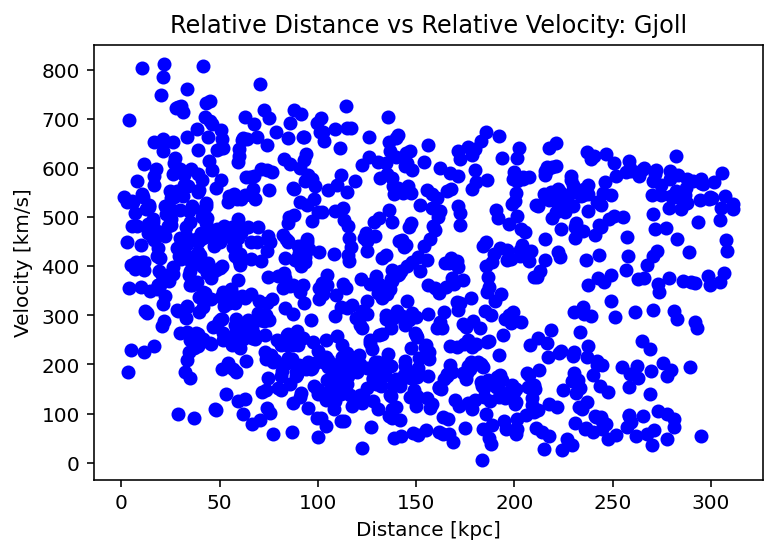

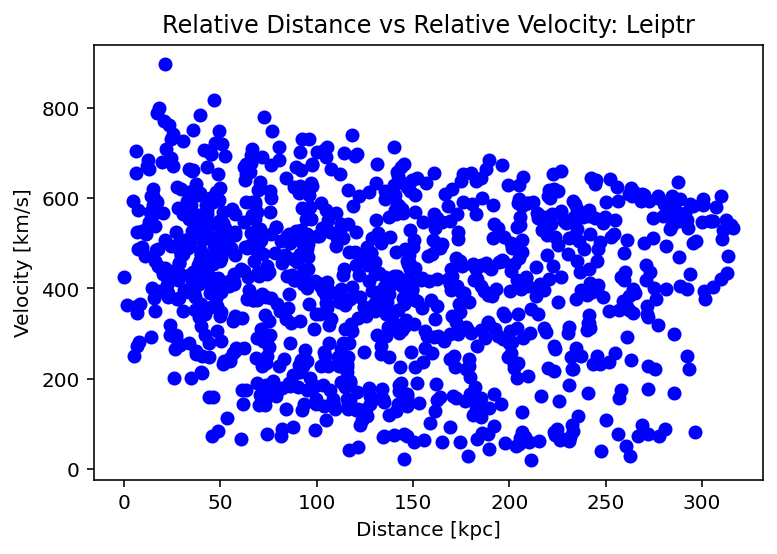

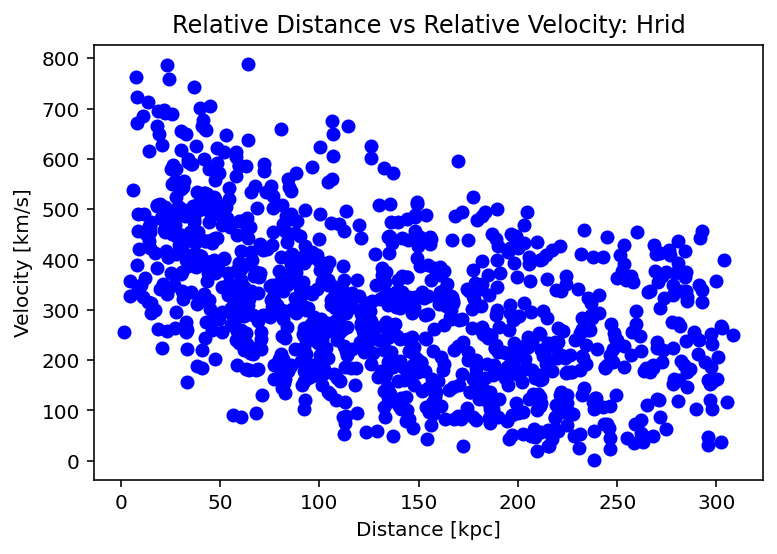

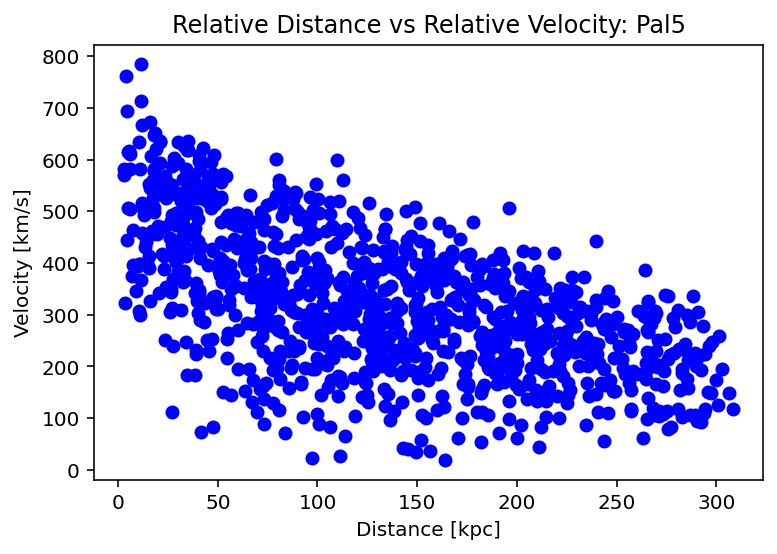

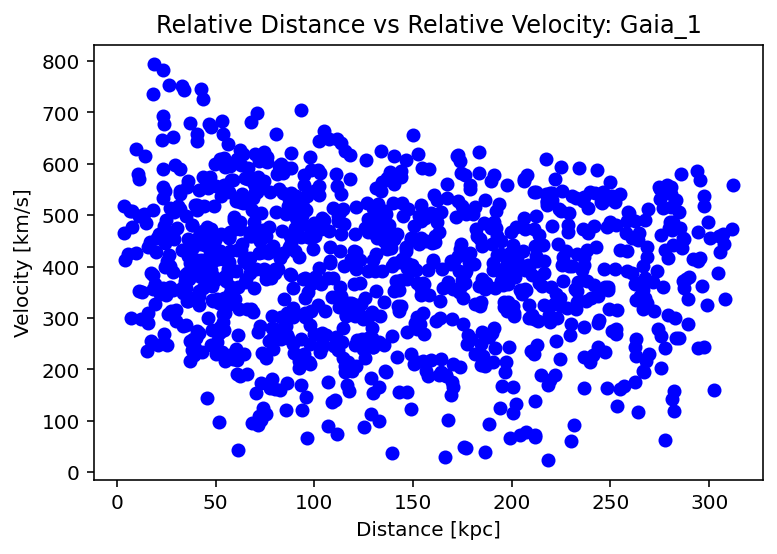

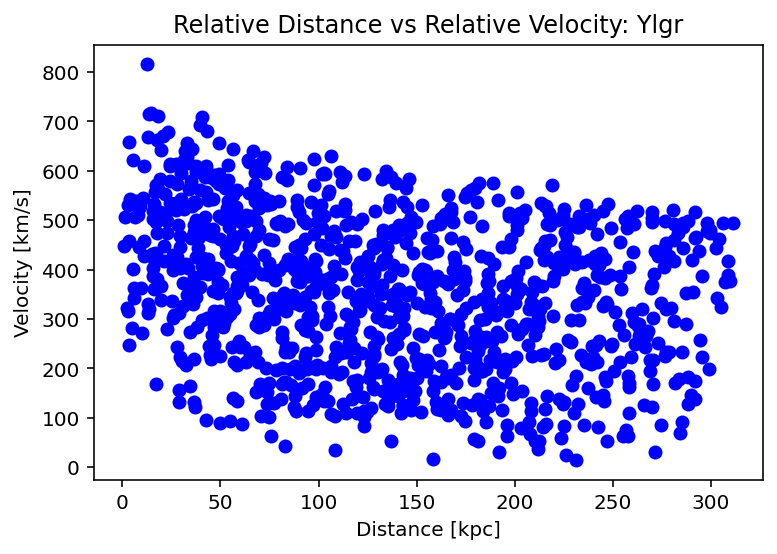

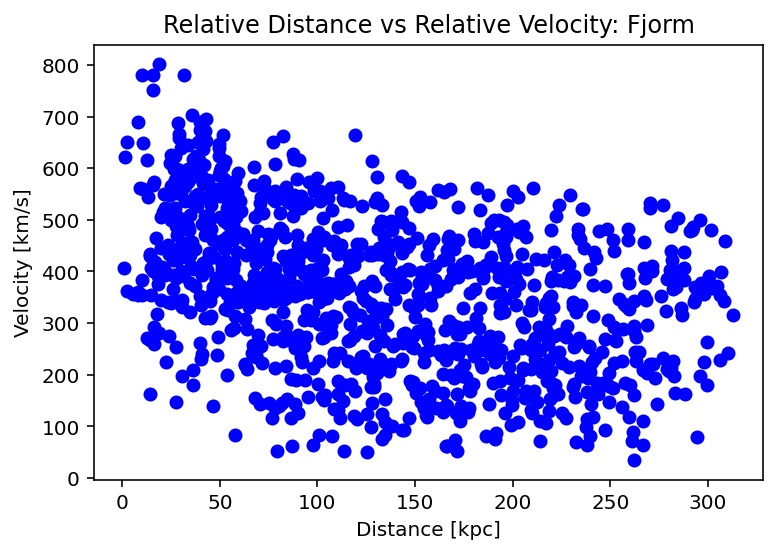

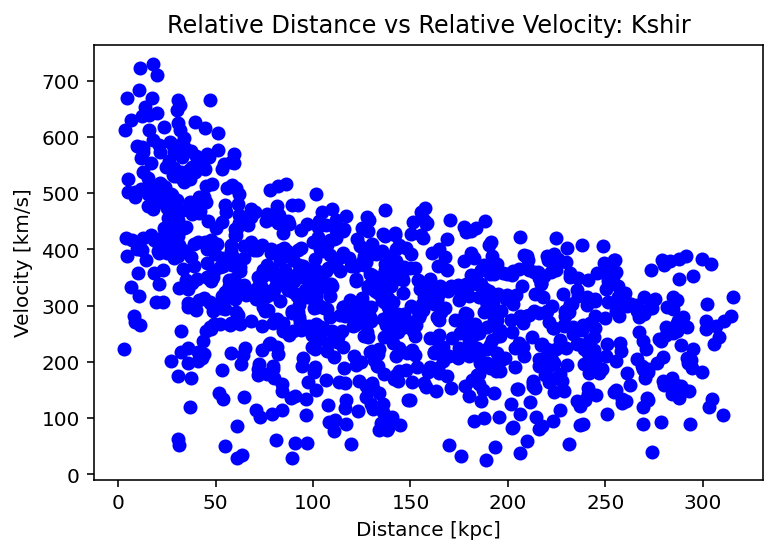

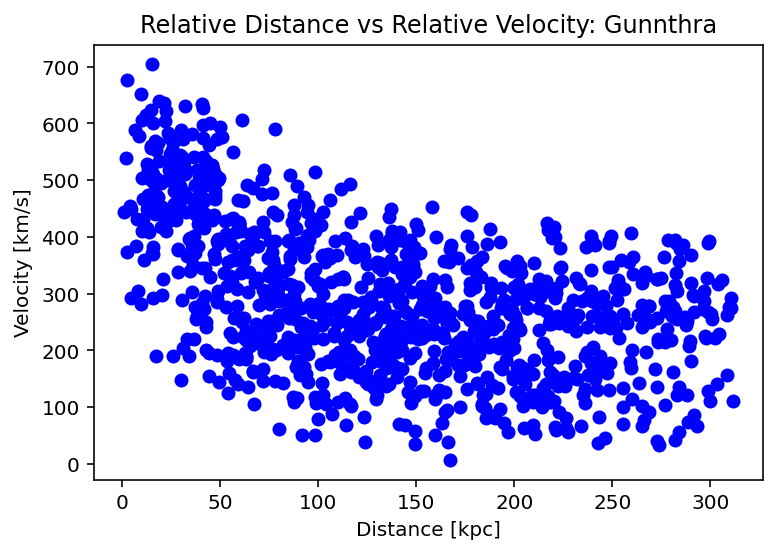

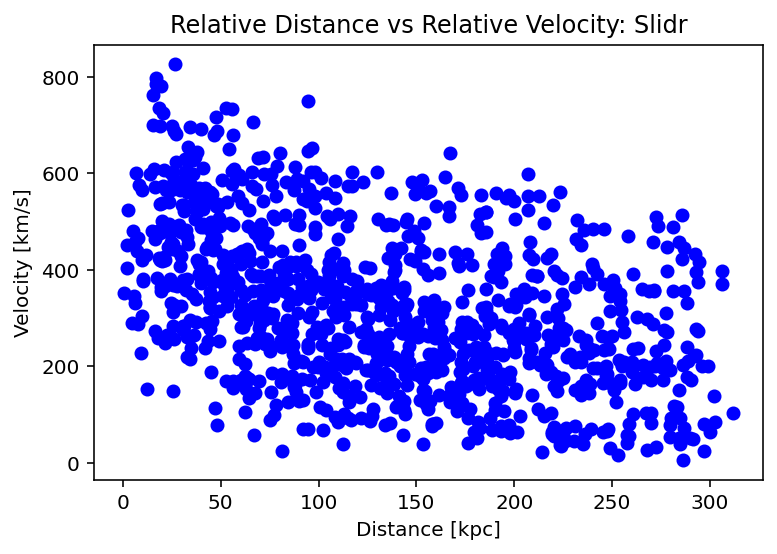

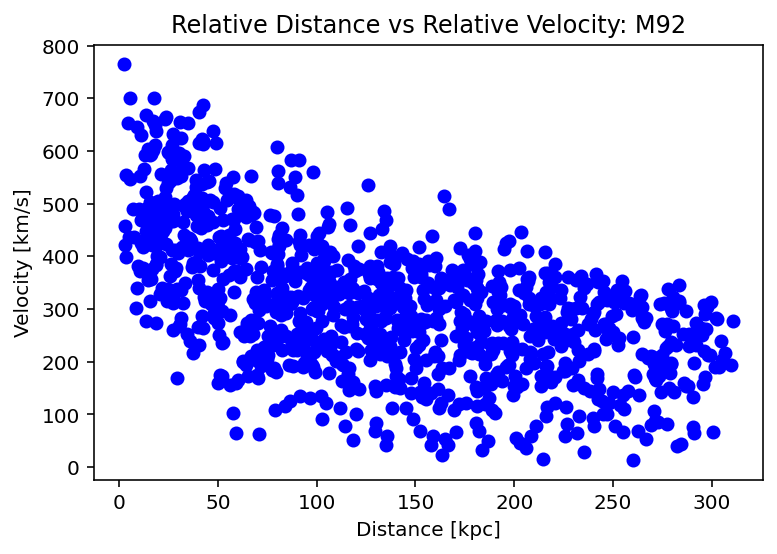

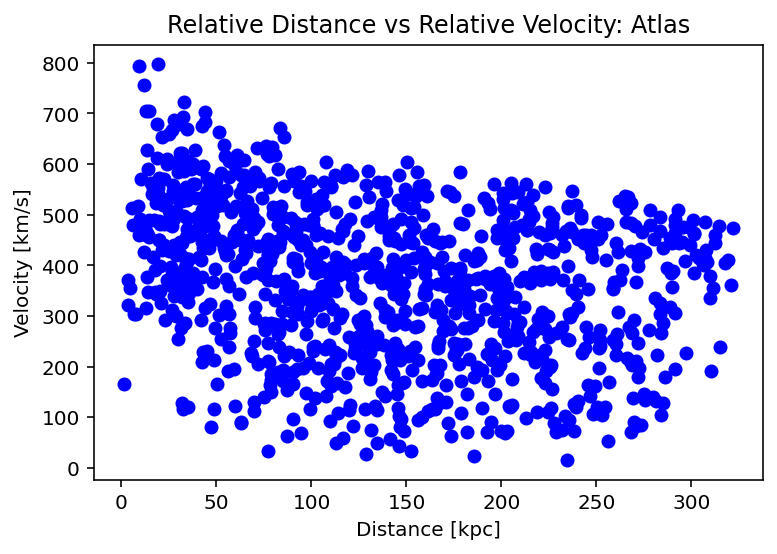

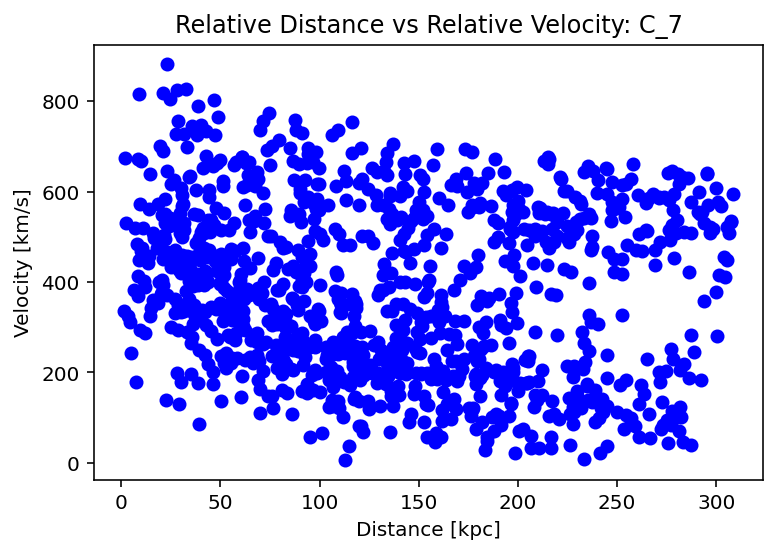

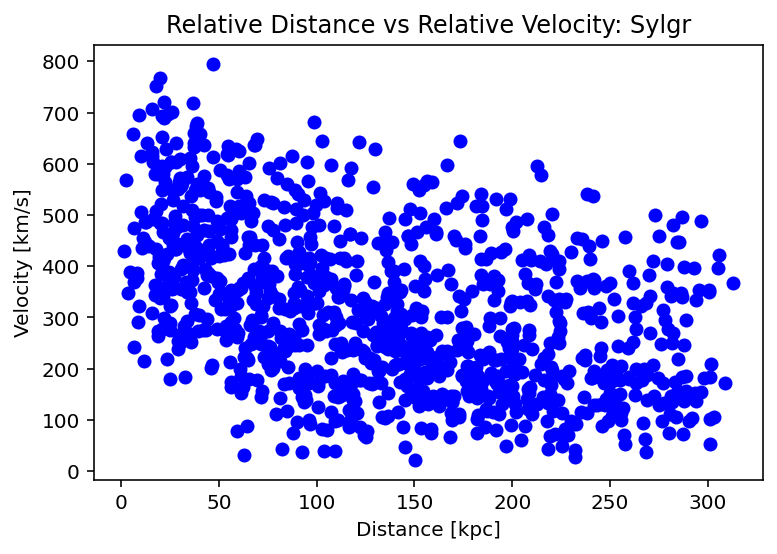

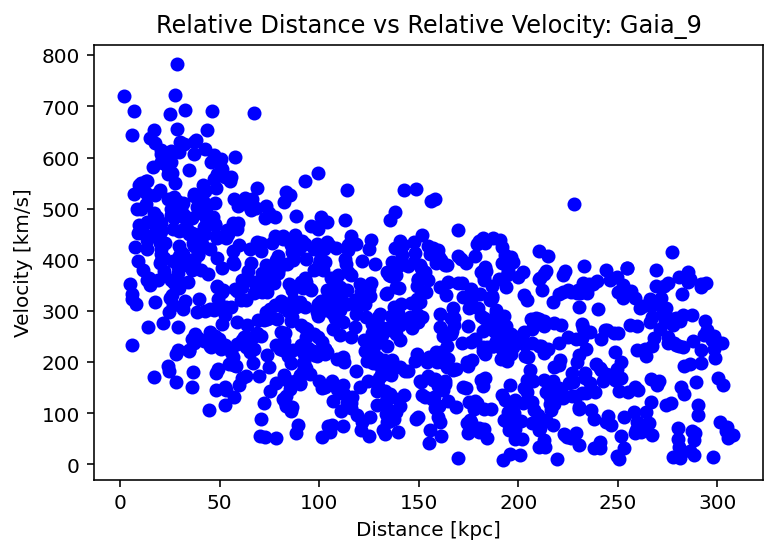

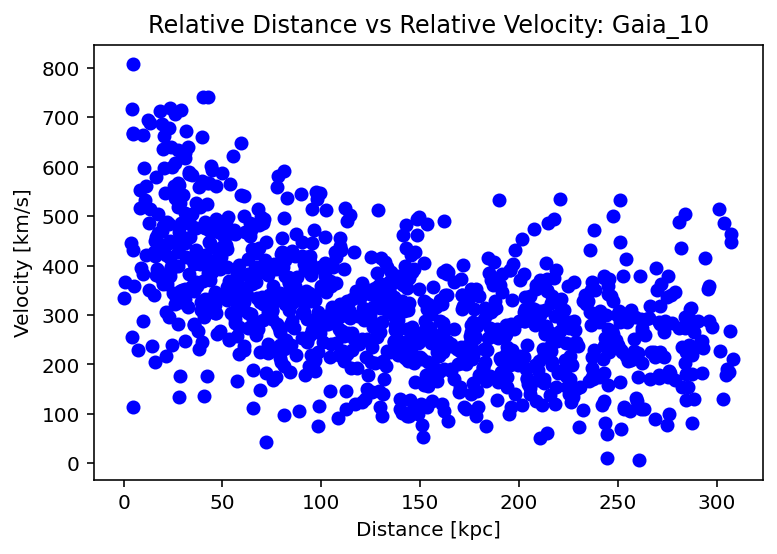

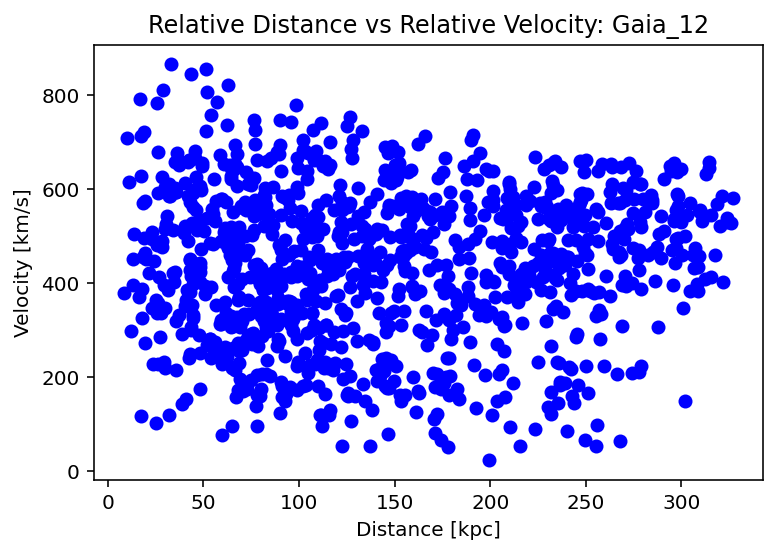

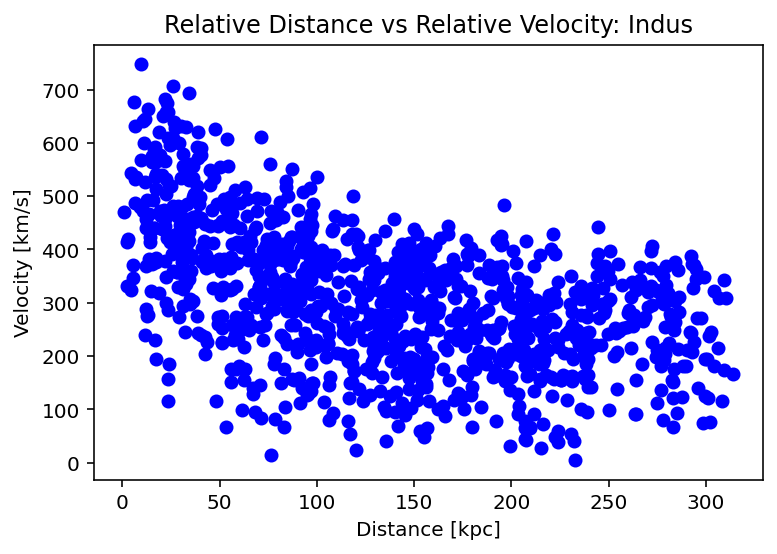

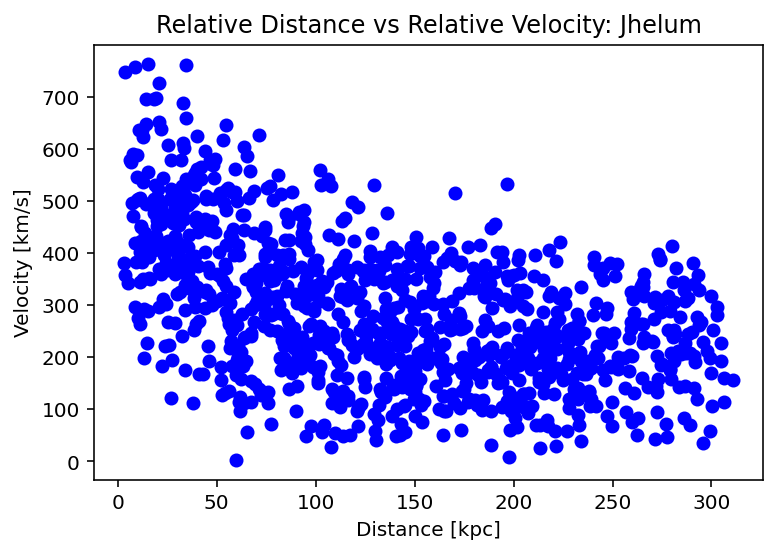

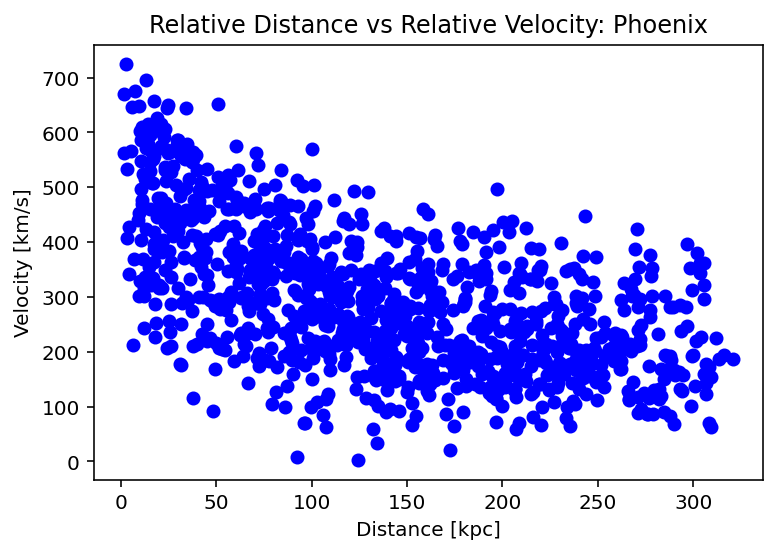

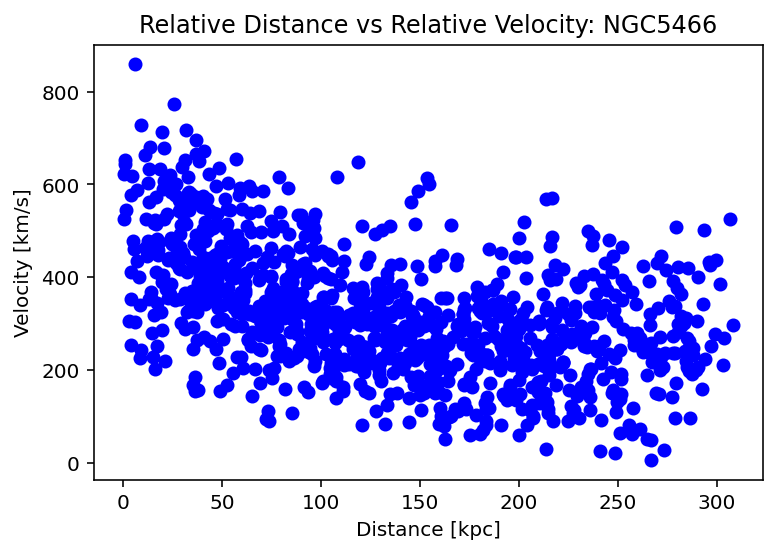

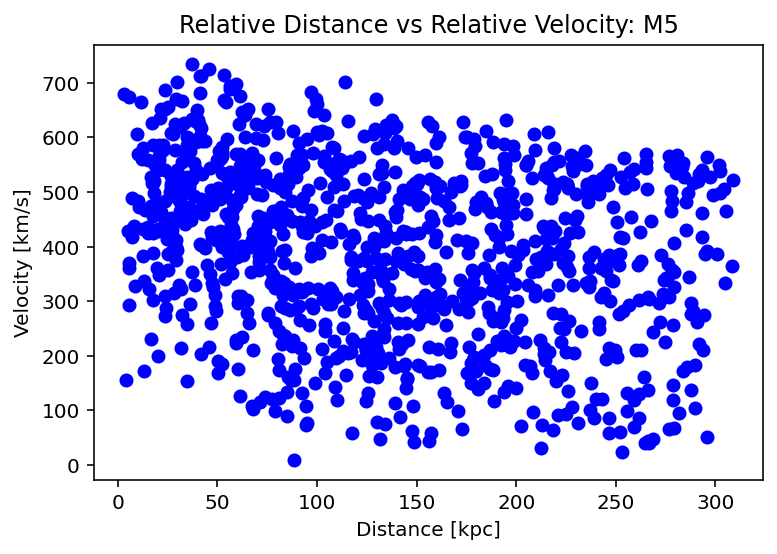

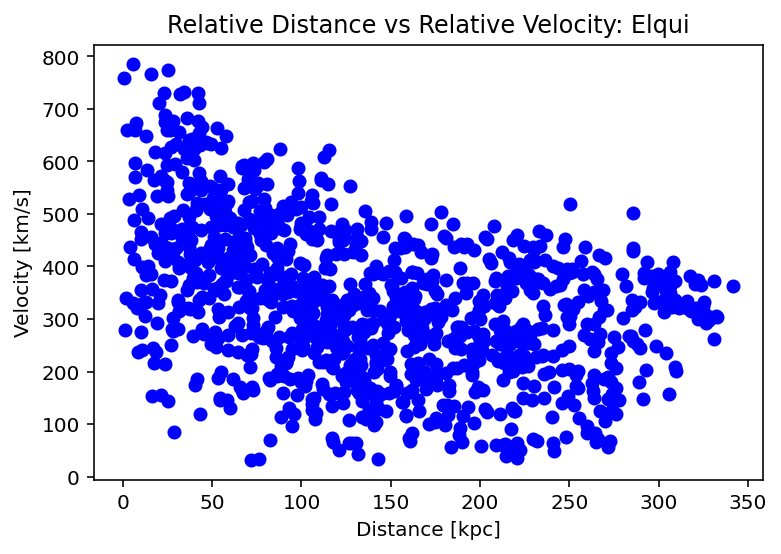

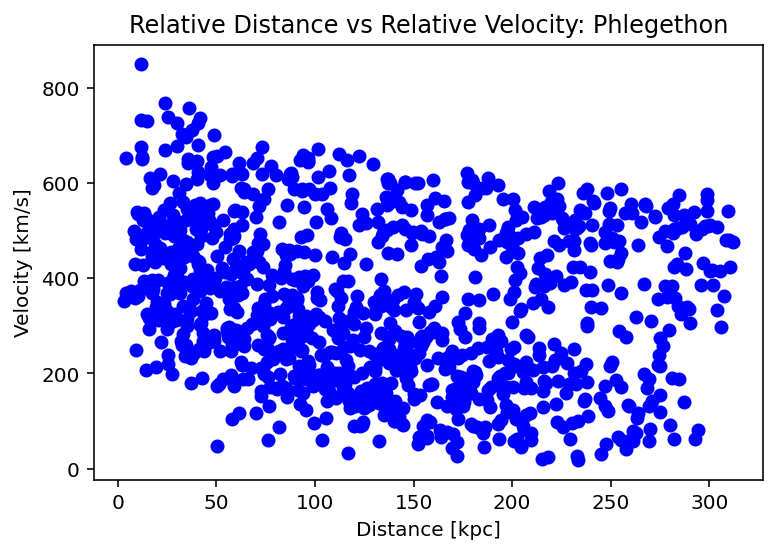

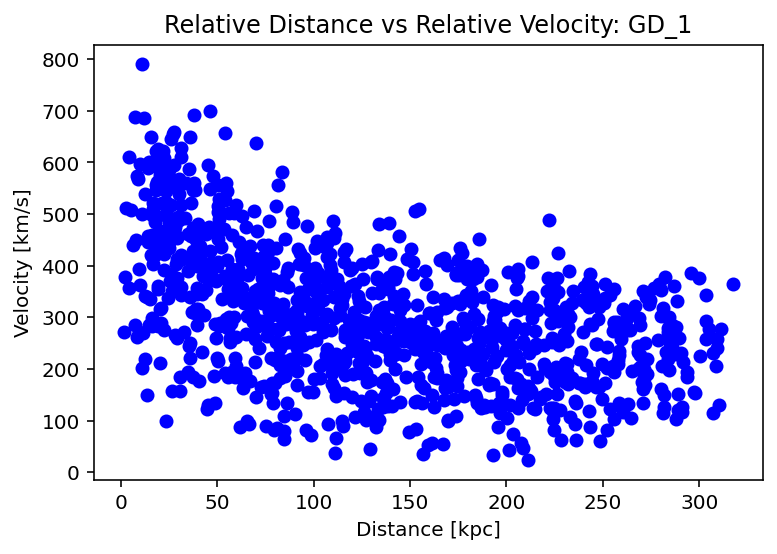

In [24]:
#Creating Visualization of Subhalo impact on streams (distance vs velocity kick)
for i in range(len(pb)):
    plt.figure()
    for subh in range(len(trot)):
        plt.scatter(pb['Subhalo_'+str(subh)+' Distance (kpc)'][i],pb['Subhalo_'+str(subh)+' Relative Velocity (km/s)'][i], color='blue') 
    plt.xlabel('Distance [kpc]')
    plt.ylabel('Velocity [km/s]')
    plt.title('Relative Distance vs Relative Velocity: '+str(pb.iloc[i][0]))
    plt.savefig('Distance_vs_Velocity/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200)
    
#Trend looks like an exponential decay.

## Calculation of Vel Kick Experienced During Closest Approach

<ipython-input-25-d18397a93f3f>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Quantity [0.00098323, 0.00104542, 0.00139817, 0.00159245, 0.00139251,
           0.001014  , 0.00122152, 0.00159339, 0.00155474, 0.00272446,
           0.00134797, 0.00068106, 0.00085576, 0.00280173, 0.00346983,
           0.0015388 , 0.00096546, 0.00117664, 0.00239125, 0.00116182,
           0.00177004, 0.00100325, 0.00060888, 0.0010192 , 0.00178396] m3 solMass / (kg km kpc s)>

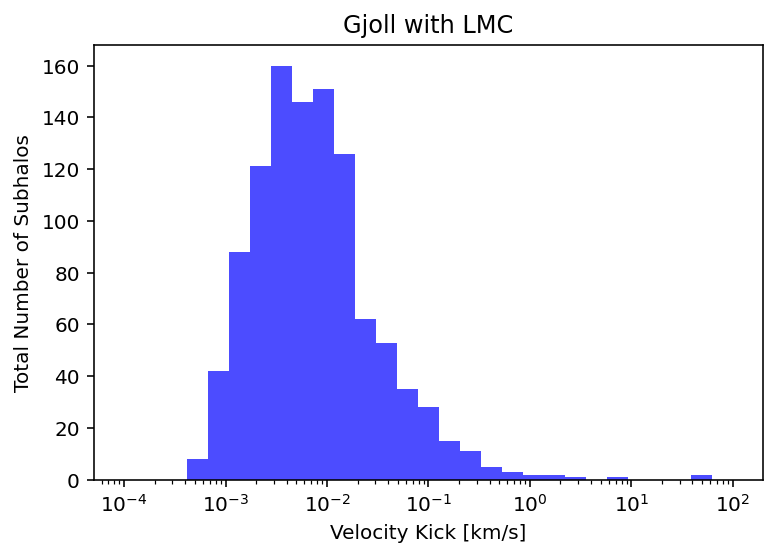

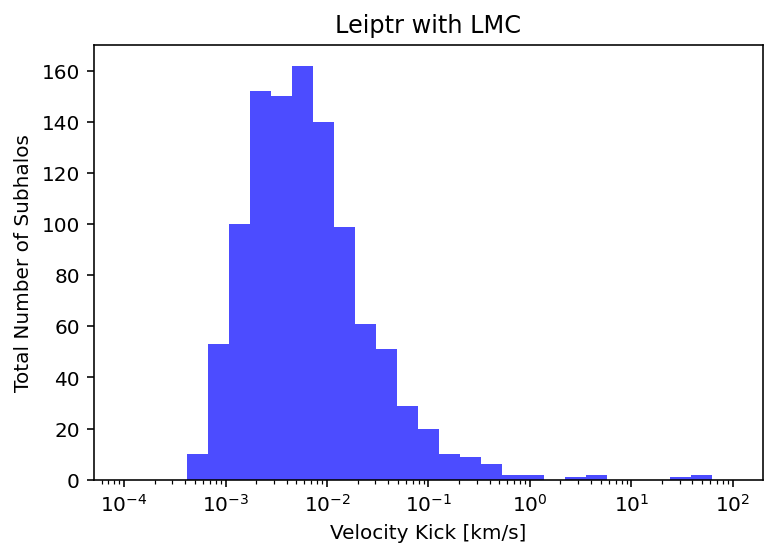

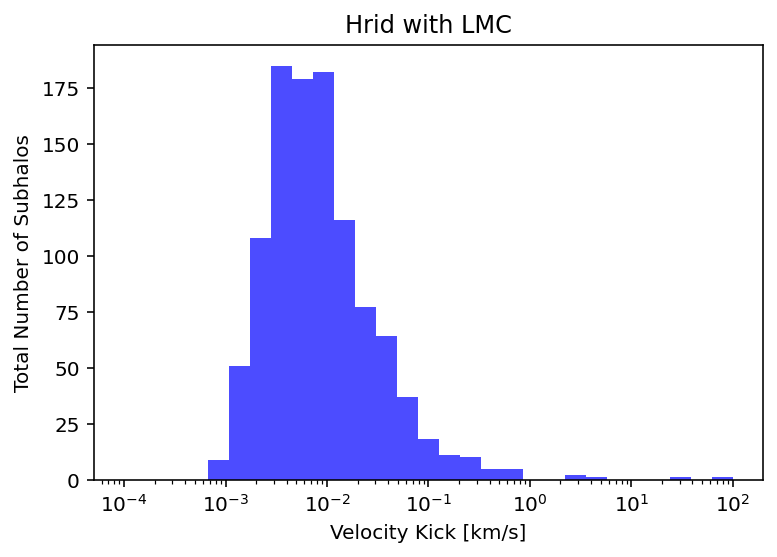

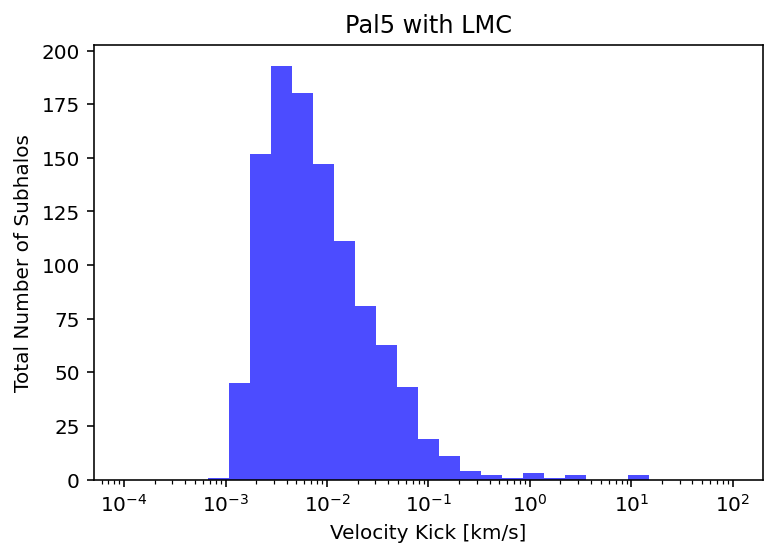

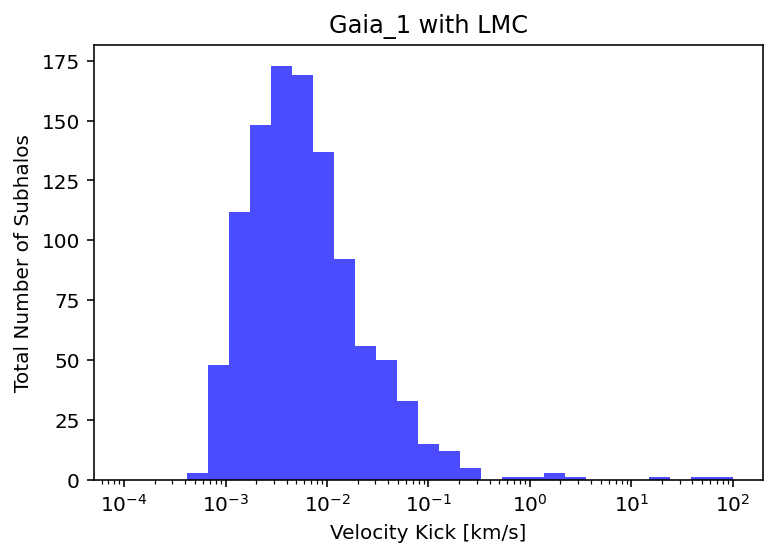

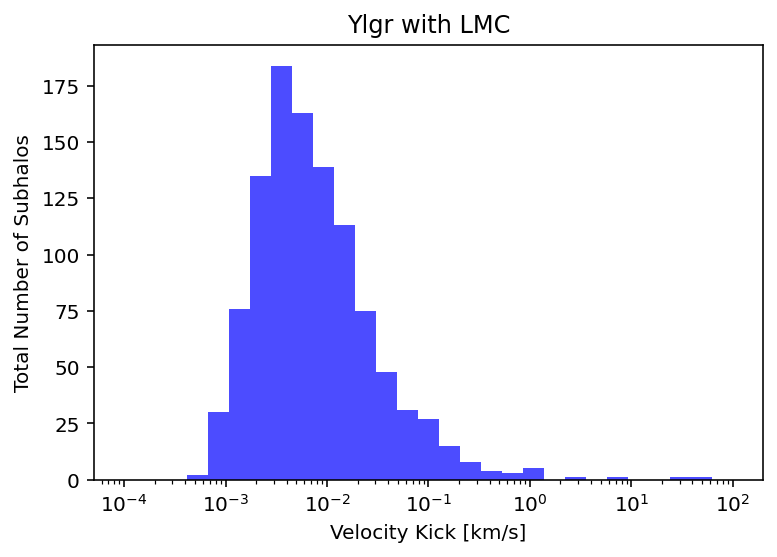

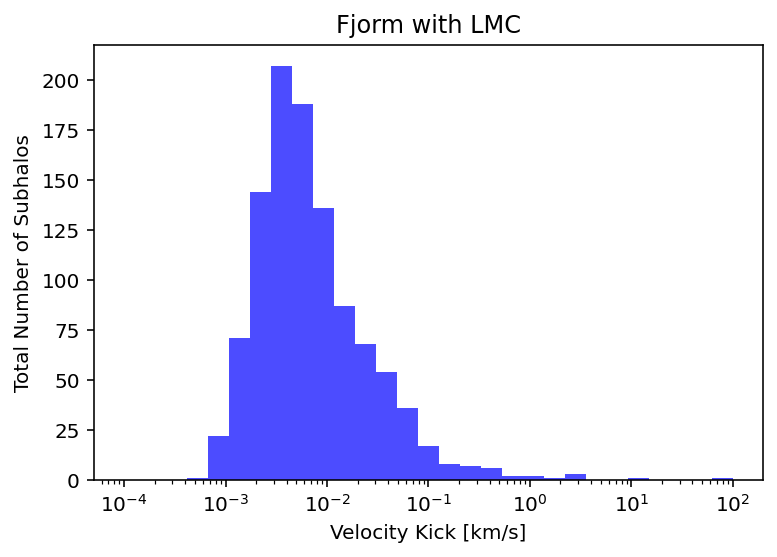

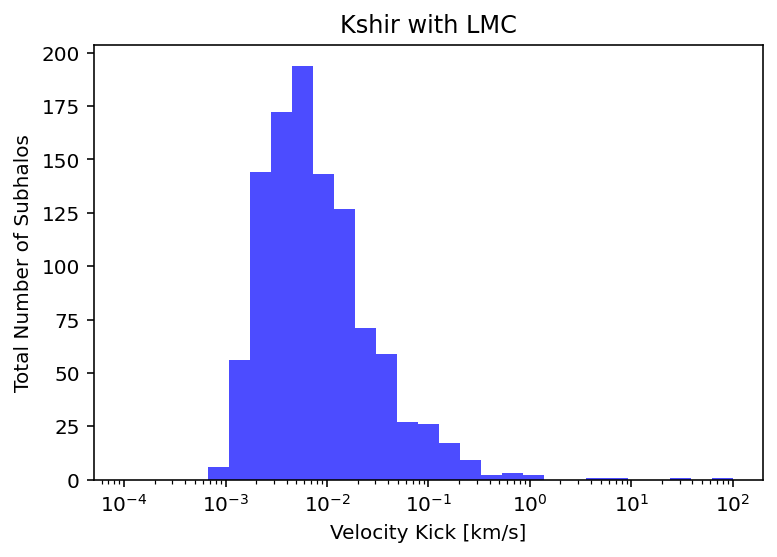

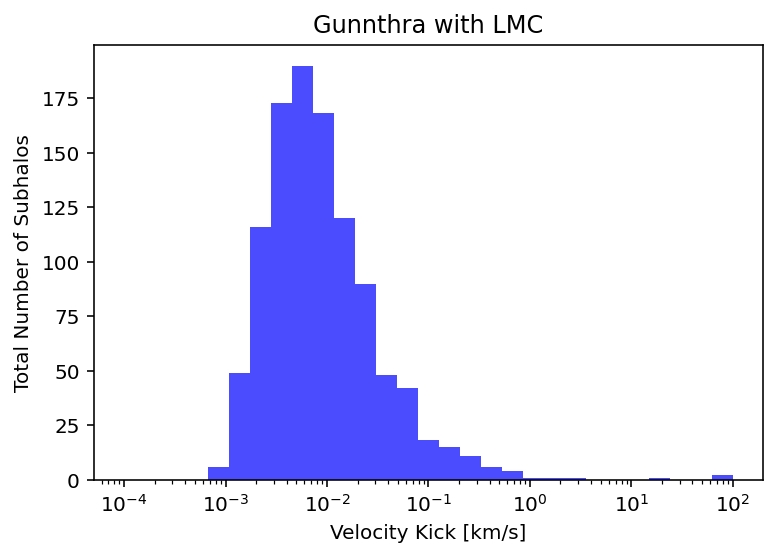

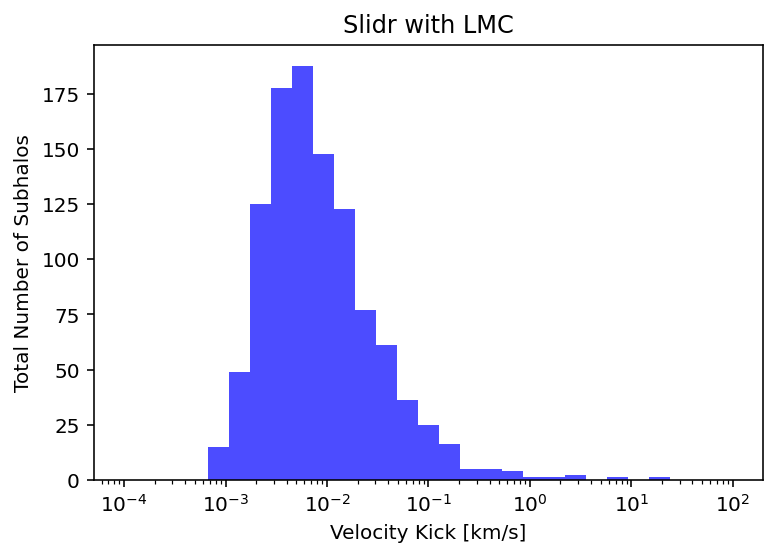

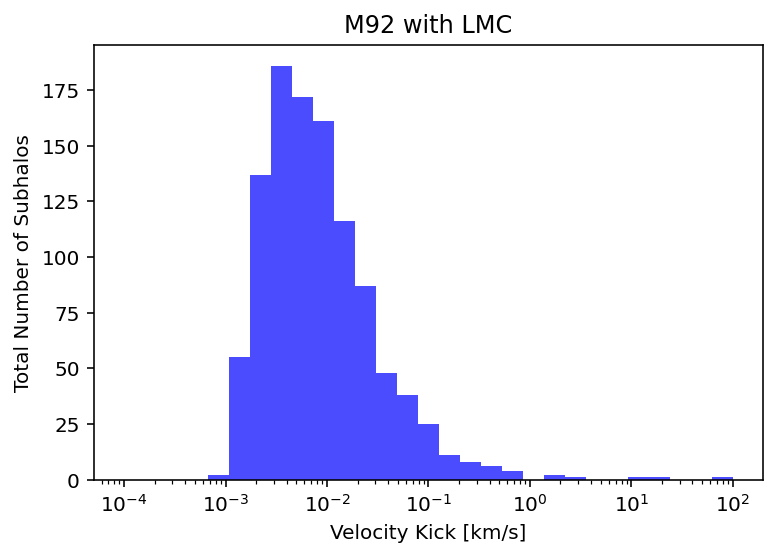

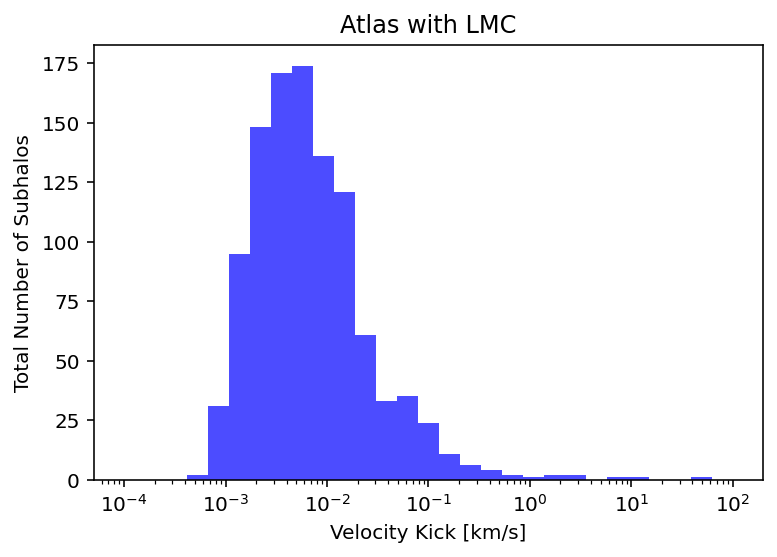

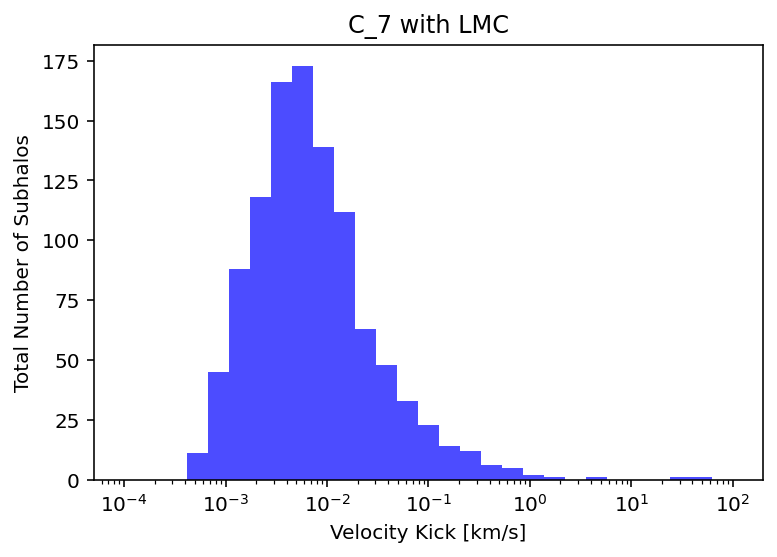

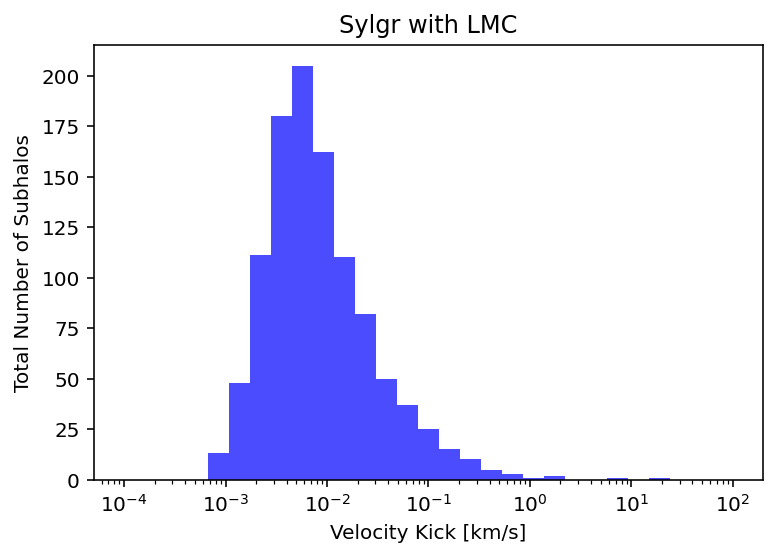

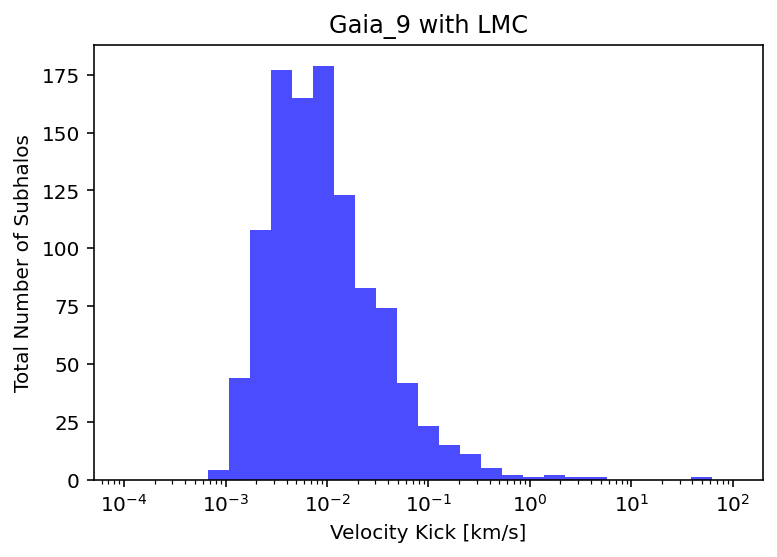

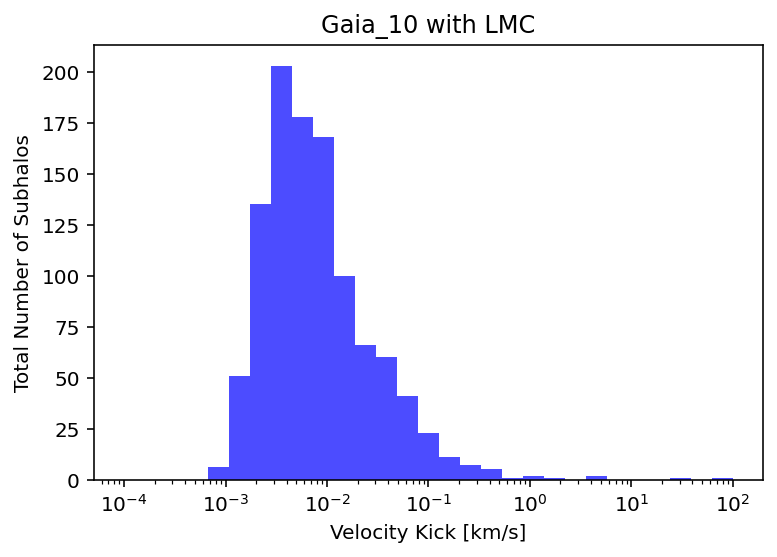

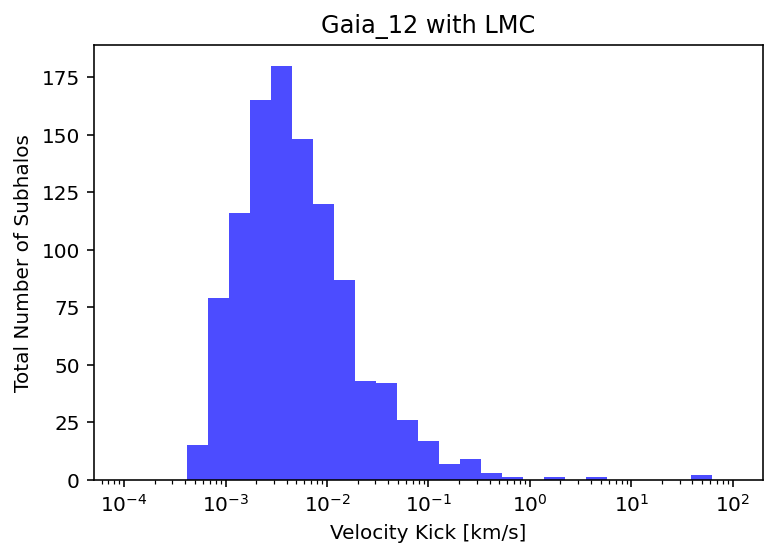

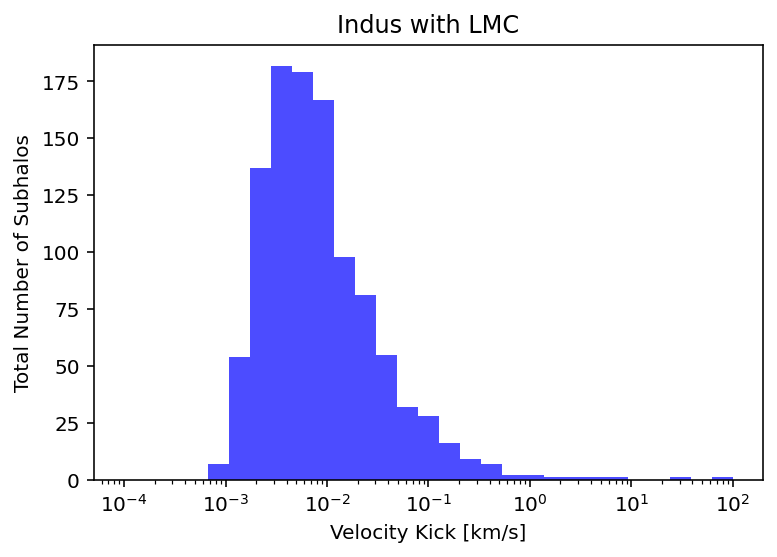

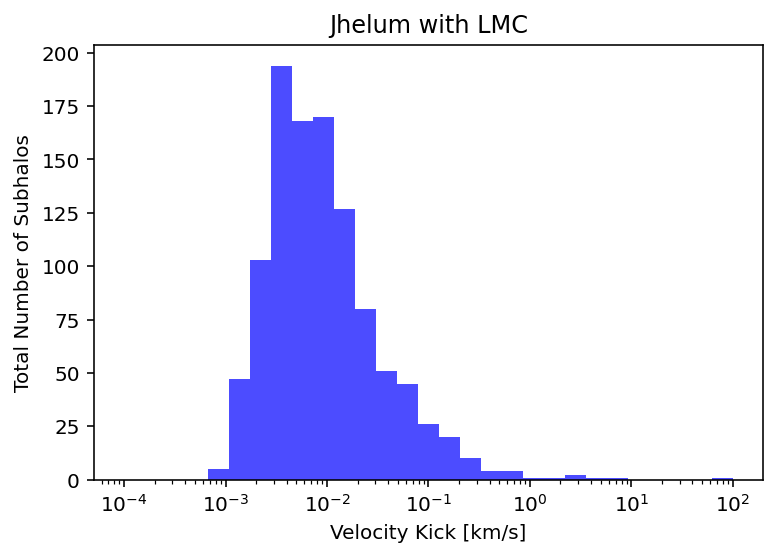

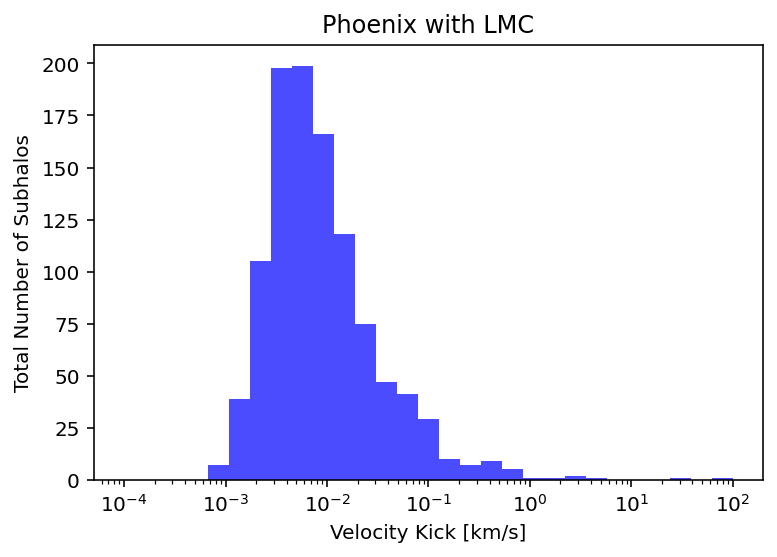

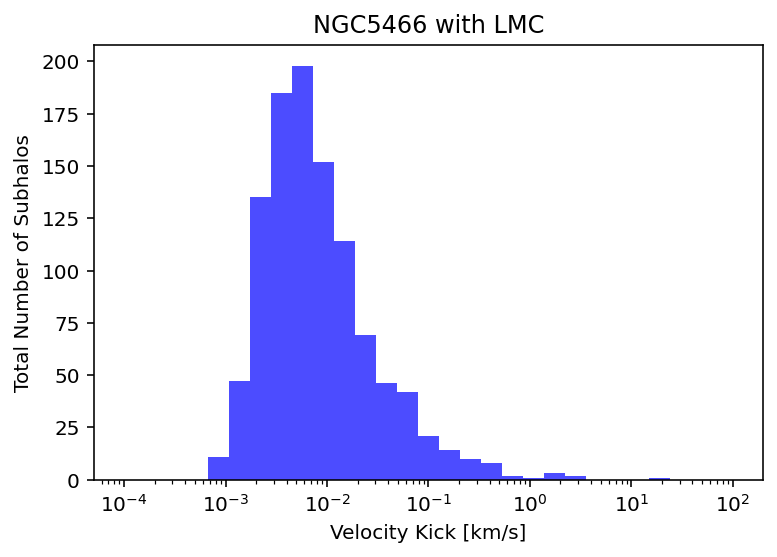

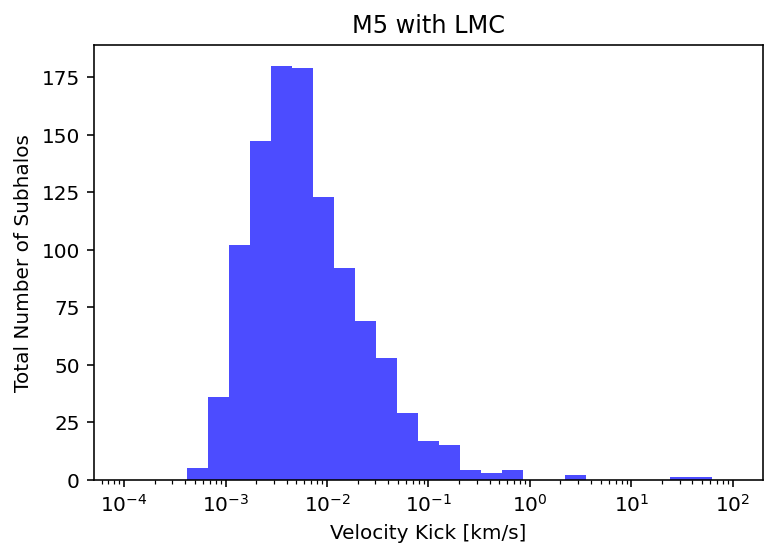

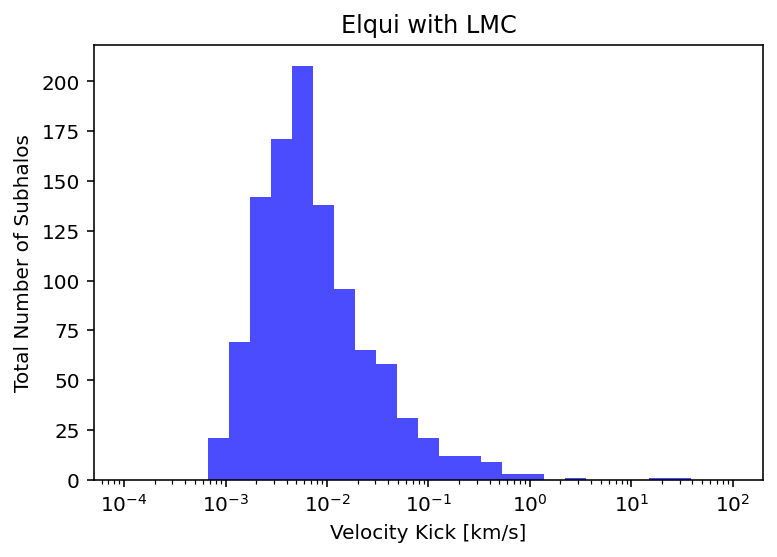

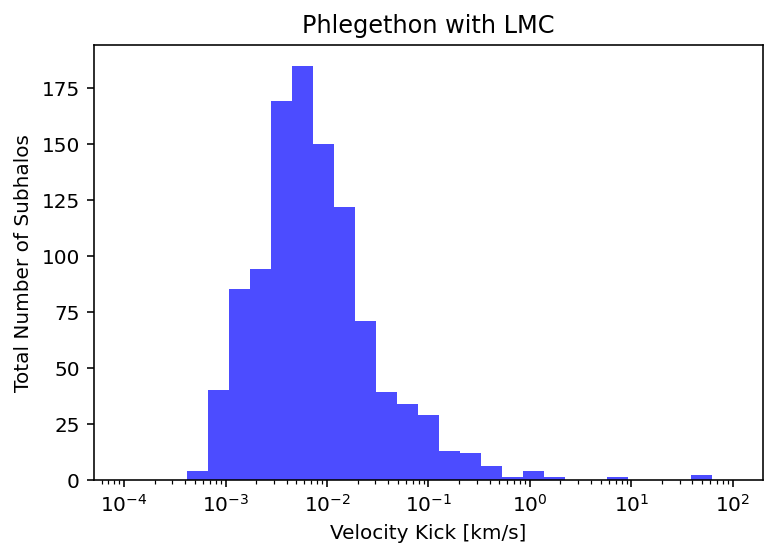

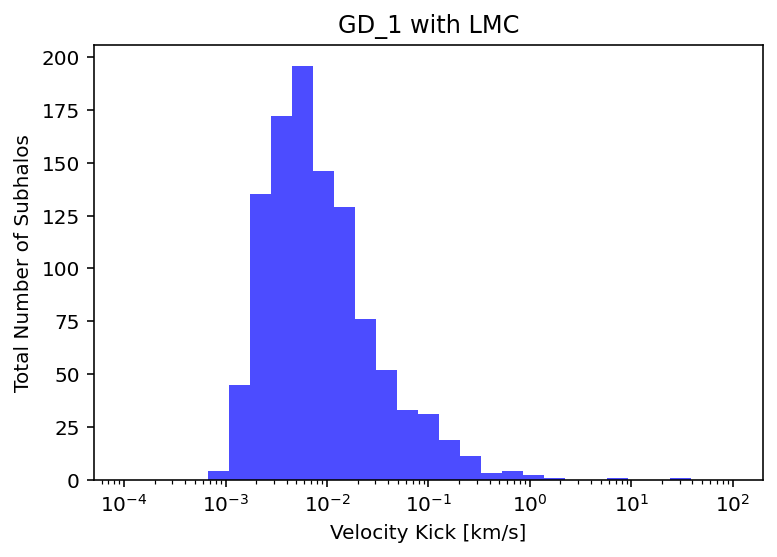

In [25]:
#Calculation of Velocity Kick WITH LMC
vel_kick = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
#there are 1062 contributions to velocity changes per stream
data_all = pd.DataFrame()
for i in range(len(pb)):
    
    #Calculating Velocity Kick 
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
    r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest relative distance between subhalos and stream 
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative velocity btwn stream and subhalos 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
    delta_v = 2*G*mass_subh/(r_min*v_rel) 

    plt.figure()
    delta_v_km_new = delta_v.to(u.km/u.s)
    plt.hist(delta_v_km_new.value, bins=np.logspace(-4,2,30) , color='blue', alpha=0.7)
    plt.gca().set_xscale('log') 
    plt.xlabel('Velocity Kick [km/s]')
    plt.ylabel('Total Number of Subhalos')
    plt.title(str(pb.iloc[i][0])+' with LMC')
    plt.savefig('Vel_Kick_Histogram_with_LMC/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200)
    
    
    vel_kick_temp = np.sqrt(np.sum(delta_v**2))
    vel_kick[i] = vel_kick_temp
vel_kick


    


<ipython-input-26-68368c4caefb>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Quantity [1.78395596e-03, 1.78395585e-03, 1.78395537e-03, 1.78395533e-03,
           1.78395497e-03, 1.78395496e-03, 1.78395496e-03, 4.38482971e-04,
           4.38482827e-04, 4.38482376e-04, 1.39609306e-04, 4.91709431e-05,
           4.91072114e-05, 4.48412247e-05, 3.42129010e-05, 3.23834506e-05,
           3.08751048e-05, 3.03495854e-05, 2.87420295e-05, 2.83209764e-05,
           2.82563826e-05, 2.80097670e-05, 2.79495379e-05, 2.69343913e-05,
           2.65281955e-05] m3 solMass / (kg km kpc s)>

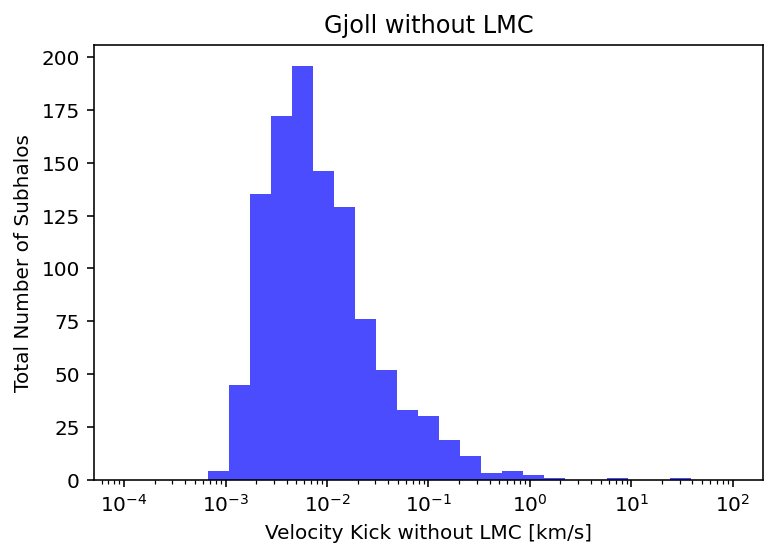

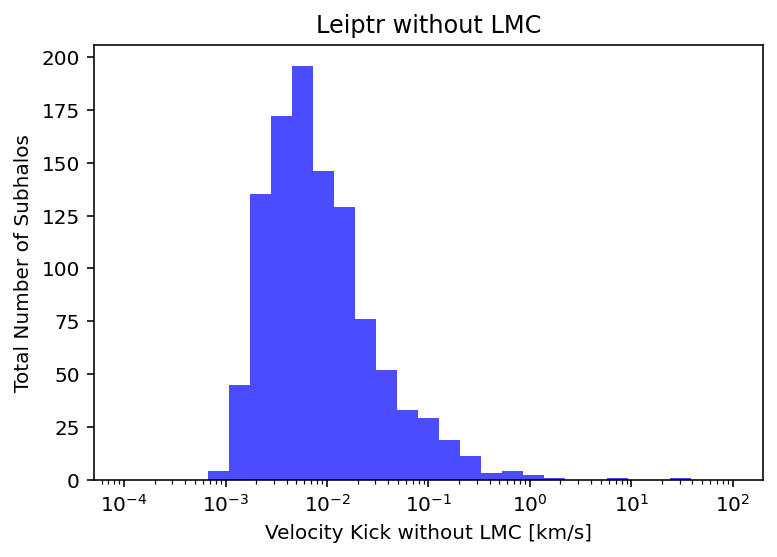

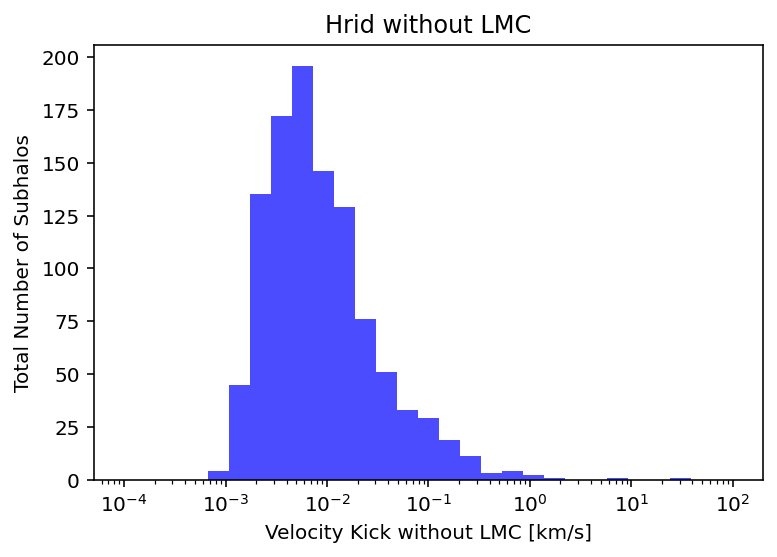

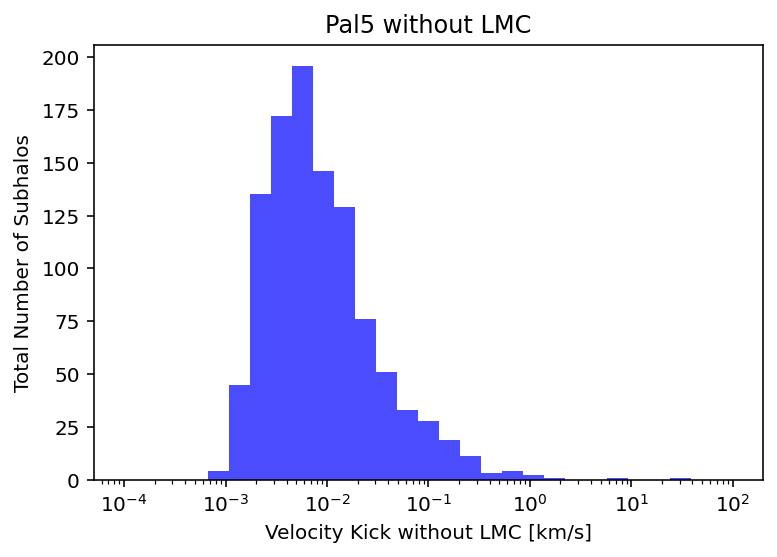

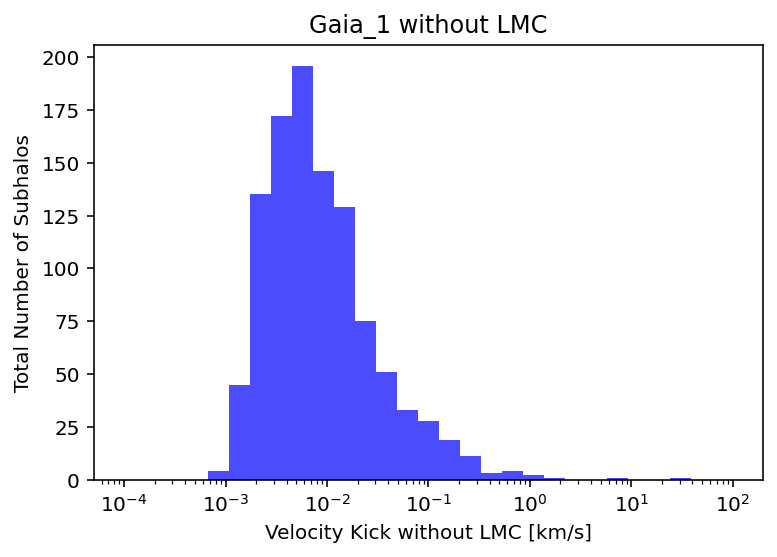

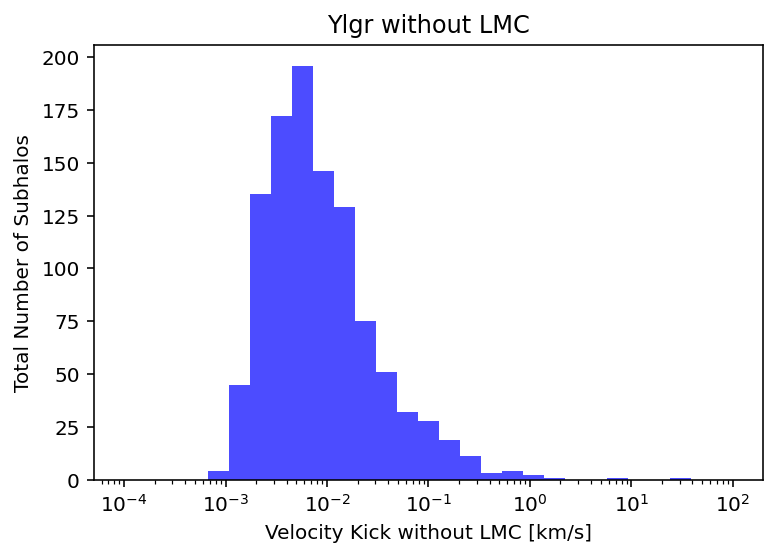

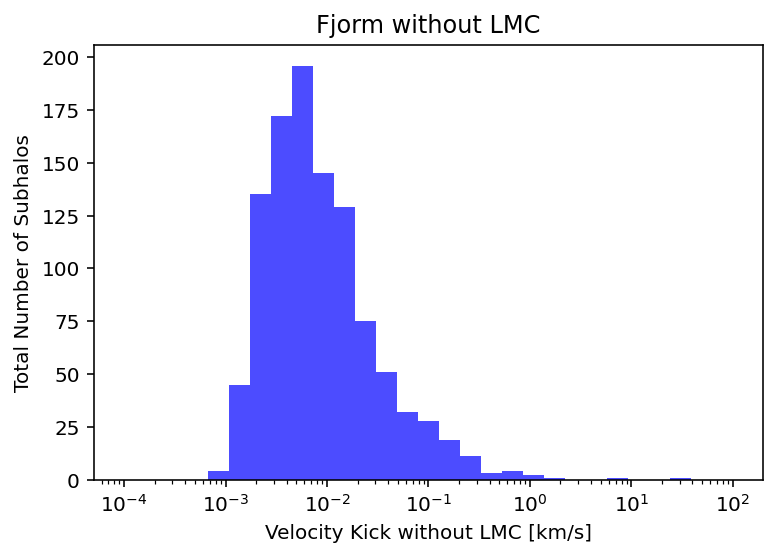

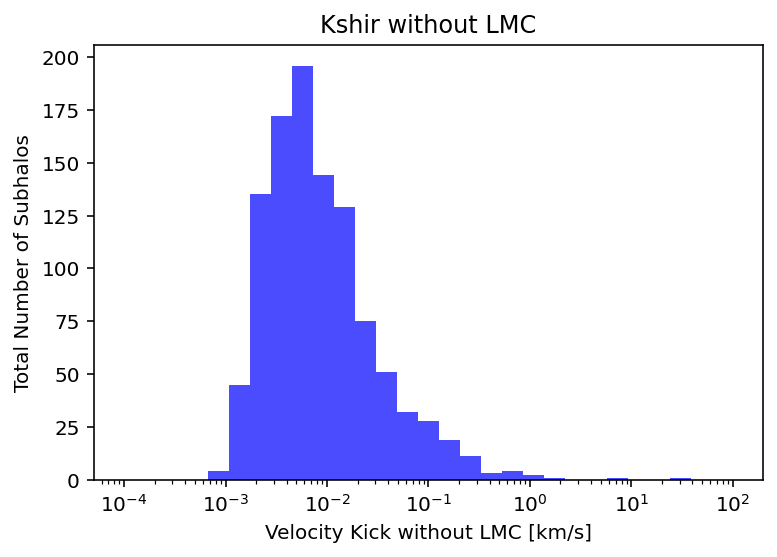

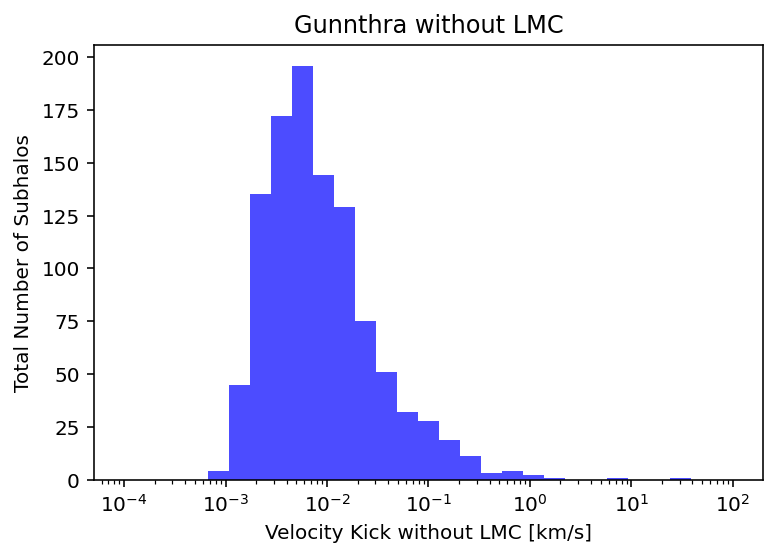

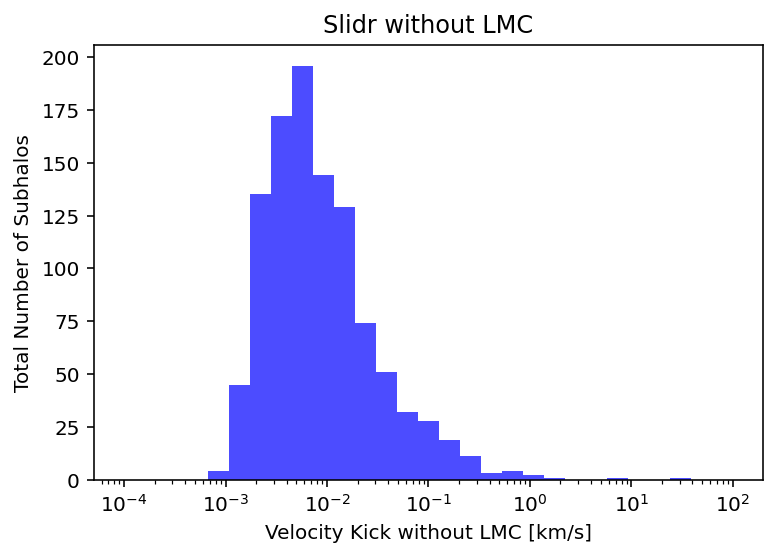

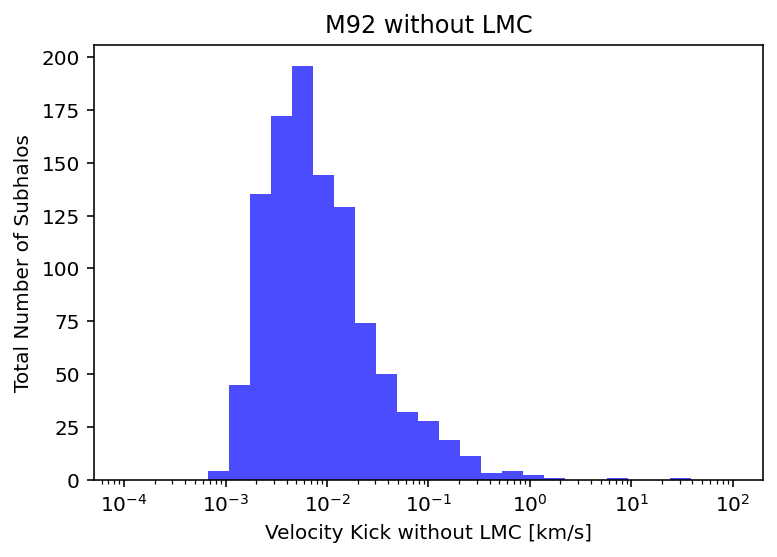

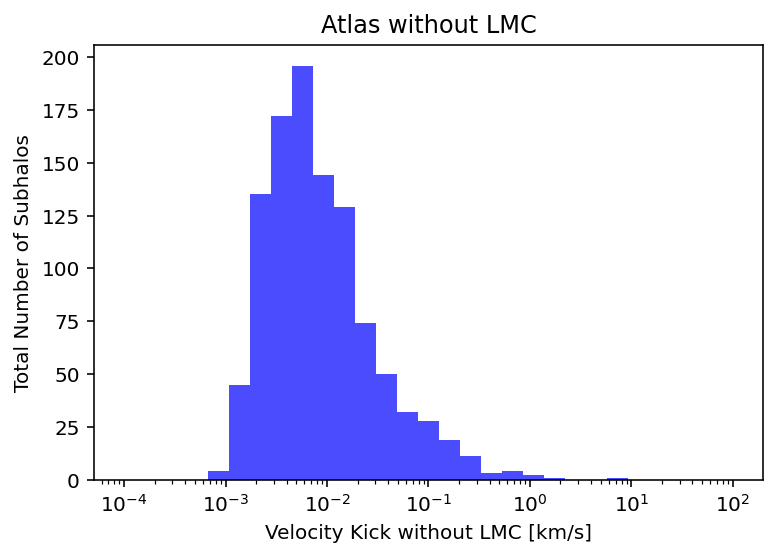

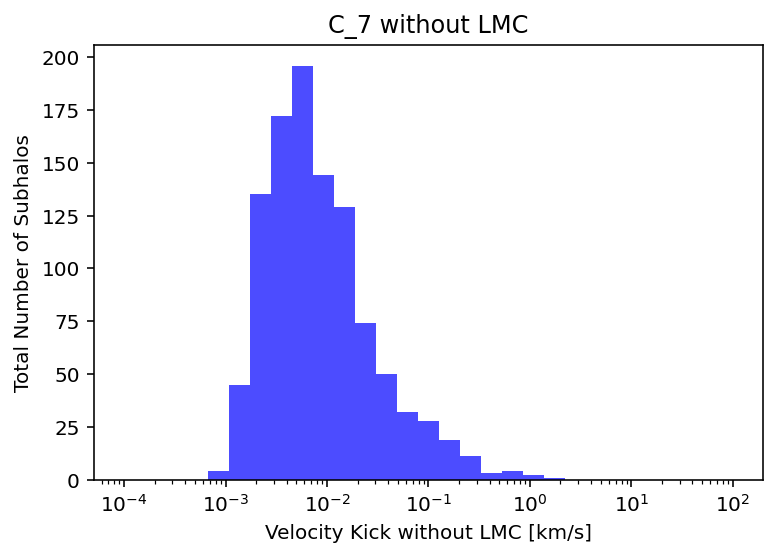

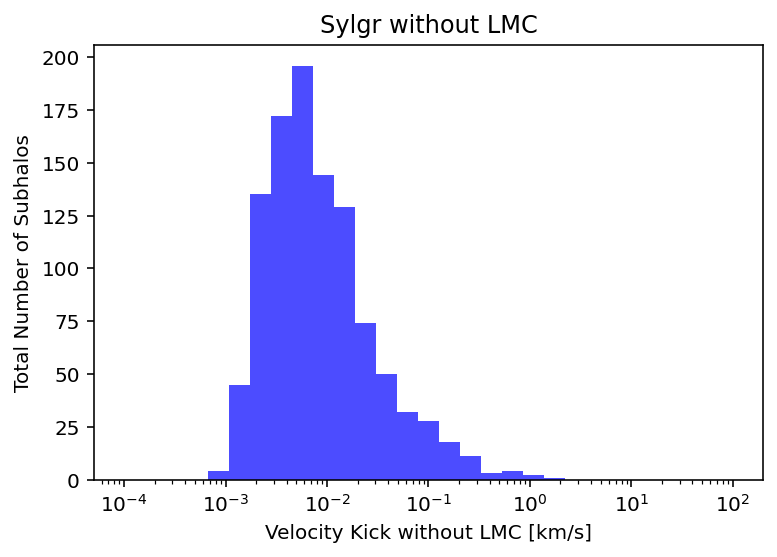

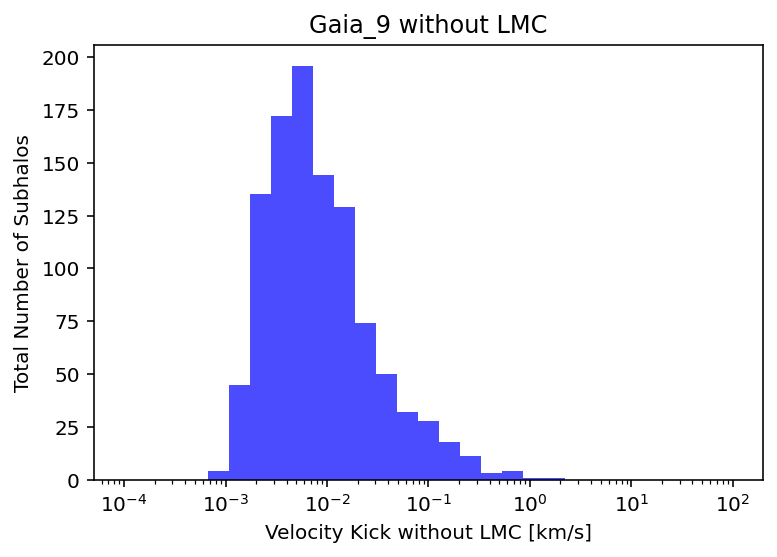

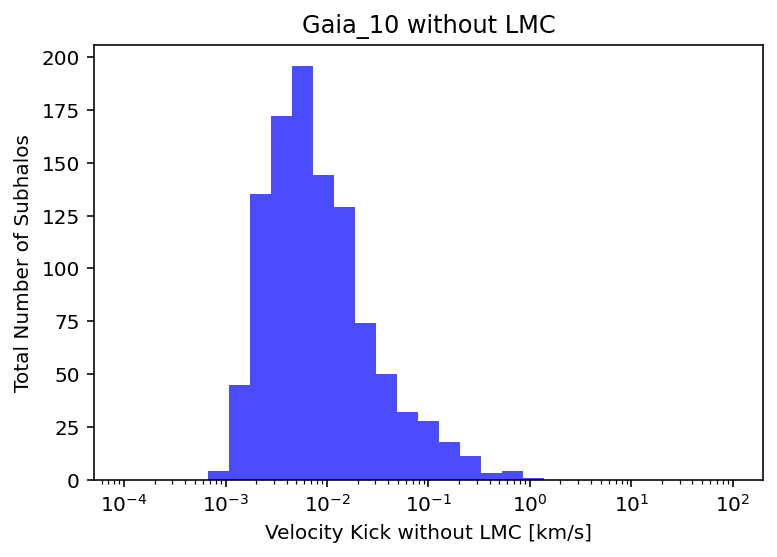

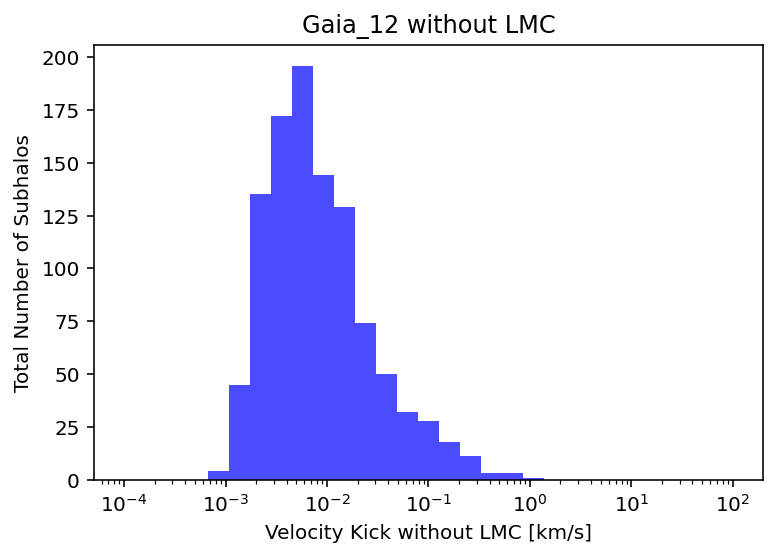

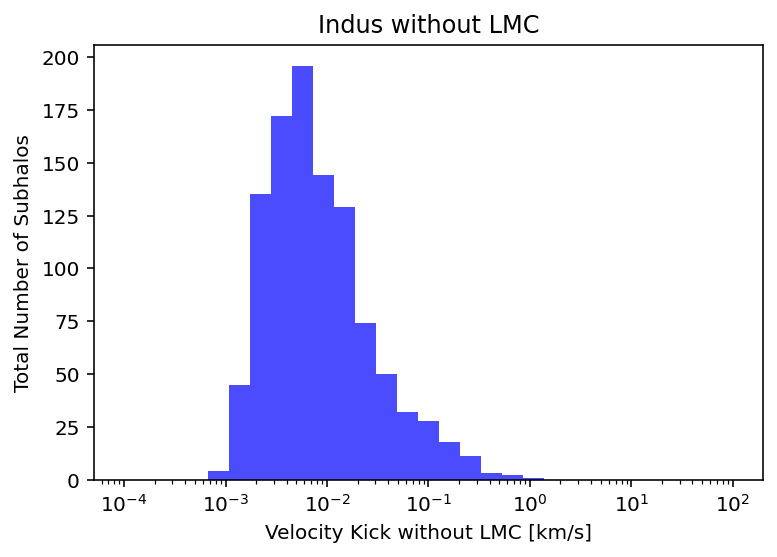

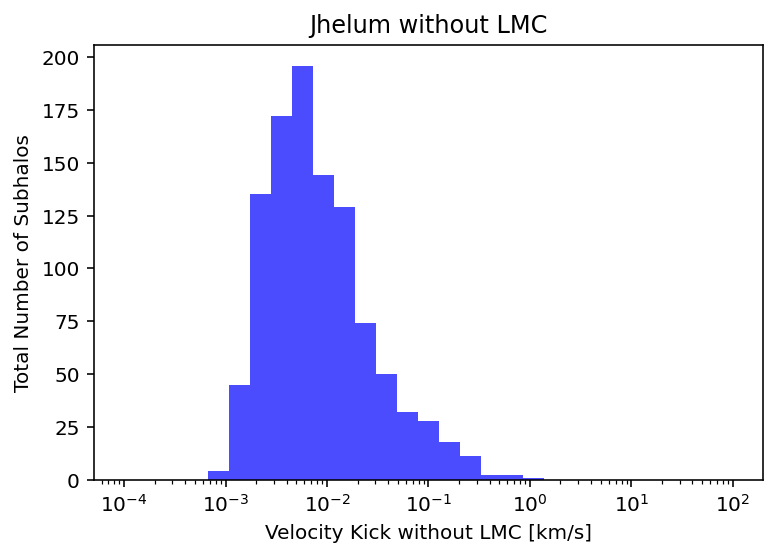

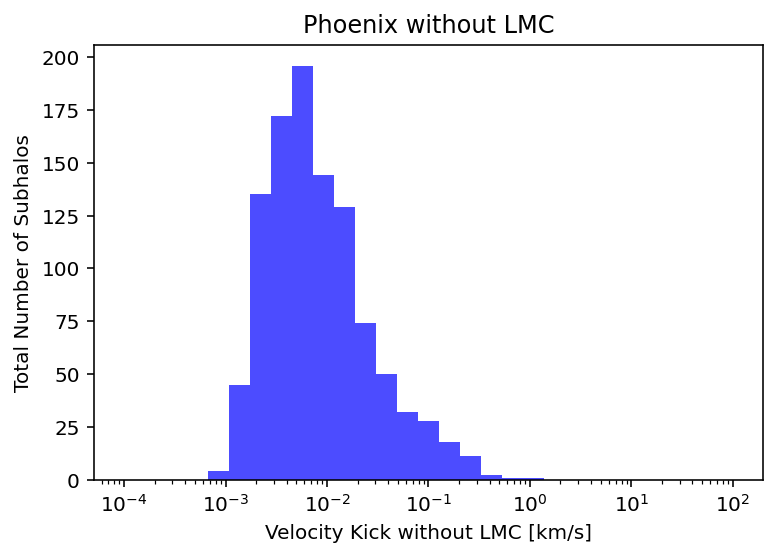

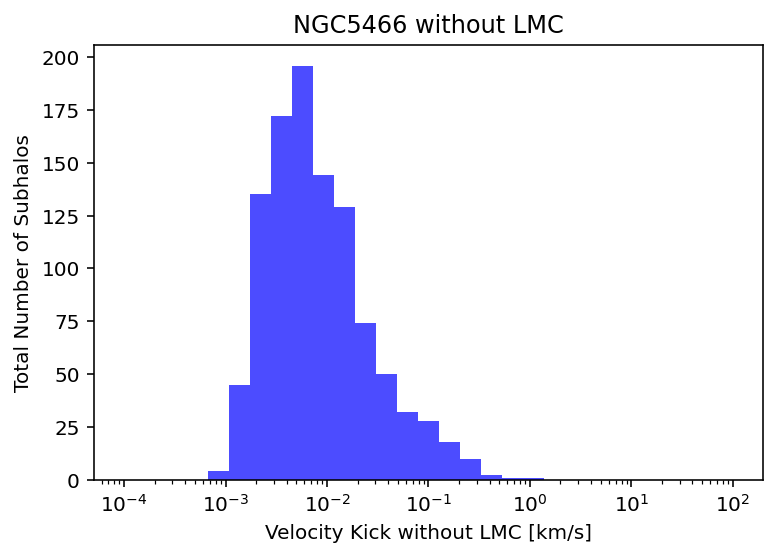

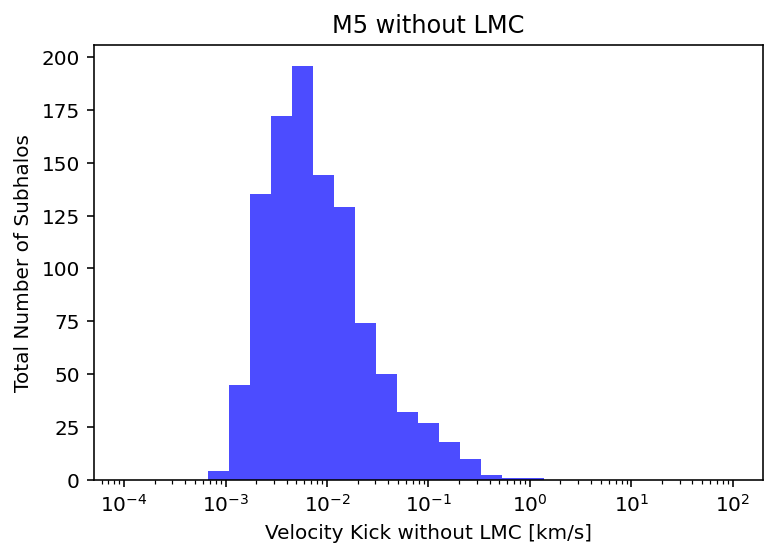

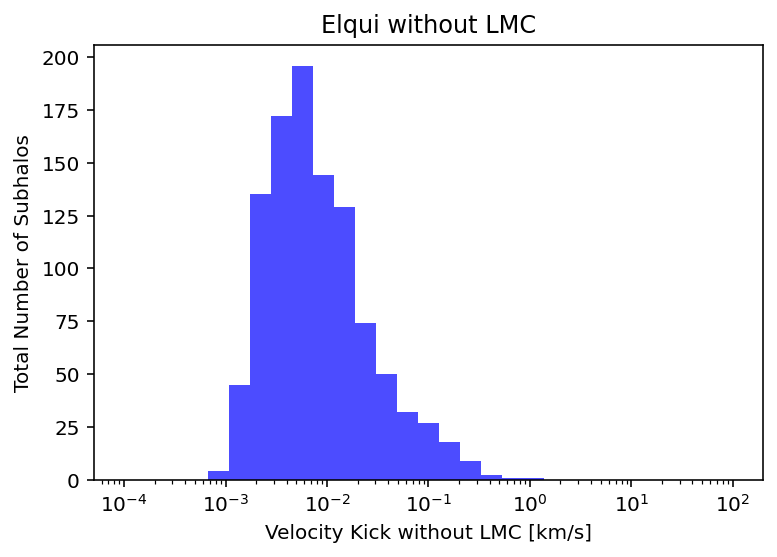

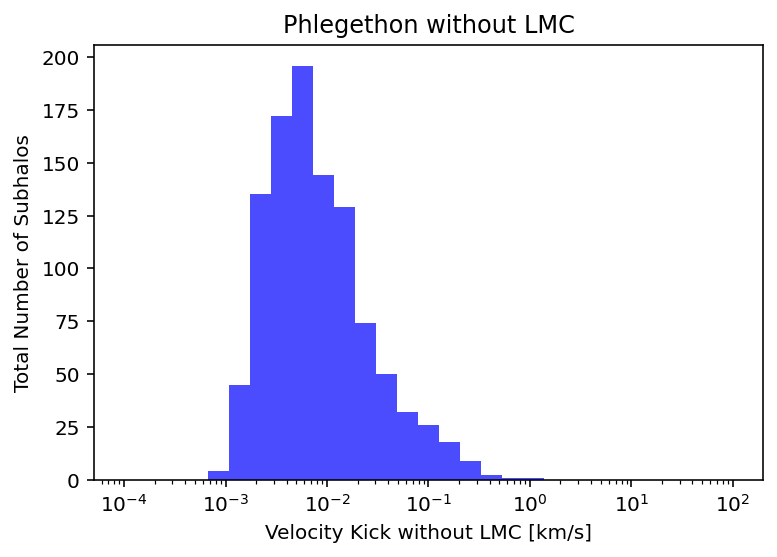

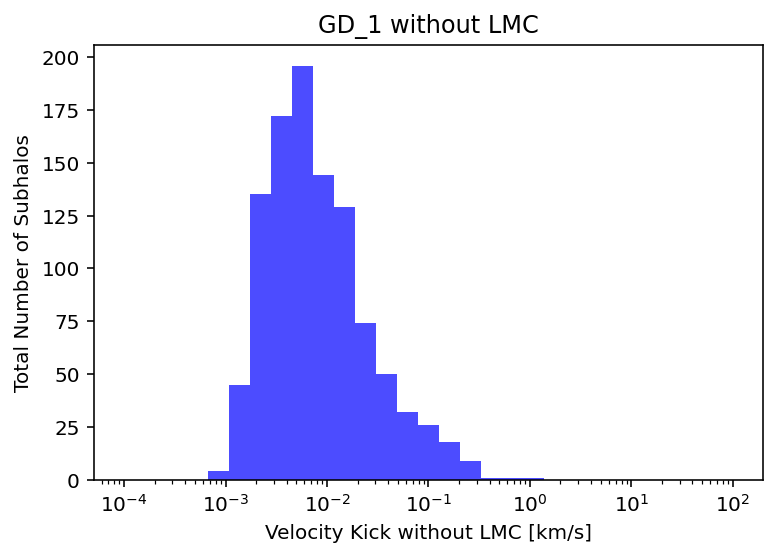

In [26]:
#Calculation of Velocity Kick Without LMC
vel_kick_no_LMC = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
for i in range(len(pb)):
    delta_v = delta_v[1:] #simply removing the change in velocity due to first index (LMC)
    
    plt.figure()
    delta_v_km_new = delta_v.to(u.km/u.s)
    plt.hist(delta_v_km_new.value, bins=np.logspace(-4,2,30) , color='blue', alpha=0.7)
    plt.gca().set_xscale('log') 
    plt.xlabel('Velocity Kick without LMC [km/s]')
    plt.ylabel('Total Number of Subhalos')
    plt.title(str(pb.iloc[i][0])+' without LMC')
    plt.savefig('Vel_Kick_Histogram_without_LMC/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200) 
    
    vel_kick_temp = np.sqrt(np.sum(delta_v[1:]**2))
    vel_kick_no_LMC[i] = vel_kick_temp
vel_kick_no_LMC 


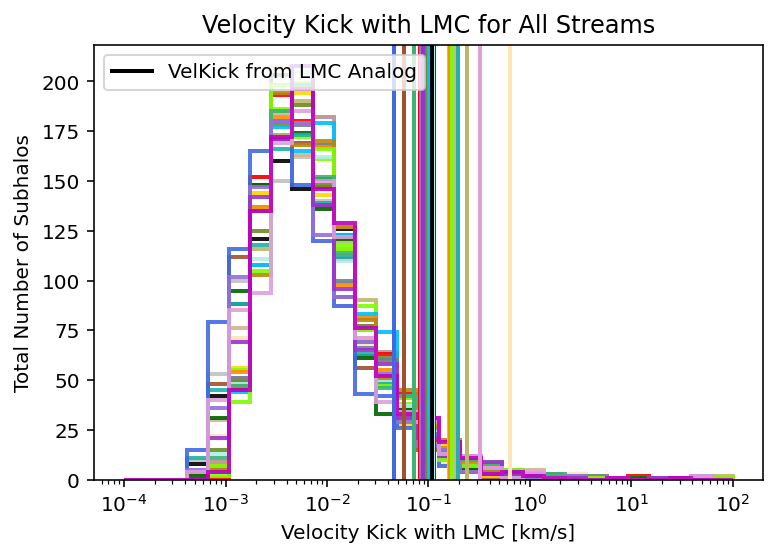

In [27]:
#Calculation of Velocity Kick With LMC
# With the addition of the Plot 
#the straight line shows the velocity kick due to the LMC

colors = ['black', 'silver', 'rosybrown', 'red', 'sienna',
         'tan', 'moccasin', 'gold', 'darkkhaki', 'olivedrab', 
         'chartreuse', 'darkgreen', 'lightseagreen', 'paleturquoise',
         'deepskyblue', 'slategray', 'royalblue', 'darkorange', 'darkgoldenrod',
         'lawngreen', 'mediumseagreen', 'mediumpurple', 'darkorchid', 'plum', 
         'm', 'palevioletred', 'violet', 'c', 'olive', 'lemonchiffon', 'skyblue',
         'indigo']

vel_kick_no_LMC = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
for i in range(len(pb)):    
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) 
    r_min = np.array(pb.iloc[i][1::3])*u.kpc
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun 
    delta_v = 2*G*mass_subh/(r_min*v_rel) 

    delta_v_km_new = delta_v.to(u.km/u.s)
    
    plt.hist(delta_v_km_new.value,bins=np.logspace(-4,2,30), color=colors[i], alpha=0.9,
         histtype='step', linewidth=2)
    plt.axvline(delta_v_km_new[0].value, color=colors[i], linewidth=2) #Vel kick due to LMC
    
    plt.gca().set_xscale('log') 
    vel_kick_temp = np.sqrt(np.sum(delta_v[1:]**2))
    vel_kick_no_LMC[i] = vel_kick_temp

plt.axvline(delta_v_km_new[0].value, color='k', linewidth=2, label='VelKick from LMC Analog')

plt.xlabel('Velocity Kick with LMC [km/s]')
plt.ylabel('Total Number of Subhalos')
plt.title('Velocity Kick with LMC for All Streams')
plt.legend(loc='best')

plt.savefig('Vel_Kick_Histogram_with_LMC/All_Stream_Vel_Kick_With_LMC.png', transparent=False, dpi=200) 


## Adding Info to Streams (the dictionary)

In [28]:
#This data comes from Malhan
r_peri = dict(LMS_1=10.8, Gjoll=8.5, Leiptr=12.3, Hrid=1.1, Pal5=6.9, Orphan=15.6, 
             Gaia_1=8.2, Fimbulthul=2.4, Ylgr=11.5, Fjorm=9.1, Kshir=13.4, Cetus=14.7,
             Svol=5.9, Gunnthra=4.2, Slidr=8.7, M92=3.0, NGC_6397=3.4, NGC_3201=8.5,
             Ophiuchus=3.9, Atlas=11.7, C_7=3.5, C_3=5.7, Palca=10.8, Sylgr=8.7,
             Gaia_6=6.0, Gaia_9=8.7, Gaia_10=4.3, Gaia_12=18.5, Indus=12.6, Jhelum=8.7,
             Phoenix=11.7, NGC5466=4.8, M5=3.4, C_20=20.8, NGC7089=2.9, C_19=9.3,
             Elqui=12.1, Chenab=22.0, AliqaUma=11.6, Phlegethon=5.5, GD_1=14.1)


r_apo = dict(LMS_1=20.6, Gjoll=27.4, Leiptr=45.1, Hrid=22.0, Pal5=15.8, Orphan=41.2, 
             Gaia_1=67.6, Fimbulthul=7.2, Ylgr=20.7, Fjorm=29.1, Kshir=16.0, Cetus=35.9,
             Svol=10.0, Gunnthra=7.2, Slidr=32.3, M92=10.7, NGC_6397=6.4, NGC_3201=30.5,
             Ophiuchus=14.2, Atlas=32.4, C_7=21.0, C_3=10.0, Palca=16.5, Sylgr=24.6,
             Gaia_6=9.5, Gaia_9=20.8, Gaia_10=37.7, Gaia_12=194.3, Indus=18.9, Jhelum=24.5,
             Phoenix=18.1, NGC5466=33.7, M5=24.8, C_20=58.5, NGC7089=14.7, C_19=21.6,
             Elqui=54.0, Chenab=81.0, AliqaUma=31.9, Phlegethon=22.1, GD_1=23.0)


#This data comes from Mateu
length = dict(Gjoll=mwsts['NGC3201-P21'].length.deg, Leiptr=mwsts['Leiptr-I21'].length.deg, 
              Hrid=mwsts['Hrid-I21'].length.deg, Pal5=mwsts['Pal15-M17'].length.deg, #Pal5 has 2
              Gaia_1=mwsts['Gaia-1-I21'].length.deg, Ylgr=mwsts['Ylgr-I21'].length.deg, 
              Fjorm=mwsts['M68-P19'].length.deg, Kshir=mwsts['Kshir-I21'].length.deg, 
              Gunnthra=mwsts['Gunnthra-I21'].length.deg, Slidr=mwsts['Slidr-I21'].length.deg, 
              M92=mwsts['M92-I21'].length.deg, NGC_3201=mwsts['NGC3201-P21'].length.deg,
              Atlas=mwsts['AAU-ATLAS-L21'].length.deg, C_7=mwsts['C-7-I21'].length.deg, 
              Palca=mwsts['Palca-S18'].length.deg, Sylgr=mwsts['Sylgr-I21'].length.deg,
              Gaia_9=mwsts['Gaia-9-I21'].length.deg, Gaia_10=mwsts['Gaia-10-I21'].length.deg, 
              Gaia_12=mwsts['Gaia-12-I21'].length.deg, Indus=mwsts['Indus-S19'].length.deg, 
              Jhelum=mwsts['Jhelum-a-B19'].length.deg, Phoenix=mwsts['Phoenix-S19'].length.deg, #Jhelum has 2
              NGC5466=mwsts['NGC5466-G06'].length.deg, M5=mwsts['M5-G19'].length.deg, 
              C_20='0', C_19=mwsts['C-9-I21'].length.deg,
              Elqui=mwsts['Elqui-S19'].length.deg, AliqaUma=mwsts['AAU-AliqaUma-L21'].length.deg, 
              Phlegethon=mwsts['Phlegethon-I21'].length.deg, GD_1=mwsts['GD-1-I21'].length.deg)

In [29]:
streams_copy_new_updated = pd.read_csv('Streams_data_with_velkicks_and_len.csv')
streams_copy_new_updated = streams_copy_new_updated.drop("Unnamed: 0",axis=1)
streams_copy_new_updated

Stream      ra    dec  distance  pm_ra_cosdec  pm_dec  \
0        Gjoll   82.10 -13.95      3.26         23.58  -23.70   
1       Leiptr   89.11 -28.37      7.39         10.59   -9.90   
2         Hrid  280.51  33.30      2.75         -5.88   20.08   
3         Pal5  229.65   0.26     20.16         -2.75   -2.68   
4       Gaia_1  190.96  -9.16      5.57        -14.39  -19.72   
5         Ylgr  173.82 -22.31      9.72         -0.44   -7.65   
6        Fjorm  251.89  65.38      6.42          3.92    3.10   
7        Kshir  205.88  67.25      9.57         -7.67   -3.92   
8     Gunnthra  284.22 -73.49      2.83        -15.83  -24.04   
9        Slidr  160.05  10.22      2.99        -24.60   -6.65   
10         M92  259.89  43.08      8.94         -5.15   -0.63   
11    NGC_3201  152.46 -46.32      4.99          8.87   -2.22   
12       Atlas   25.04 -29.81     19.93          0.04   -0.89   
13         C_7  287.15 -50.17      6.77        -13.79  -12.38   
14       Palca   36.57 -36.15     12.31          0.90   -0.23   
15       Sylgr  179.68  -2.44      3.77        -13.98  -12.90   
16      Gaia_9  233.27  60.42      4.68        -12.49    6.37   
17     Gaia_10  161.47  15.17     13.32         -4.14   -3.15   
18     Gaia_12   41.05  16.45     15.71          5.84   -5.66   
19       Indus  340.12 -60.58     14.96          3.59   -4.89   
20      Jhelum  351.95 -51.74     11.39          7.23   -4.37   
21     Phoenix   23.96 -50.01     16.80          2.72   -0.07   
22     NGC5466  214.41  26.84     14.09         -5.64   -0.72   
23          M5  206.96  13.50      7.44          3.50   -8.76   
24        C_20  359.81   8.63     18.11         -0.58    1.44   
25        C_19  355.28  28.82     18.04          1.25   -2.74   
26       Elqui   19.77 -42.36     51.41          0.33   -0.49   
27    AliqaUma   34.08 -33.97     21.48          0.24   -0.79   
28  Phlegethon  319.89 -32.07      3.29         -3.97  -37.66   
29        GD_1  160.02  45.90      8.06         -6.75  -10.88   

    radial_velocity  r_apo  r_peri    vel_kick  vel_kick_no_LMC  length [deg]  
0             78.73   27.4     8.5   63.359047        63.358755    136.860661  
1            194.22   45.1    12.3   67.366523        67.366434     70.370056  
2           -238.77   22.0     1.1   90.097880        90.097816     61.730058  
3            -57.03   15.8     6.9  102.617291       102.617258      1.469166  
4            214.91   67.6     8.2   89.733282        89.733264     34.570252  
5            317.86   20.7    11.5   65.341869        65.341624     44.786315  
6            -25.37   29.1     9.1   78.714957        78.712428    133.548763  
7           -249.88   16.0    13.4  102.677873       102.677825     17.393372  
8            132.26    7.2     4.2  100.187710       100.187418     20.200567  
9            -87.98   32.3     8.7  175.563954       175.563930     33.614165  
10          -140.66   10.7     3.0   86.863070        86.862926     21.081884  
11           489.63   30.5     8.5         NaN              NaN    136.860661  
12           -85.65   32.4    11.7   43.887795        43.887649     23.561687  
13            55.05   21.0     3.5   55.145450        55.145099     24.933249  
14           106.32   16.5    10.8         NaN              NaN     57.321494  
15          -184.80   24.6     8.7  180.543201       180.543167     26.164218  
16          -359.86   20.8     8.7  223.595654       223.595631     22.030526  
17           289.62   37.7     4.3   99.160256        99.160230     17.245351  
18          -303.83  194.3    18.5   62.214269        62.214252     13.747912  
19           -49.15   18.9    12.6   75.822722        75.822548     18.222537  
20            -1.29   24.5     8.7  154.092106       154.092012     30.000486  
21            45.92   18.1    11.7   74.867863        74.867667     11.768597  
22            95.04   33.7     4.8  114.061479       114.061456     45.304151  
23           -42.97   24.8     3.4   64.649252        64.649197     41.3

## Covariance

In [30]:
corr_apo_peri = np.corrcoef(streams_copy_new_updated['r_apo'], streams_copy_new_updated['r_peri'])
corr_peri_velkick = np.corrcoef(streams_copy_new_updated['r_peri'], streams_copy_new_updated['vel_kick'])
corr_apo_velkick = np.corrcoef(streams_copy_new_updated['r_apo'], streams_copy_new_updated['vel_kick'])
corr_peri_velkicknoLMC = np.corrcoef(streams_copy_new_updated['r_peri'], streams_copy_new_updated['vel_kick_no_LMC'])

print(corr_apo_peri, corr_peri_velkick, corr_apo_velkick, corr_peri_velkicknoLMC)

[[1.         0.49676505]
 [0.49676505 1.        ]] [[ 1. nan]
 [nan nan]] [[ 1. nan]
 [nan nan]] [[ 1. nan]
 [nan nan]]


### Emphasizing Streams with Largest Vel Kicks (this only consideres vel kick during closest encounter)

Text(0.5, 1.0, 'Absolute Difference in Velocity Kicks Per Stream')

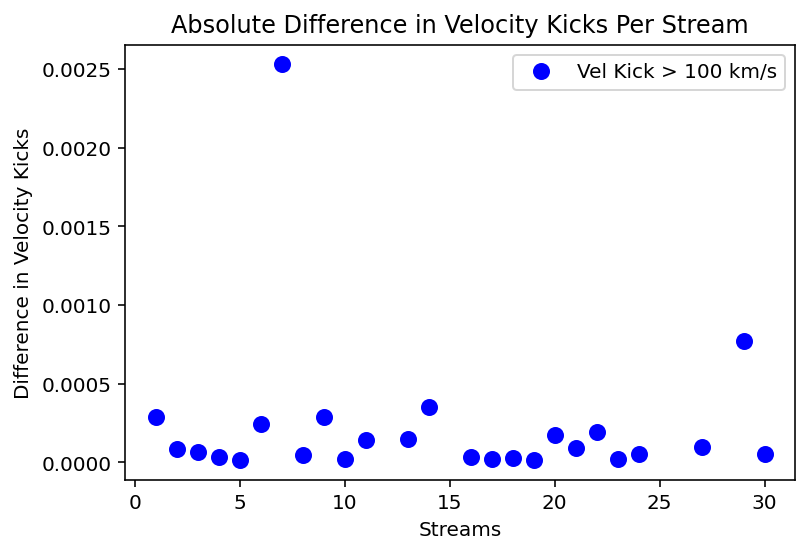

In [31]:
diff_velkicks = np.abs(streams_copy_new_updated['vel_kick_no_LMC'] - streams_copy_new_updated['vel_kick'])

x = np.linspace(1,30,30)
plt.figure()
plt.plot(x, diff_velkicks, '.b', ms=15)
plt.plot(x[diff_velkicks>100], diff_velkicks[diff_velkicks>100], '.', 
         color= 'blue', ms=15, label='Vel Kick > 100 km/s')

# feed back from lmc generically heats up the streams  

plt.xlabel('Streams')
plt.ylabel('Difference in Velocity Kicks')
plt.legend(loc='best')
plt.title('Absolute Difference in Velocity Kicks Per Stream')

### Smallest Distance on y axis and apocenter on x axis for all streams

<ipython-input-32-92d0b2a8bd2d>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


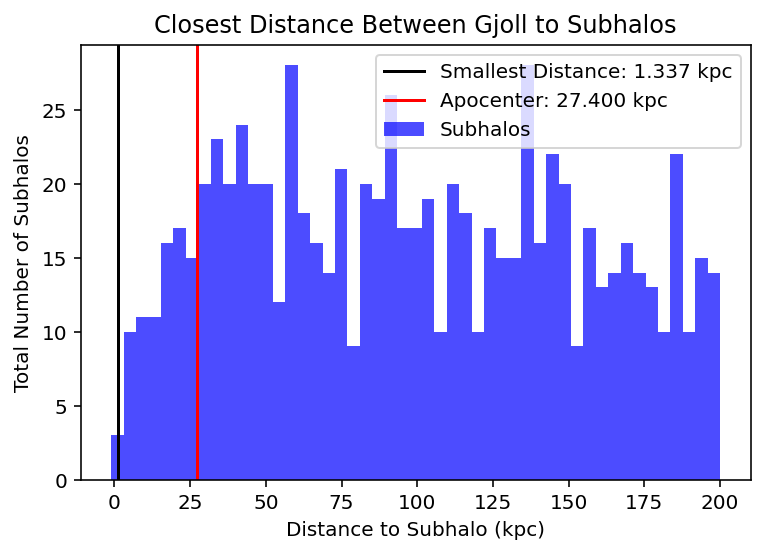

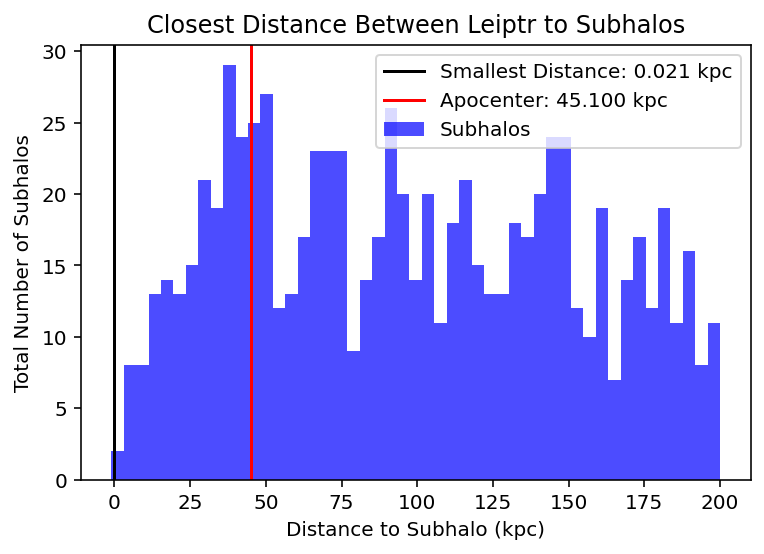

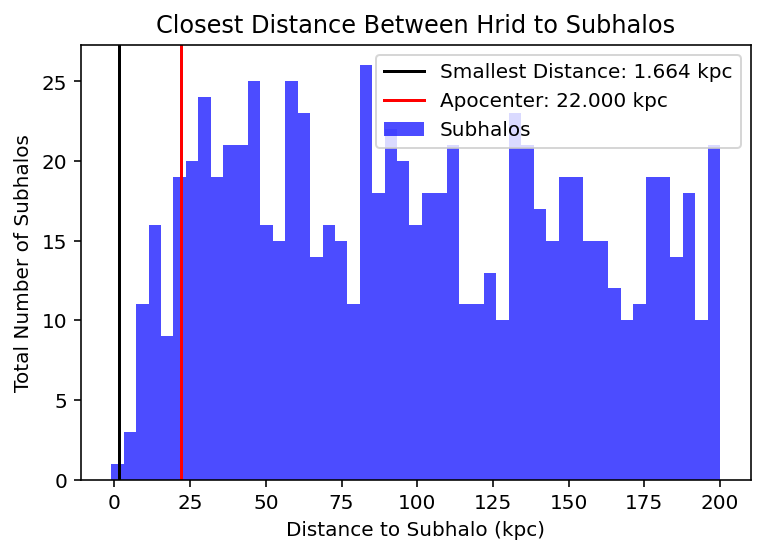

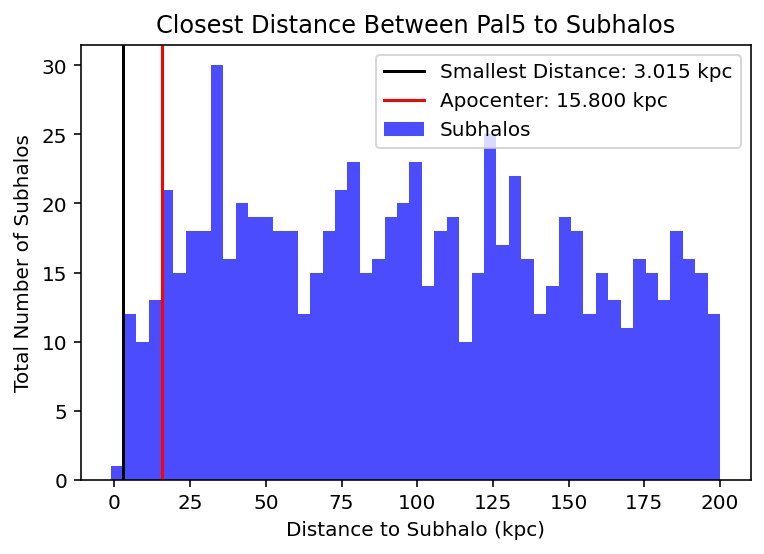

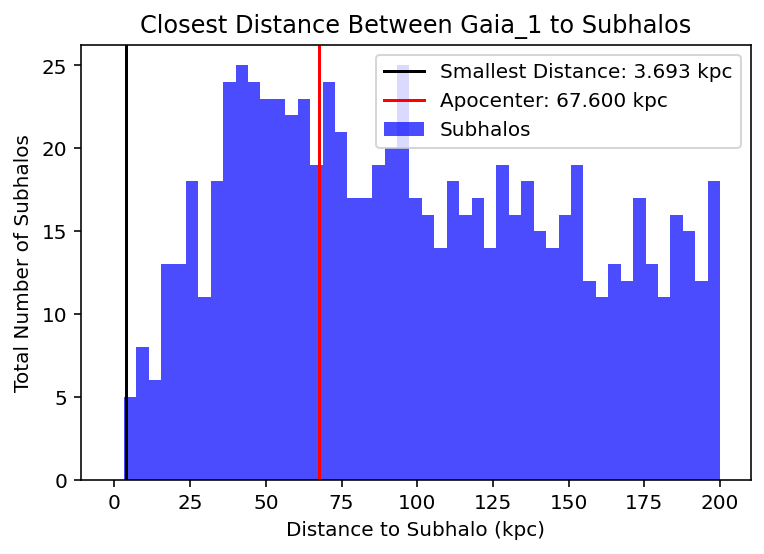

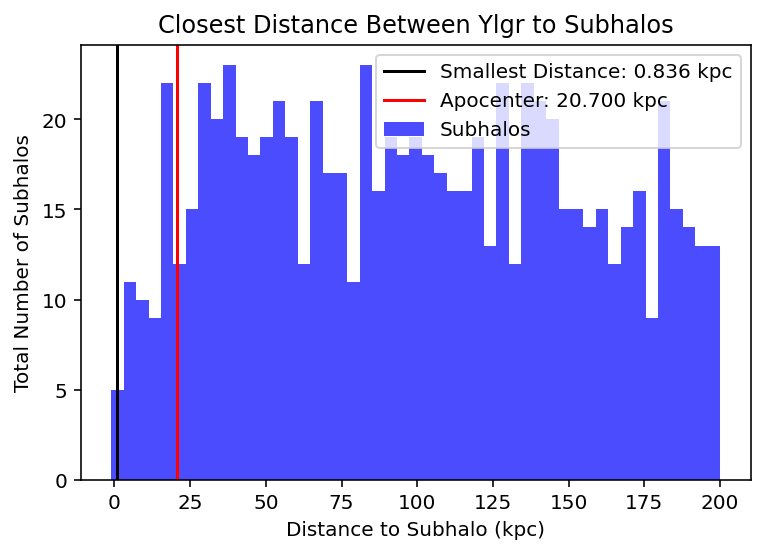

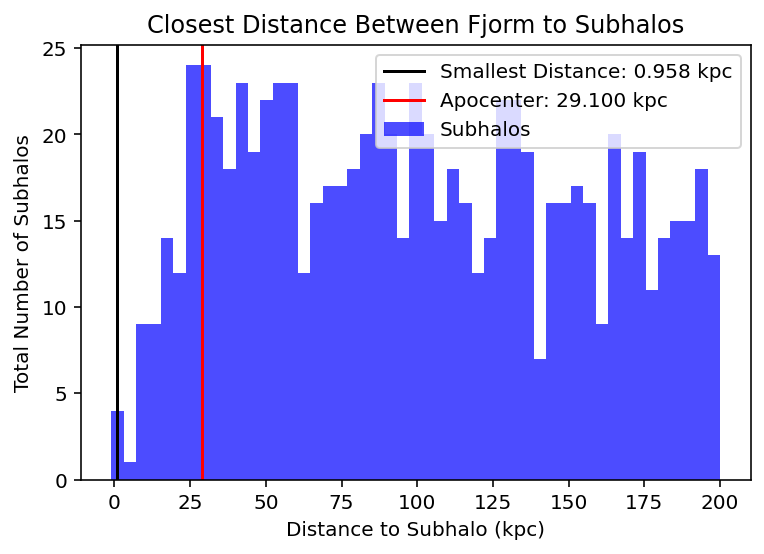

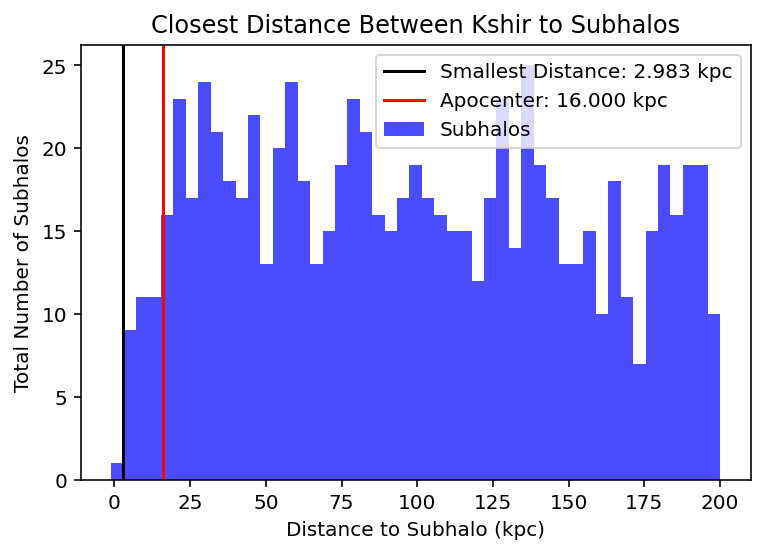

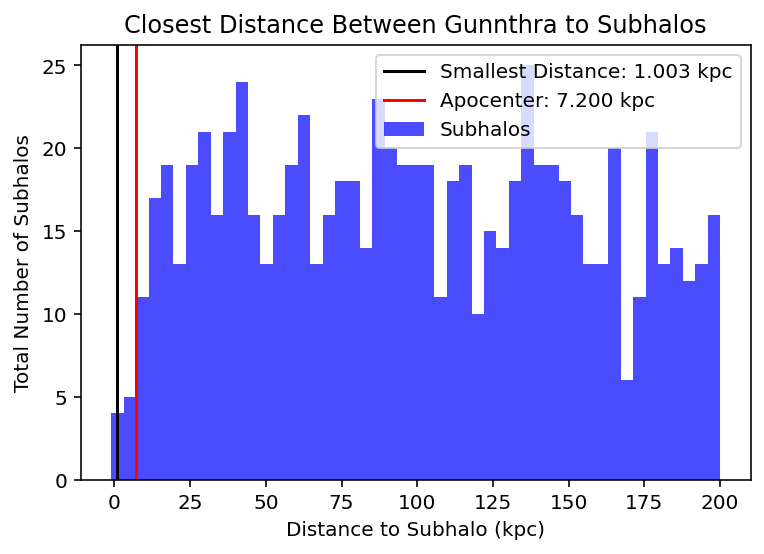

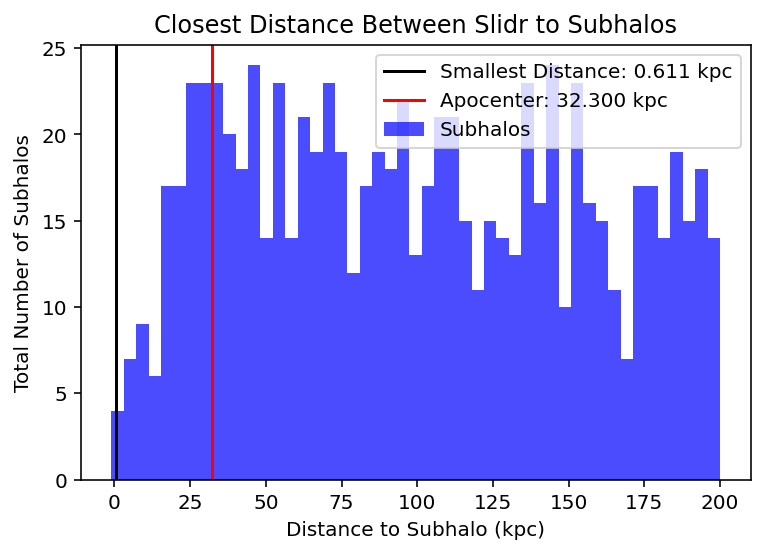

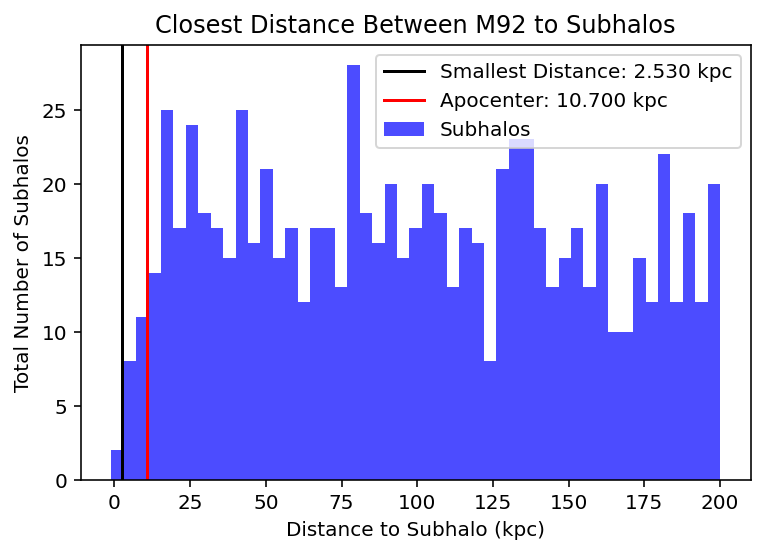

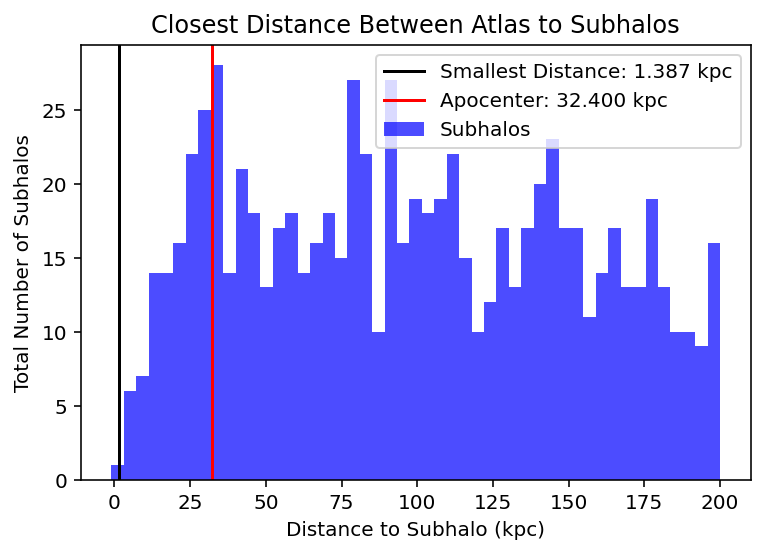

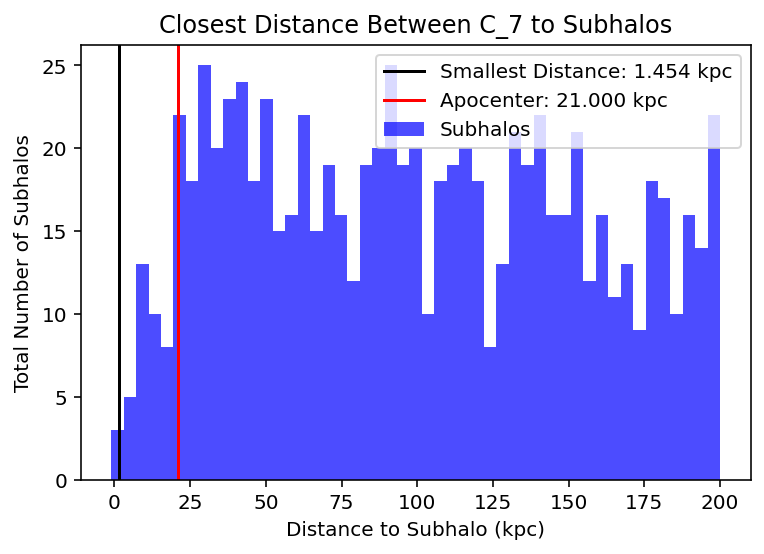

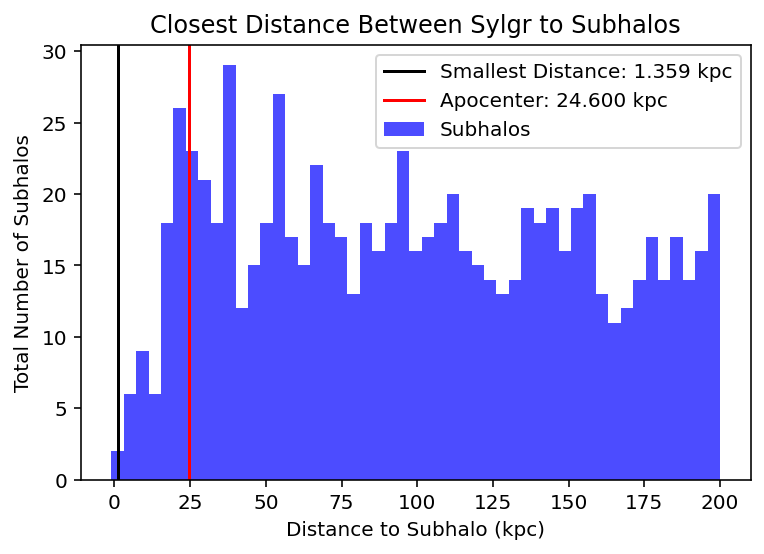

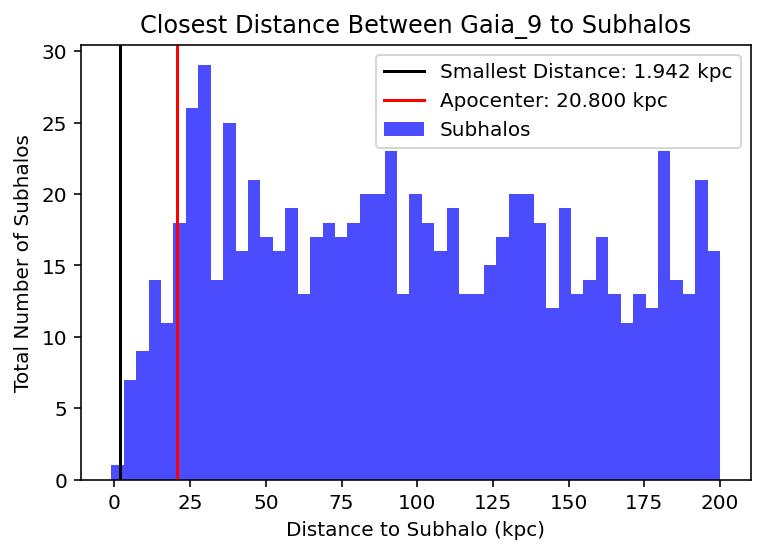

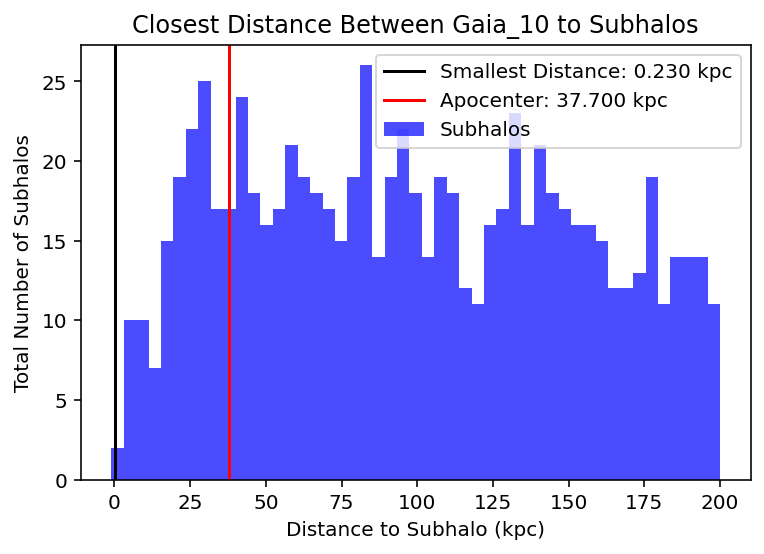

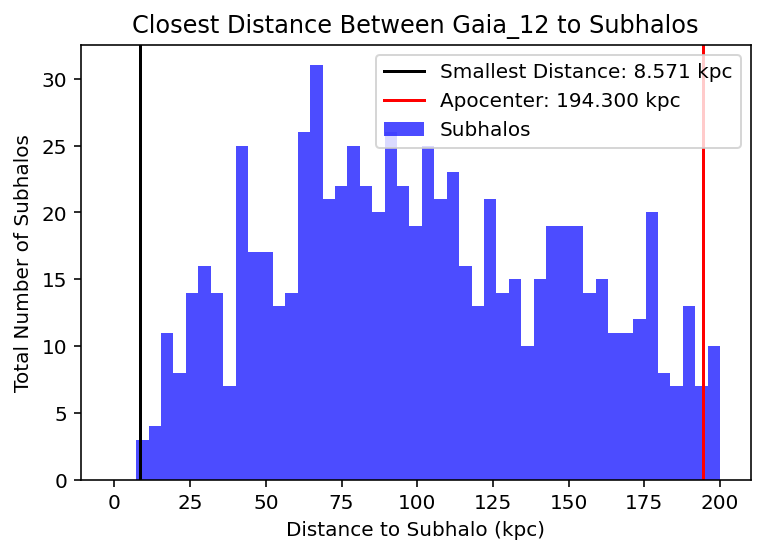

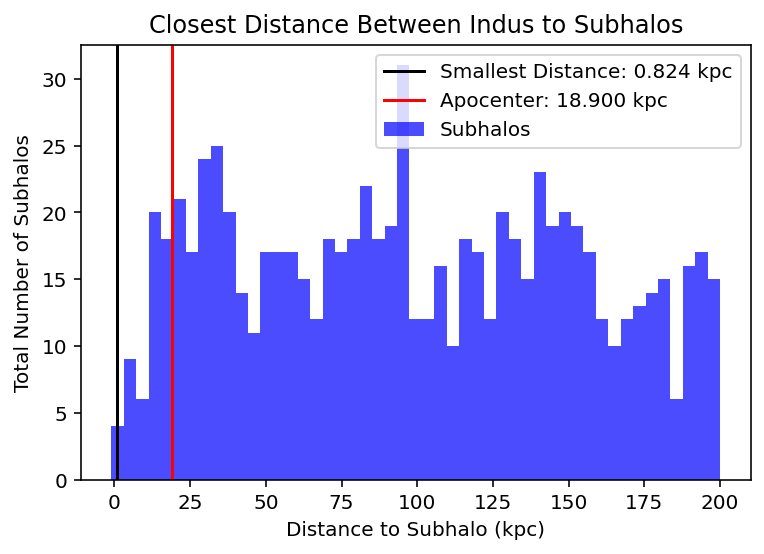

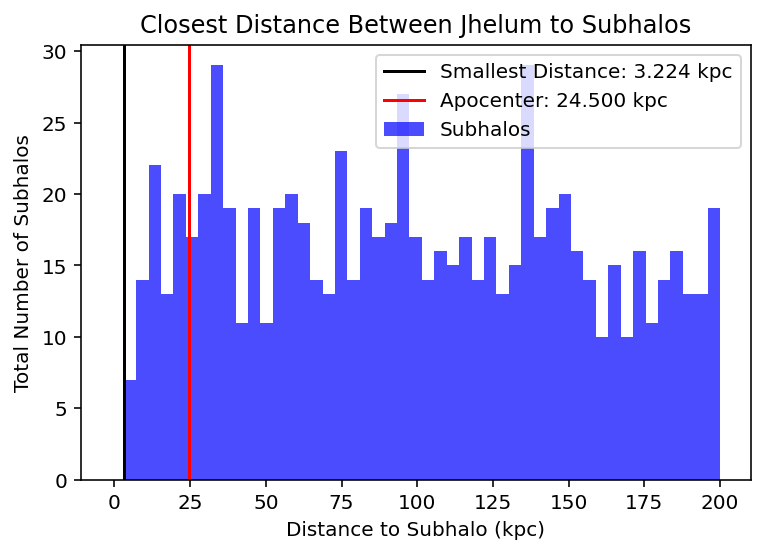

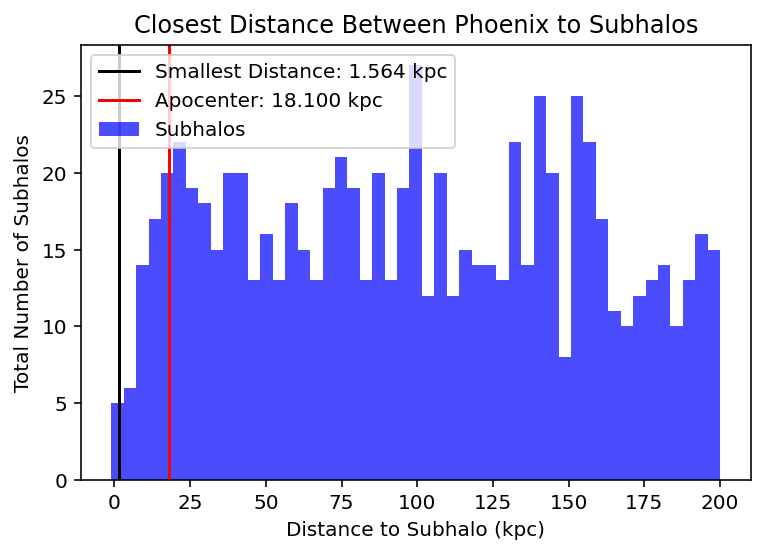

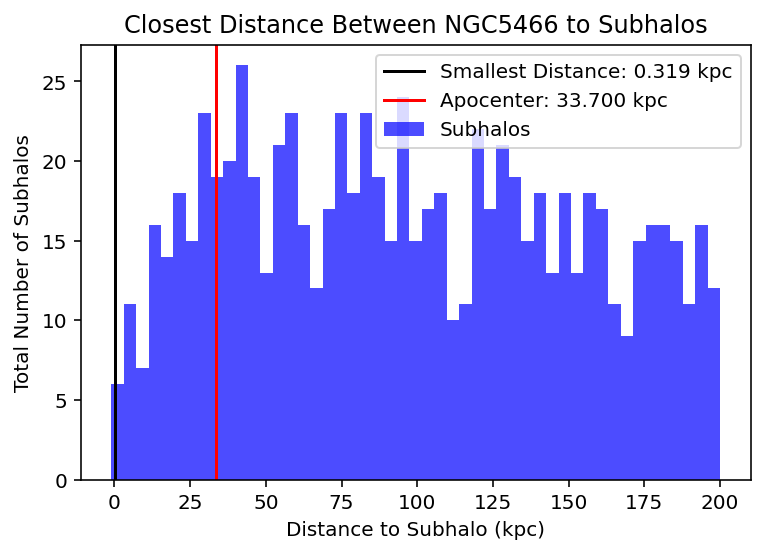

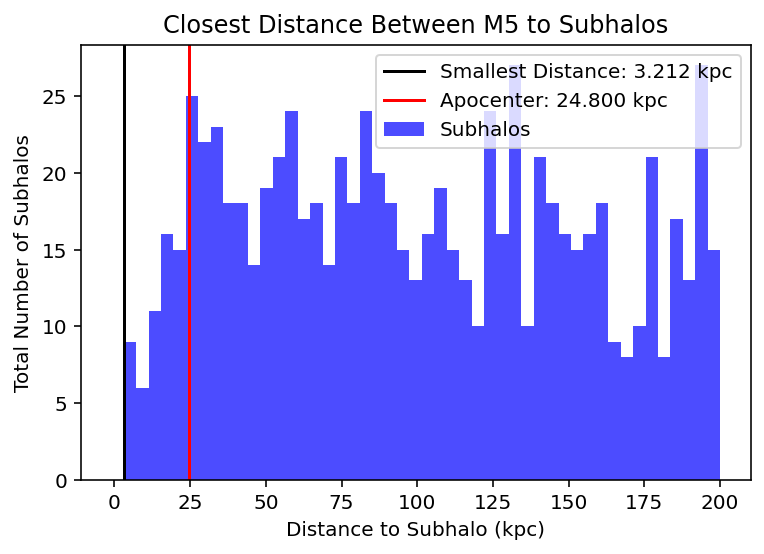

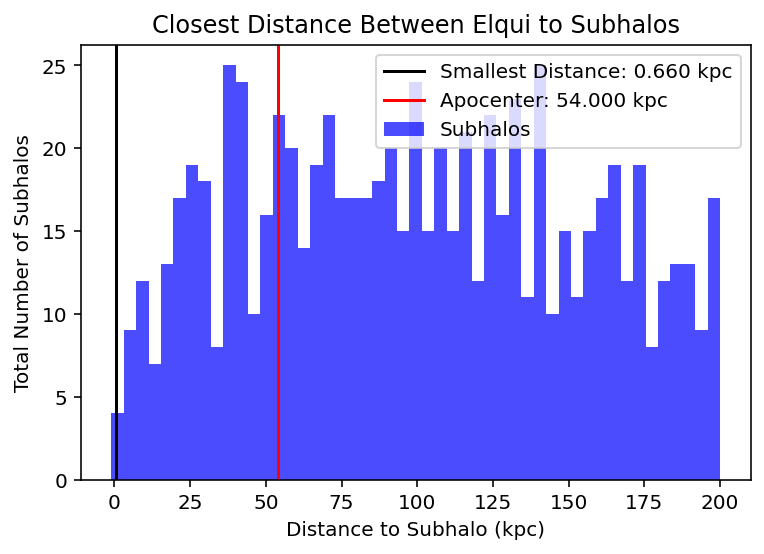

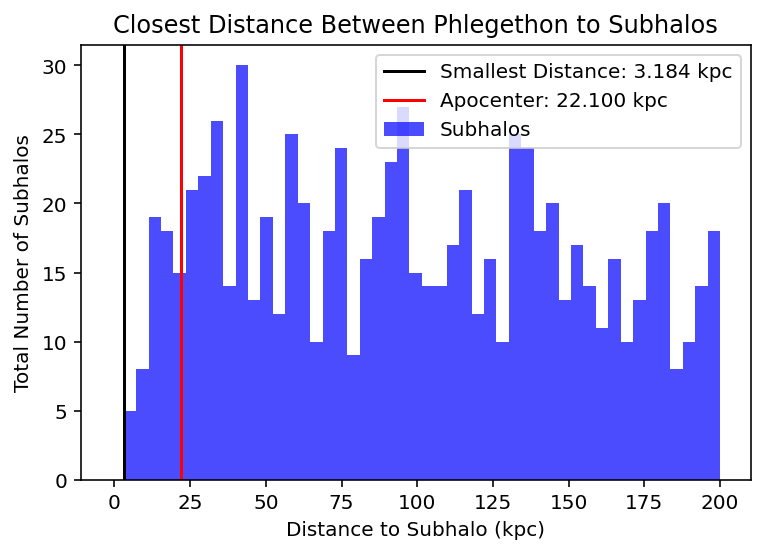

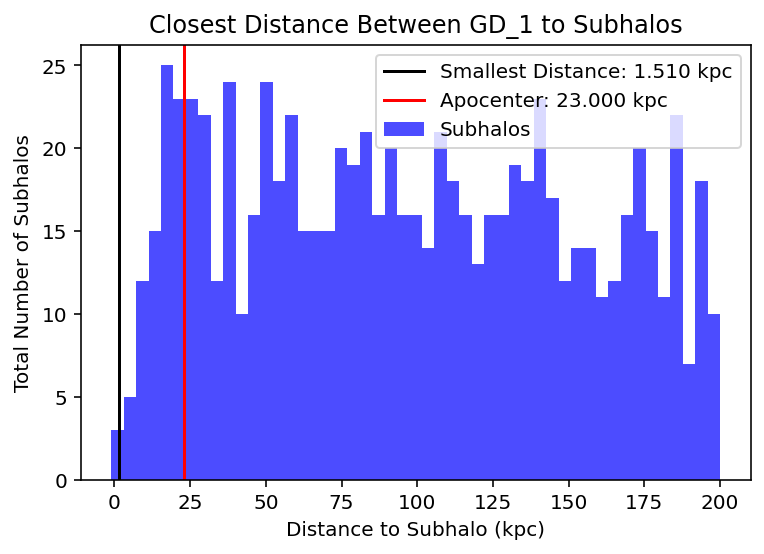

In [32]:
#Creates Histograms for All Streams 
#Include both Apocenter and Pericenter
for i in range(len(pb)):
    plt.figure()
    plt.hist(pb.iloc[i][1::3], bins=np.linspace(-1,200,50), color='blue', alpha=0.7, label='Subhalos');  
    plt.axvline(min(pb.iloc[i][1::3]), color='black', label = 'Smallest Distance: {:.3f} kpc'.format(min(pb.iloc[i][1::3])))
    for key in range(len(r_apo.keys())):
        if pb.iloc[i][0] == list(r_apo.keys())[key]:
            plt.axvline(r_apo[pb.iloc[i][0]], color='red', label = 'Apocenter: {:.3f} kpc'.format(r_apo[pb.iloc[i][0]]))
    plt.title('Closest Distance Between {:s} to Subhalos'.format(pb.iloc[i][0]))
    plt.xlabel('Distance to Subhalo (kpc)')
    plt.ylabel('Total Number of Subhalos')
    plt.legend(loc='best')
    plt.savefig('Stream_to_Subhalo_Histograms/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200)
    
    

## Old Paper Plots

### Streams Distance to Galactic Center

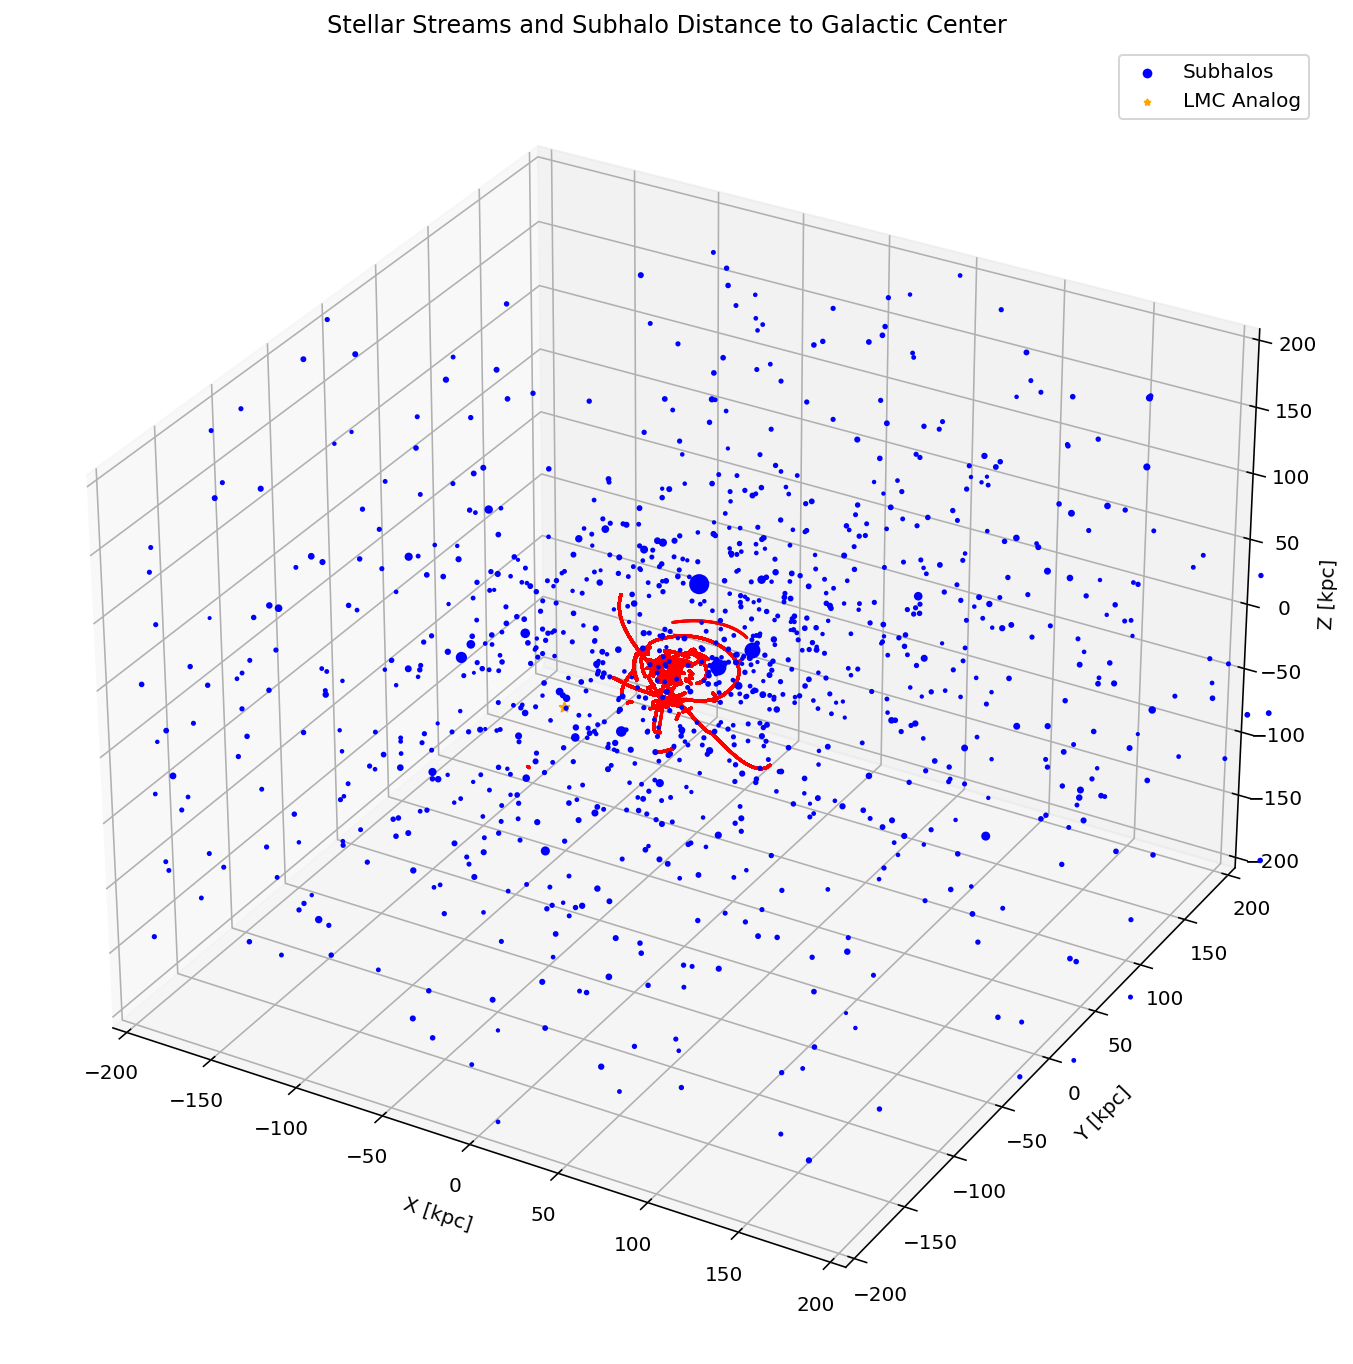

In [33]:
#%matplotlib notebook
#enable notebook for interactive
fig = plt.figure(1,figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
for st in mwsts.keys():
    ax.scatter3D(mwsts[st].track.transform_to(gsr).x,mwsts[st].track.transform_to(gsr).y,
                 mwsts[st].track.transform_to(gsr).z,
                 marker='.', color='red', s=1, c=None, alpha=1)
ax.scatter3D(trot['x'][1:], trot['y'][1:], trot['z'][1:], color='blue', label='Subhalos', s=10*(trot['rs'][1:]), alpha=1)    
ax.scatter3D(trot['x'][0], trot['y'][0], trot['z'][0], marker='*', color='orange', s=50*trot['rs'][0], 
             label='LMC Analog', alpha=1)
ax.set_xlim3d(-200, 200)
ax.set_ylim3d(-200, 200)
ax.set_zlim3d(-200, 200)
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
plt.legend(loc='best', markerscale=0.6)
plt.title('Stellar Streams and Subhalo Distance to Galactic Center')
plt.savefig('Stellar_Streams_and_Subhalo_Distance_to_Galactic_Center.png', transparent=False, dpi=200)
                 

### Orbit of Gaia-1 in Past 3Gyrs

In [34]:
#Orbit time step for Gaia-1

# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

name = 'Gaia-1-I21'
c = coord.SkyCoord(ra=190.96*u.deg, dec=-9.16*u.deg, distance=5.57*u.kpc, pm_ra_cosdec=-14.39*u.mas/u.yr,
                  pm_dec=-19.72*u.mas/u.yr, radial_velocity=214.91*u.km/u.s, frame='icrs')

w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

dt = 0.2*u.Myr
Nstep_foward = list(Nstep_foward_dict.values())[4]
orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
Nstep = list(Nstep_represent_dict.values())[4]
orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
orbit_sky = orbit.to_coord_frame(coord.ICRS())

#LONG ORBIT: going backwards in time
Nstep_long = 3000
orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

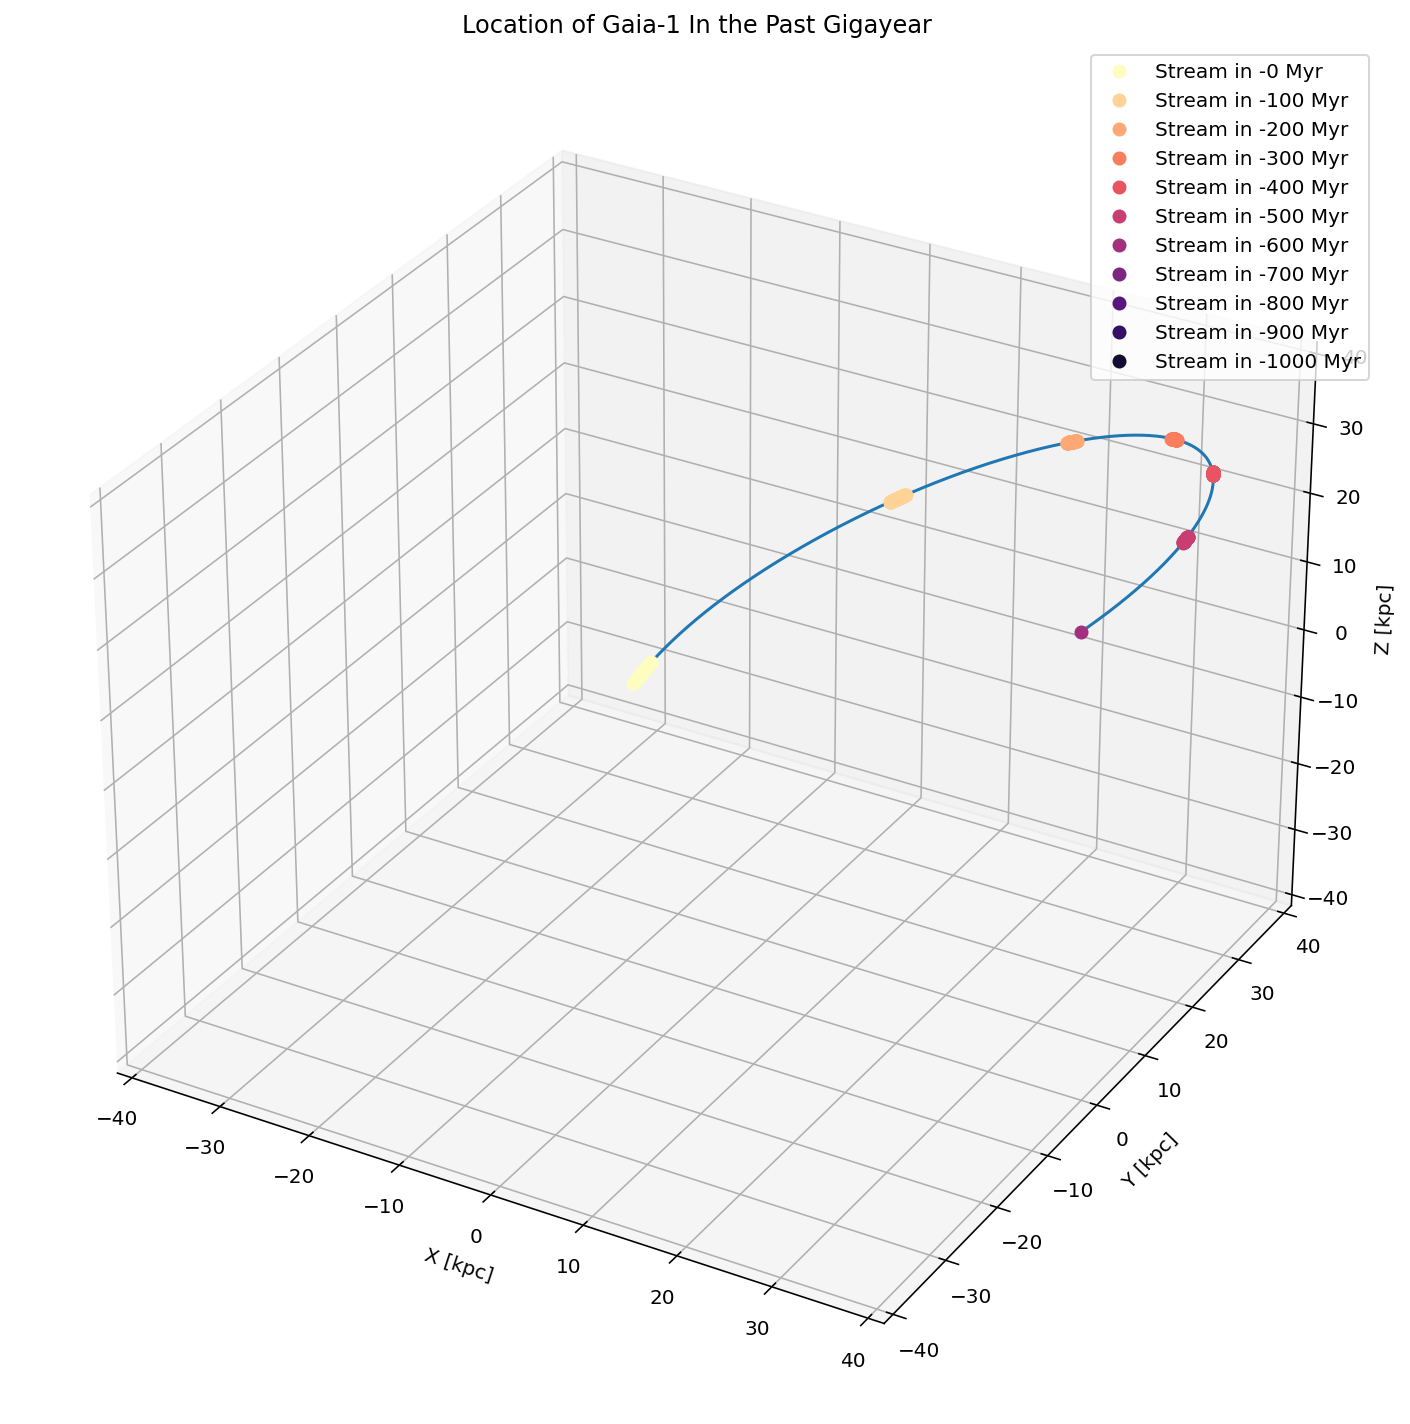

In [35]:
#%matplotlib notebook
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.axes(projection='3d')

ax.plot(orbit_long.pos.x, orbit_long.pos.y, orbit_long.pos.z, '-')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')

#orbital segments of past positions of the stream
times = np.linspace(0,1000,11)*u.Myr

colors = [mpl.cm.magma_r(x/11) for x in range(11)] #creating a list of 11 colors 

for i, tm in enumerate(times):
    t = int((tm/dt).decompose())
    ax.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.y[t:t+Nstep],
             orbit_long.pos.z[t:t+Nstep], 'o', lw=8, color=colors[i],
             label='Stream in {:g}'.format(-tm))
plt.legend(loc='best')
ax.set_xlim(-40,40)
ax.set_ylim(-40,40)
ax.set_zlim(-40,40)
plt.title('Location of Gaia-1 In the Past Gigayear')
plt.tight_layout()
plt.savefig('Location of Stellar Stream in the Past Gigayear', transparent=True)


### Vel Kick Contribution on Gaia-1

In [36]:
#Calculating Individual Velocity Kicks Cause by Subhalos to Gaia-1 at  
i=4 #Gaia-1 is Index 4
G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest distance between subhalos and stream 
v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel. between stream and subhalos 
mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
delta_v = 2*G*mass_subh/(r_min*v_rel)
delta_v_km_new_Gaia1 = delta_v.to(u.km/u.s)
np.array(delta_v_km_new_Gaia1.value)

array([0.05719638, 0.07502857, 0.02882779, ..., 0.0020748 , 0.00306556,
       0.00139514])

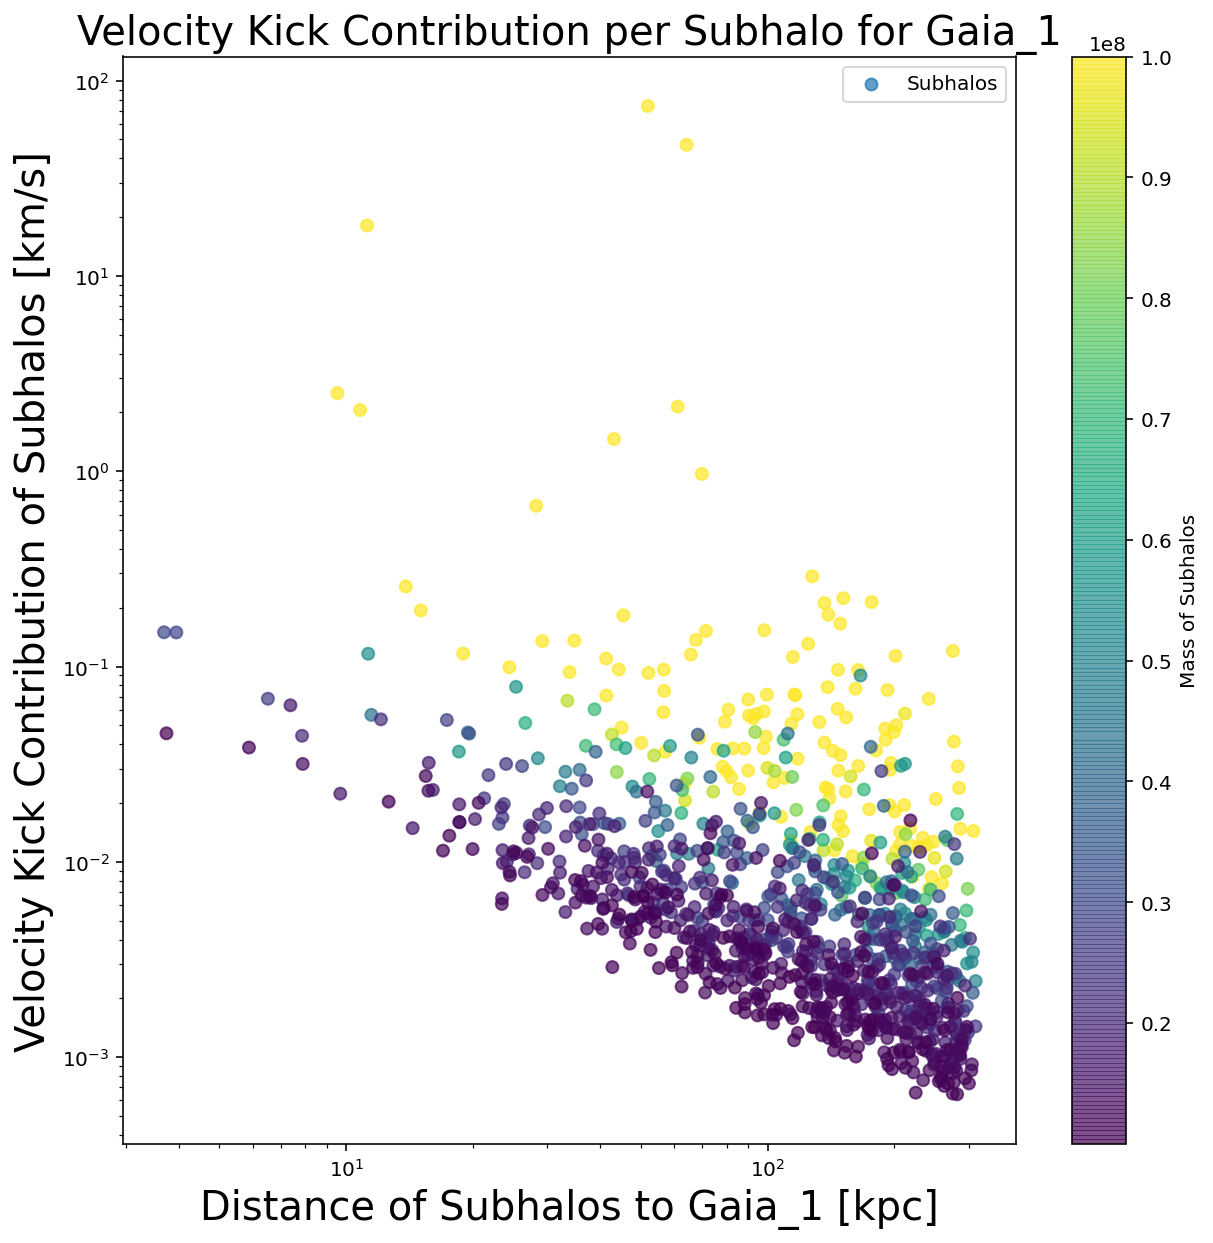

In [37]:
#want to have distance to gaia-1 vs velocity kick contribution of subhalo
plt.figure(figsize=(10,10))
plt.scatter(np.array(pb.iloc[4][1::3]), np.array(delta_v_km_new_Gaia1.value),
         c=np.array(ts[ind_massive]['mvir']), vmax=1e+8,
         alpha=0.7, label='Subhalos') #Darker color -> lighter; lighter color -> heavier

plt.xlabel('Distance of Subhalos to Gaia_1 [kpc]', fontsize=20)
plt.ylabel('Velocity Kick Contribution of Subhalos [km/s]', fontsize=20)
plt.title('Velocity Kick Contribution per Subhalo for Gaia_1', fontsize=20)
plt.colorbar(label='Mass of Subhalos', orientation='vertical')
plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')
plt.savefig('Velocity_Kick_Contribution_per_Subhalo_for_Gaia_1.png', transparent=False, dpi=200)

### Calculating Vel Kick Larger than Threshold and Plotting

In [38]:
#Obtaining Counts of Vel. Kicks Larger than Threshold 
vel_kick = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
total_larger_1 = np.empty(len(pb))
total_larger_half = np.empty(len(pb))
total_larger_tenth = np.empty(len(pb))


for i in range(len(pb)):
     #Calculating Velocity Kick 
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
    r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest distance between subhalos and stream 
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel btwn stream and subhalos 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
    delta_v = 2*G*mass_subh/(r_min*v_rel) #start with this one 
    delta_v = delta_v[1:] 
    total_larger_1[i] = np.count_nonzero(delta_v.to(u.km/u.s).value>1) #getting how many have >1km/s vel kick
    total_larger_half[i] = np.count_nonzero(delta_v.to(u.km/u.s).value>0.5) #getting how many have >0.5km/s vel kick
    total_larger_tenth[i] = np.count_nonzero(delta_v.to(u.km/u.s).value>0.1)
    vel_kick_temp = np.sqrt(np.sum(delta_v**2))
    vel_kick[i] = vel_kick_temp
vel_kick.to(u.km/u.s)


<Quantity [ 63.35875549,  67.36643433,  90.09781626, 102.61725819,
            89.73326405,  65.34162421,  78.71242773, 102.67782494,
           100.18741781, 175.56392951,  86.86292584,  43.88764864,
            55.14509945, 180.54316657, 223.59563098,  99.16023044,
            62.21425225,  75.82254778, 154.09201242,  74.86766709,
           114.06145619,  64.64919666,  39.23580273,  65.67625076,
           114.95811251] km / s>

In [39]:
#Obtaining Values with no Nan
ind_finite = np.isfinite(streams_copy_new_updated['vel_kick'])

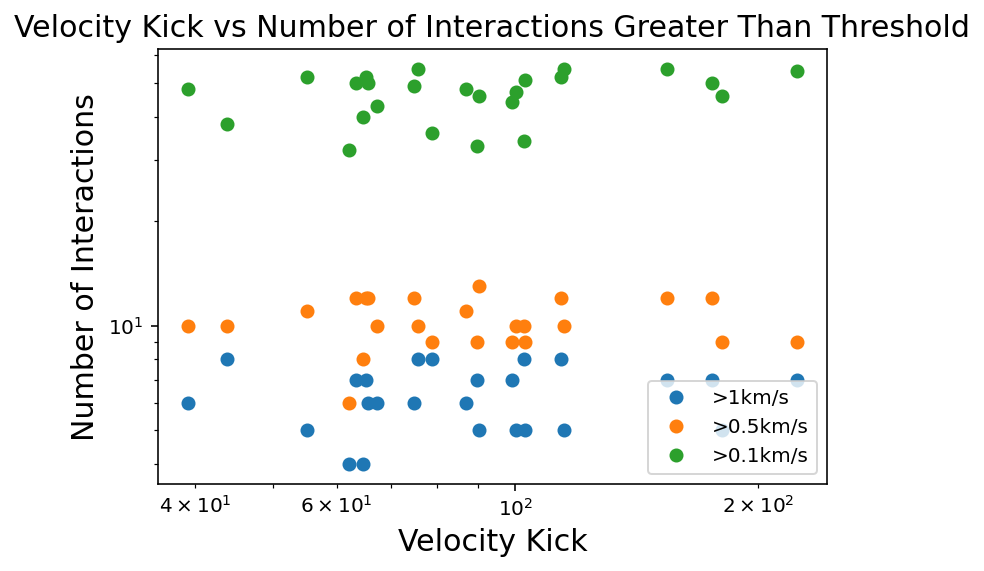

In [40]:
#%matplotlib inline
plt.figure()
plt.plot(streams_copy_new_updated['vel_kick'][ind_finite], total_larger_1, 'o' , label = '>1km/s')
plt.plot(streams_copy_new_updated['vel_kick'][ind_finite], total_larger_half, 'o',label = '>0.5km/s')
plt.plot(streams_copy_new_updated['vel_kick'][ind_finite], total_larger_tenth, 'o',  label = '>0.1km/s')
plt.xlabel('Velocity Kick', fontsize=15)
plt.ylabel('Number of Interactions', fontsize=15)
plt.title('Velocity Kick vs Number of Interactions Greater Than Threshold', fontsize=15)
plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')

#Create len of stream vs same y axis 

### Plotting Length vs Apocenter & Length vs Num of Kicks 

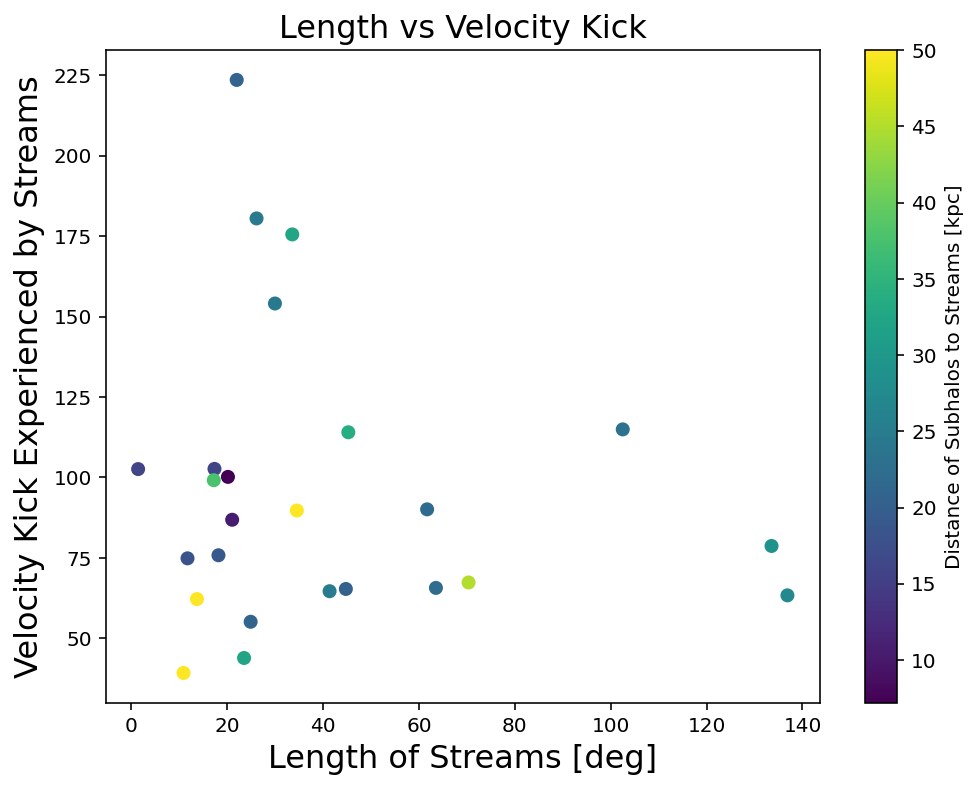

In [41]:
#X - axis apocenter & Y - axis Number of streams that give a velocity larger than 1 km/s - detectable impacts  (scatter plot)
plt.figure(figsize=(8,6))
plt.scatter(streams_copy_new_updated['length [deg]'][ind_finite], np.array(vel_kick_no_LMC.to(u.km/u.s)), 
            c = streams_copy_new_updated['r_apo'][ind_finite], vmax=50)

plt.colorbar(label='Distance of Subhalos to Streams [kpc]', orientation='vertical')
plt.xlabel('Length of Streams [deg]', fontsize=16)
plt.ylabel('Velocity Kick Experienced by Streams', fontsize=16) #No LMC Analog
plt.title('Length vs Velocity Kick', fontsize=16)
plt.show()



### Plotting Velocity Kick vs Subhalo Mass, color coded by closest distance

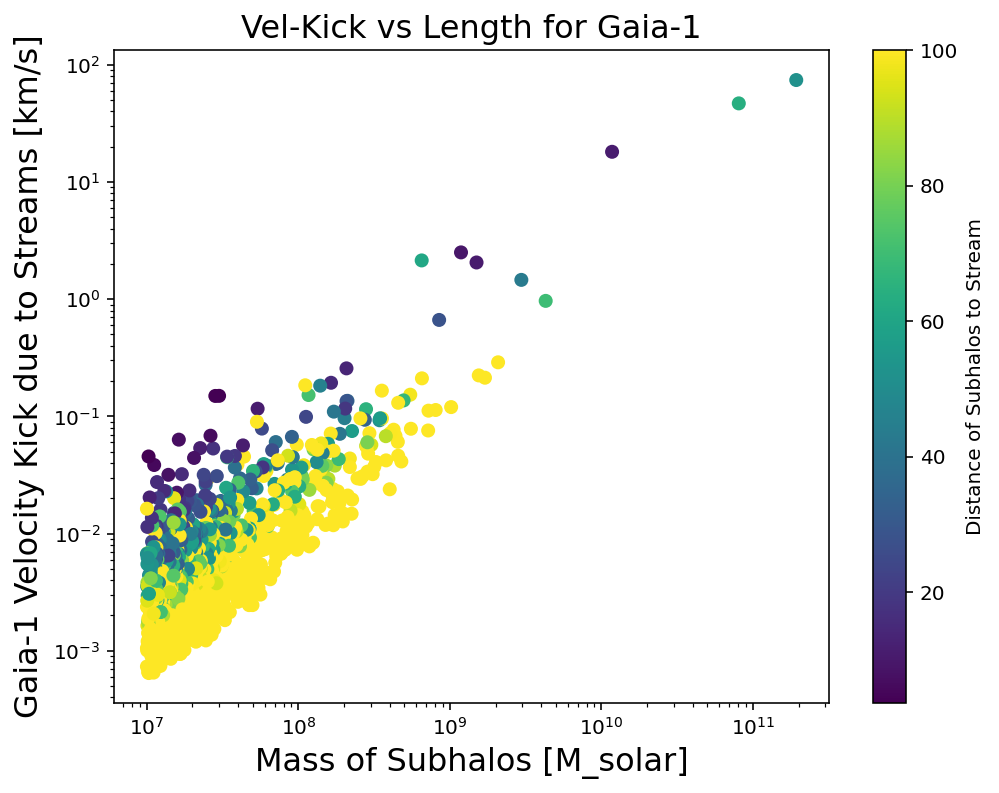

In [42]:
plt.figure(figsize=(8,6))
plt.scatter(ts[ind_massive]['mvir']*u.Msun, delta_v_km_new_Gaia1,
            c = pb.iloc[4][1::3], vmax=100)
#Darker color -> closer; lighter -> further away
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass of Subhalos [M_solar]', fontsize=16)
plt.ylabel('Gaia-1 Velocity Kick due to Streams [km/s]', fontsize=16)
plt.title('Vel-Kick vs Length for Gaia-1', fontsize=16)
plt.colorbar(label='Distance of Subhalos to Stream', orientation='vertical')
plt.show()
#Closer subhalos have a smaller mass 


# Figures for Paper

## Figure 1

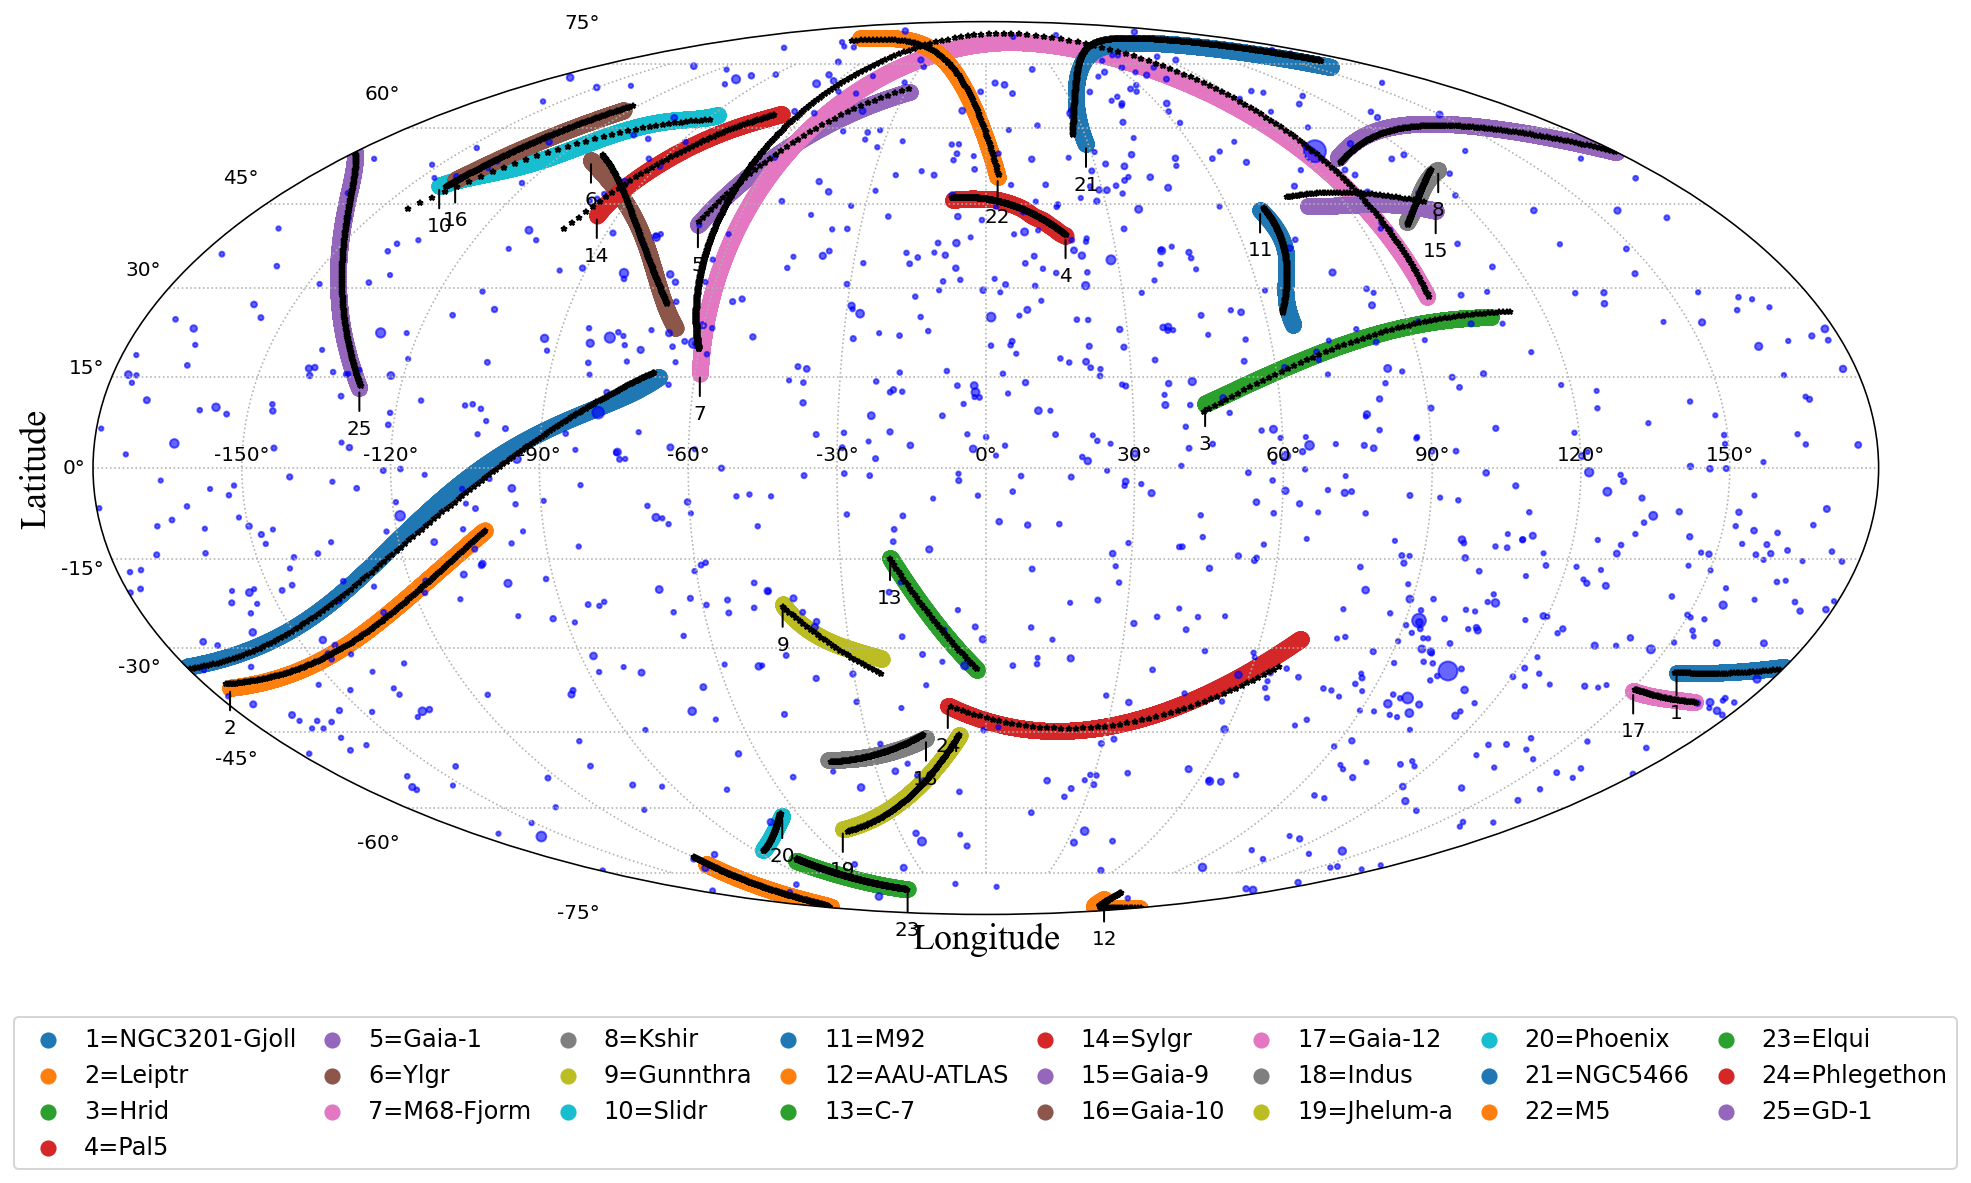

In [44]:
#This is very similar to Week 6 

c = coord.Galactocentric(x=trot['x']*u.kpc, y=trot['y']*u.kpc, z=trot['z']*u.kpc)
c_eq = c.transform_to(coord.ICRS)
cgal = c_eq.transform_to(coord.Galactic)

fig = plt.figure(1,figsize=(16,11))
ax = fig.add_subplot(111, projection='mollweide')
ind_massive_temp = (trot['mvir'] > 10**7) 

counter = 1

#Plotting the stellar streams from Mateu
for i in range(len(names)):
    if ((list(names.values())[i] != 'None') & (list(Nstep_foward_dict.values())[i] != 'None') 
                                            & (list(Nstep_foward_dict.values())[i] !='Unknown')):
        ax.scatter(mwsts[list(names.values())[i]].track.galactic.l.wrap_at(180*u.deg).rad, 
                   mwsts[list(names.values())[i]].track.galactic.b.rad, marker='.', s=200, 
                    label="{ID:.0f}={Name}".format(ID=counter,
                              Name=mwsts[list(names.values())[i]].stream_name))
        xo = mwsts[list(names.values())[i]].end_points.galactic.l.wrap_at(180*u.deg)[0].rad
        yo = mwsts[list(names.values())[i]].end_points.galactic.b[0].rad  
        ax.annotate(counter, xy=(xo,yo),
              xycoords='data', color = 'k',
              arrowprops=dict(arrowstyle="-",color='k'),
              horizontalalignment='center', verticalalignment='center', 
              xytext=(0,-20),textcoords='offset points')
        counter+=1


#Plotting the stellar streams from Malhan
for i in range(len(names)):
    if ((list(names.values())[i] != 'None') & (type(list(Nstep_foward_dict.values())[i]) != str)):       
        
        dt = 0.2*u.Myr
        c = coord.SkyCoord(ra=streams.iloc[i][1]*u.deg, dec=streams.iloc[i][2]*u.deg, distance=streams.iloc[i][3]*u.kpc, 
                           pm_ra_cosdec=streams.iloc[i][4]*u.mas/u.yr,pm_dec=streams.iloc[i][5]*u.mas/u.yr, 
                           radial_velocity=streams.iloc[i][6]*u.km/u.s, frame='icrs')
        w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
        
        
        Nstep_foward = list(Nstep_foward_dict.values())[i]
        orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
        orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())


        w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
        Nstep = list(Nstep_represent_dict.values())[i]
        orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
        orbit_sky = orbit.to_coord_frame(coord.ICRS())
        over_plot_malhan = orbit_sky.transform_to(coord.Galactic)
        
        
        ax.plot(over_plot_malhan.l.wrap_at(180*u.deg).rad, over_plot_malhan.b.rad, 
                '*',color='black', ms=3)
                   #c='black', s=10.0, zorder=1, cmap='viridis_r')            
            
            
#plotting the subhalos
sc = ax.scatter(cgal.l.wrap_at(180*u.deg).rad[ind_massive_temp], cgal.b.rad[ind_massive_temp], 
                c='blue', alpha=0.6, 
                s=trot['rvir'][ind_massive_temp], zorder=1)




csfont = {'fontname':'Times New Roman'}
ax.legend(ncol=8,loc='center', columnspacing=0.5, handletextpad=0.5, 
          bbox_to_anchor=(0.50,-0.20), 
          markerscale=1, fontsize='large')

ax.grid(ls=':')
ax.tick_params(axis='y', colors='black')
plt.xlabel('Longitude', fontsize='18', **csfont)
plt.ylabel('Latitude', fontsize='18', **csfont)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')


plt.savefig('Official_Subhalos_Over_Streams_In_Galactic_Coordinates.png')


## Figure 2

Relative distance between all the subhalos as a function of time. 
Every line would be the distance between a stream and a subhalo. 
The number of lines will be the same as the number of subhalos. 

### Code below must be rerun for 1000 time steps instead of 3000

In [45]:
#Getting the Orbits of Subhalos
dt = 0.2*u.Myr
subh_orbits = []
Nstep_long=1000
for subh_ in range(len(ts['x'][ind_massive])): 
    #This calculates the position of the subhalos at a given time
    c_subh = coord.Galactocentric(x=ts['x'][ind_massive][subh_]*u.kpc, y=ts['y'][ind_massive][subh_]*u.kpc, 
                                  z=ts['z'][ind_massive][subh_]*u.kpc,
                                  v_x=ts['vx'][ind_massive][subh_]*u.km/u.s, 
                                  v_y=ts['vy'][ind_massive][subh_]*u.km/u.s,
                                  v_z=ts['vz'][ind_massive][subh_]*u.km/u.s)
    w0_subh = gd.PhaseSpacePosition(c_subh.cartesian)
    subh_orbits += [ham.integrate_orbit(w0_subh, dt=-dt, n_steps=Nstep_long)]

#Rotating Subhalo Position Orbits 
N = len(subh_orbits[0].pos.x)

rot_orbits=np.zeros((len(ts['x'][ind_massive]), len(subh_orbits[1].pos.x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec = np.array([subh.pos.x[i].value, subh.pos.y[i].value, subh.pos.z[i].value])
        rot_vec = np.matmul(R, temp_vec)

        rot_orbits[j][i][0] = rot_vec[0]
        rot_orbits[j][i][1] = rot_vec[1]
        rot_orbits[j][i][2] = rot_vec[2]
        
#Rotating Subhalo Velocity Orbits 
N = len(subh_orbits[0].vel.d_x)

rot_orbits_vel=np.zeros((len(ts['vx'][ind_massive]), len(subh_orbits[1].vel.d_x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec_vel = np.array([subh.vel.d_x.to(u.km/u.s)[i].value, 
                                 subh.vel.d_y.to(u.km/u.s)[i].value, 
                                 subh.vel.d_z.to(u.km/u.s)[i].value])
        rot_vec_vel = np.matmul(R, temp_vec_vel)

        rot_orbits_vel[j][i][0] = rot_vec_vel[0]
        rot_orbits_vel[j][i][1] = rot_vec_vel[1]
        rot_orbits_vel[j][i][2] = rot_vec_vel[2]

In [46]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

def RelativeDist_Gaia(streams):
    #Information for Stream 
    rel_distance = pd.DataFrame()
    c = coord.SkyCoord(ra=streams.iloc[4][1]*u.deg, dec=streams.iloc[4][2]*u.deg, distance=streams.iloc[4][3]*u.kpc, 
                       pm_ra_cosdec=streams.iloc[4][4]*u.mas/u.yr,pm_dec=streams.iloc[4][5]*u.mas/u.yr, 
                       radial_velocity=streams.iloc[4][6]*u.km/u.s, frame='icrs')
    
    w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
    dt = 0.2*u.Myr
    Nstep_foward = list(Nstep_foward_dict.values())[4]
    orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
    orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())
    w0_start = gd.PhaseSpacePosition(orbit_foward.pos, orbit_foward.vel)
    Nstep = list(Nstep_represent_dict.values())[4] 
    orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
    #Going back for 1 Gyr - Anything past this, we anticipate a progenitor
    Nstep_long = 1000
    orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

    data_new = {'Stream':[str(streams.iloc[4]['Stream'])]}
    data_temp = pd.DataFrame(data=data_new)

    for subh in range(len(trot['x'])): #subh stands for individual subhalo
        Npoint = np.shape(orbit_long.pos)[1]
        shape = np.shape(orbit_long.pos)

        #creating individual arrays to store information 
        distances_x = np.empty(shape)
        distances_y = np.empty(shape)
        distances_z = np.empty(shape)



        for point in range(Npoint):
            distances_x[:, point] = orbit_long.pos.x[:,point] - rot_orbits[subh,:,0]*u.kpc
            distances_y[:, point] = orbit_long.pos.y[:,point] - rot_orbits[subh,:,1]*u.kpc
            distances_z[:, point] = orbit_long.pos.z[:,point] - rot_orbits[subh,:,2]*u.kpc

        rel_dist = np.sqrt((distances_x**2)+(distances_y**2)+(distances_z**2)) 
        #avg = average of rel dist 

        data_temp['Subhalo_'+ str(subh)+ ' Relative Distance (kpc)'] = [rel_dist]


    rel_distance = rel_distance.append(data_temp, ignore_index=True)
    return rel_distance




In [47]:
rel_dist_gaia1 = RelativeDist_Gaia(streams)
rel_dist_gaia1

Stream                  Subhalo_0 Relative Distance (kpc)  \
0  Gaia_1  [[96.88029288263282, 96.80932724095291, 96.738...   

                   Subhalo_1 Relative Distance (kpc)  \
0  [[60.40375423716839, 60.48079286074414, 60.557...   

                   Subhalo_2 Relative Distance (kpc)  \
0  [[43.86392813460824, 43.868073607063565, 43.87...   

                   Subhalo_3 Relative Distance (kpc)  \
0  [[154.37995947477833, 154.42605990189804, 154....   

                   Subhalo_4 Relative Distance (kpc)  \
0  [[127.55863385023628, 127.49091504150215, 127....   

                   Subhalo_5 Relative Distance (kpc)  \
0  [[71.14369144030594, 71.09574202879945, 71.048...   

                   Subhalo_6 Relative Distance (kpc)  \
0  [[68.5199937330836, 68.49950777576942, 68.4791...   

                   Subhalo_7 Relative Distance (kpc)  \
0  [[98.434092821713, 98.47953559122881, 98.52498...   

                   Subhalo_8 Relative Distance (kpc)  ...  \
0  [[55.868273116973725, 55.94430215784165, 56.02...  ...   

                Subhalo_1052 Relative Distance (kpc)  \
0  [[219.17174221960815, 219.25545575236868, 219....   

                Subhalo_1053 Relative Distance (kpc)  \
0  [[72.52057918000102, 72.43135170364158, 72.342...   

                Subhalo_1054 Relative Distance (kpc)  \
0  [[104.51528182470734, 104.52992648534672, 104....   

                Subhalo_1055 Relative Distance (kpc)  \
0  [[162.08429399663814, 162.087214728838, 162.09...   

                Subhalo_1056 Relative Distance (kpc)  \
0  [[95.04115447395286, 95.13031329111622, 95.219...   

                Subhalo_1057 Relative Distance (kpc)  \
0  [[129.02546630425073, 128.97985878167867, 128....   

                Subhalo_1058 Relative Distance (kpc)  \
0  [[175.3710313822292, 175.40492586901001, 175.4...   

                Subhalo_1059 Relative Distance (kpc)  \
0  [[98.13845643127262, 98.18305023181244, 98.227...   

                Subhalo_1060 Relative Distance (kpc)  \
0  [[63.11639579416272, 63.164702767491434, 63.21...   

                Subhalo_1061 Relative Distance (kpc)  
0  [[186.24754868058972, 186.31940481319907, 186....  

[1 rows x 1063 columns]

In [48]:
xaxis = np.linspace(0, len(rel_dist_gaia1.iloc[0][1]), len(rel_dist_gaia1.iloc[0][1]))

num_subhalos = len(rel_dist_gaia1.iloc[0])
num_time_steps = len(rel_dist_gaia1.iloc[0][1])


yaxis = []
for subhalo in range(1, num_subhalos): #need to start from 1 bc 0 is the name
    yaxis_subh = []
    for time in range(num_time_steps):
        yaxis_temp = rel_dist_gaia1.iloc[0][subhalo][time]
        yaxis_subh.append(yaxis_temp)
    yaxis.append(yaxis_subh)
    

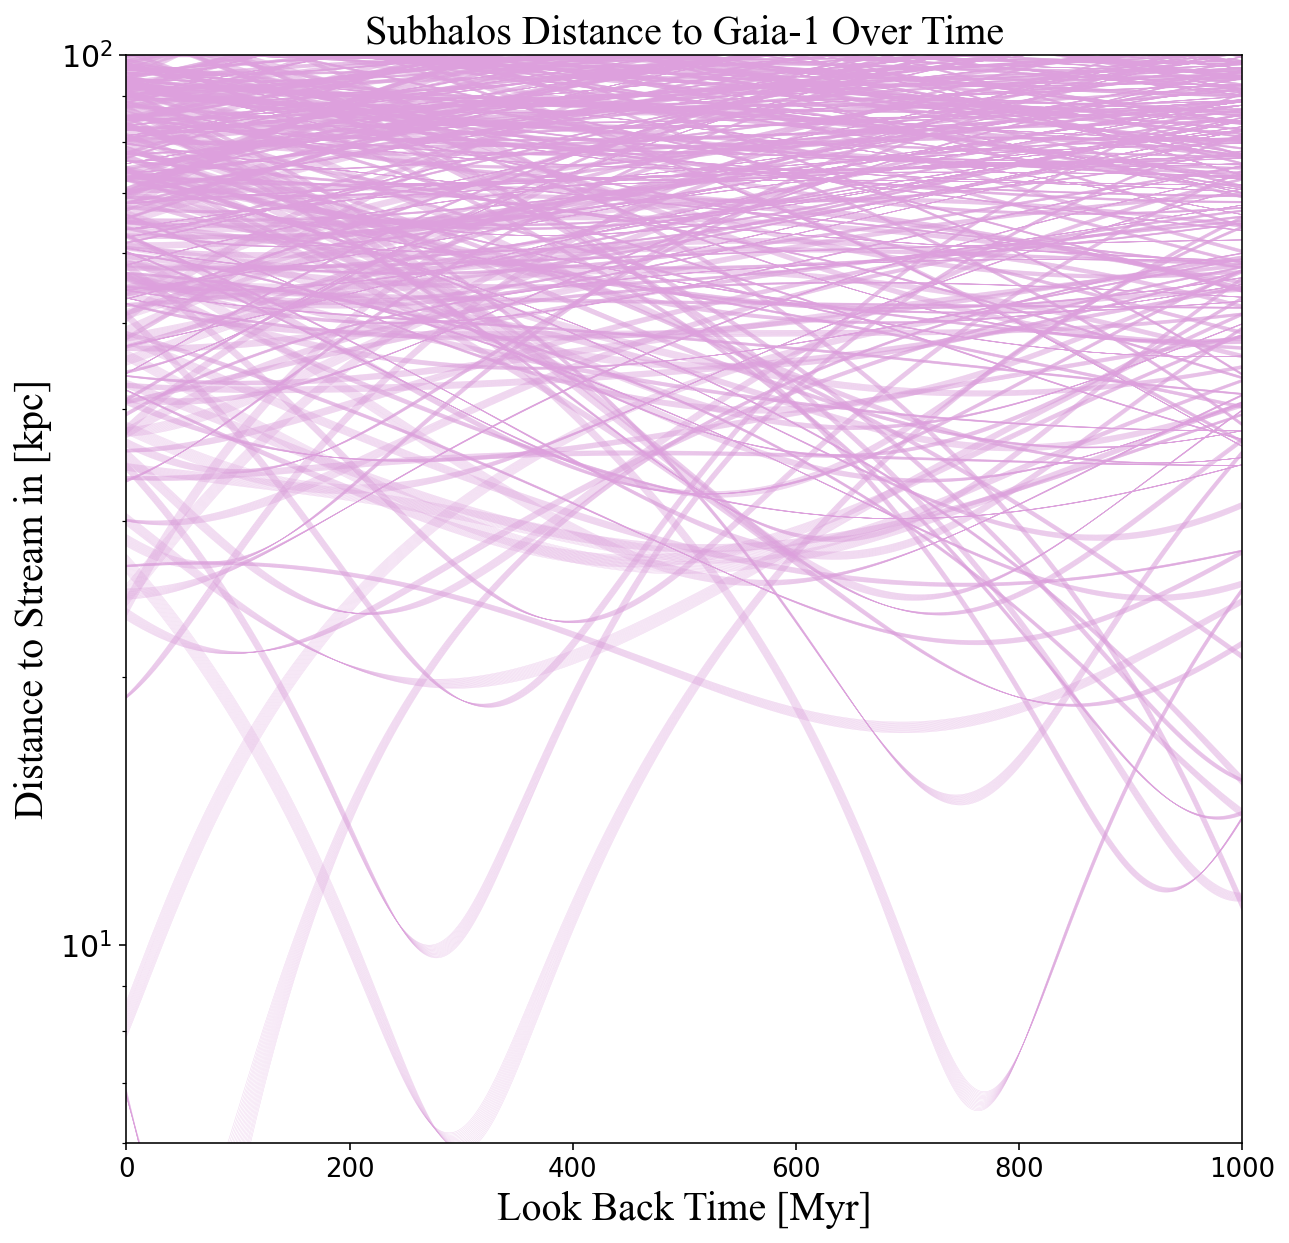

In [73]:
plt.figure(figsize=(10,10))
for subhalo in range(len(yaxis[0])):
    plt.plot(xaxis, yaxis[subhalo], color='plum', alpha=0.5, linewidth=0.2)
csfont = {'fontname':'Times New Roman'}
plt.xlabel('Look Back Time [Myr]', fontsize='20', **csfont )
plt.xticks(fontsize=13)
plt.ylabel('Distance to Stream in [kpc]', fontsize='20', **csfont)
plt.yticks(fontsize=15)
plt.title('Subhalos Distance to Gaia-1 Over Time', fontsize='20', **csfont)
plt.xlim(0, 1000)
plt.ylim(6, 100)
plt.gca().set_yscale('log')
plt.savefig('DistanceToStreamvsLookBackTime')

## Figure 3

Number of Impacts per Gigayear as a function of Velocity kick Impulse

In [50]:
#creating important indices
ind_1 = ((ts['mvir'] >= 10**7) & (ts['mvir'] < 10**8))
ind_2 = ((ts['mvir'] >= 10**8) & (ts['mvir'] < 10**9))
ind_3 = (ts['mvir'] >= 10**9) 
indices = [ind_1, ind_2, ind_3]

In [51]:
def VelImpulse_Mass(streams):
    
    vel_kick1 = pd.DataFrame()
    for ind in(indices):
        #Getting the Orbits of Subhalos
        dt = 0.2*u.Myr
        subh_orbits = []
        Nstep_long=1000
        for subh_ in range(len(ts['x'][ind])): 
            #This calculates the position of the subhalos at a given time
            c_subh = coord.Galactocentric(x=ts['x'][ind][subh_]*u.kpc, y=ts['y'][ind][subh_]*u.kpc, 
                                          z=ts['z'][ind][subh_]*u.kpc,
                                          v_x=ts['vx'][ind][subh_]*u.km/u.s, 
                                          v_y=ts['vy'][ind][subh_]*u.km/u.s,
                                          v_z=ts['vz'][ind][subh_]*u.km/u.s)
            w0_subh = gd.PhaseSpacePosition(c_subh.cartesian)
            subh_orbits += [ham.integrate_orbit(w0_subh, dt=-dt, n_steps=Nstep_long)]

        #Rotating Subhalo Position Orbits 
        N = len(subh_orbits[0].pos.x)

        rot_orbits=np.zeros((len(ts['x'][ind]), len(subh_orbits[1].pos.x), 3))

        for j, subh in enumerate(subh_orbits):
            for i in range(N):
                temp_vec = np.array([subh.pos.x[i].value, subh.pos.y[i].value, subh.pos.z[i].value])
                rot_vec = np.matmul(R, temp_vec)

                rot_orbits[j][i][0] = rot_vec[0]
                rot_orbits[j][i][1] = rot_vec[1]
                rot_orbits[j][i][2] = rot_vec[2]

        #Rotating Subhalo Velocity Orbits 
        N = len(subh_orbits[0].vel.d_x)

        rot_orbits_vel=np.zeros((len(ts['vx'][ind]), len(subh_orbits[1].vel.d_x), 3))

        for j, subh in enumerate(subh_orbits):
            for i in range(N):
                temp_vec_vel = np.array([subh.vel.d_x.to(u.km/u.s)[i].value, 
                                         subh.vel.d_y.to(u.km/u.s)[i].value, 
                                         subh.vel.d_z.to(u.km/u.s)[i].value])
                rot_vec_vel = np.matmul(R, temp_vec_vel)

                rot_orbits_vel[j][i][0] = rot_vec_vel[0]
                rot_orbits_vel[j][i][1] = rot_vec_vel[1]
                rot_orbits_vel[j][i][2] = rot_vec_vel[2]
        
        
        
        #Now we get the orbits of the streams 
        c = coord.SkyCoord(ra=streams.iloc[4][1]*u.deg, dec=streams.iloc[4][2]*u.deg, distance=streams.iloc[4][3]*u.kpc, 
                           pm_ra_cosdec=streams.iloc[4][4]*u.mas/u.yr,pm_dec=streams.iloc[4][5]*u.mas/u.yr, 
                           radial_velocity=streams.iloc[4][6]*u.km/u.s, frame='icrs')

        w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
        dt = 0.2*u.Myr
        Nstep_foward = list(Nstep_foward_dict.values())[4]
        orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
        orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())
        w0_start = gd.PhaseSpacePosition(orbit_foward.pos, orbit_foward.vel)
        Nstep = list(Nstep_represent_dict.values())[4] 
        orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
        #Going back for 1 Gyr - Anything past this, we anticipate a progenitor
        Nstep_long = 1000
        orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)


        data_new = {'Stream':[str(streams.iloc[4]['Stream'])]}
        data_temp = pd.DataFrame(data=data_new)

        #print('Length of trot', len(trot['x'][ind]))
        for subh in range(len(ts['x'][ind])): #subh stands for individual subhalo
            Npoint = np.shape(orbit_long.pos)[1]
            shape = np.shape(orbit_long.pos)
            #creating individual arrays to store information 
            distances_x = np.empty(shape)
            distances_y = np.empty(shape)
            distances_z = np.empty(shape)
            velocity_x = np.empty(shape)
            velocity_y = np.empty(shape)
            velocity_z = np.empty(shape)

        ########## creating a temporary array that stores the location of the stars in the stream  ########
        #taking the distance from the points to a given stream#
            for point in range(Npoint):
                #print("Shape of rot orbit:", np.shape(rot_orbits[subh,:,0]*u.kpc)) 
               
                distances_x[:, point] = orbit_long.pos.x[:,point] - rot_orbits[subh,:,0]*u.kpc
                distances_y[:, point] = orbit_long.pos.y[:,point] - rot_orbits[subh,:,1]*u.kpc
                distances_z[:, point] = orbit_long.pos.z[:,point] - rot_orbits[subh,:,2]*u.kpc

                velocity_x[:, point] = orbit_long.vel.d_x.to(u.km/u.s)[:,point] - rot_orbits_vel[subh,:,0]*(u.km/u.s)
                velocity_y[:, point] = orbit_long.vel.d_y.to(u.km/u.s)[:,point] - rot_orbits_vel[subh,:,1]*(u.km/u.s)
                velocity_z[:, point] = orbit_long.vel.d_z.to(u.km/u.s)[:,point] - rot_orbits_vel[subh,:,2]*(u.km/u.s)

                rel_dist = np.sqrt((distances_x**2)+(distances_y**2)+(distances_z**2)) 
                rel_vel = np.sqrt(velocity_x**2 + velocity_y**2 + velocity_z**2)
                min_ind = np.argmin(rel_dist, axis=1)
                rel_dist_min = rel_dist[:,min_ind][:,0]
                rel_vel_at_min = rel_vel[:,min_ind][:,0]

                G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) 
                r_min = rel_dist_min*u.kpc  
                v_rel = rel_vel_at_min*(u.km/u.s) #relative vel btwn stream and subhalos at shortest distance
                mass_subh = (np.array(ts['mvir'][ts['mvir']>10**7])[subh])*u.M_sun 
                delta_v = 2*G*mass_subh/(r_min*v_rel) 
                vel_kick_temp = np.sqrt(np.sum(delta_v**2))

                data_temp['Subhalo_'+ str(subh)+ ' Velocity Kick (km/s)'] = [vel_kick_temp.to(u.km/u.s)]
                data_temp['Subhalo_'+ str(subh)+ ' Relative Distance (kpc)'] = [rel_dist]
            
        vel_kick1 = vel_kick1.append(data_temp, ignore_index=True)
            
    return vel_kick1



In [52]:
vel_impulse_with_mass = VelImpulse_Mass(streams)

<ipython-input-51-626a5fc1cdbb>:98: RuntimeWarning: overflow encountered in square
  rel_vel = np.sqrt(velocity_x**2 + velocity_y**2 + velocity_z**2)
<ipython-input-51-626a5fc1cdbb>:98: RuntimeWarning: invalid value encountered in square
  rel_vel = np.sqrt(velocity_x**2 + velocity_y**2 + velocity_z**2)


In [53]:
vel_impulse_1_temp = vel_impulse_with_mass.iloc[0][1::2]
vel_impulse_1 = vel_impulse_1_temp.astype(str).str.split().str[0].astype(float)

vel_impulse_2_temp = vel_impulse_with_mass.iloc[1][1::2]
vel_impulse_2 = vel_impulse_2_temp.astype(str).str.split().str[0].astype(float)

vel_impulse_3_temp = vel_impulse_with_mass.iloc[2][1::2]
vel_impulse_3 = vel_impulse_3_temp.astype(str).str.split().str[0].astype(float)

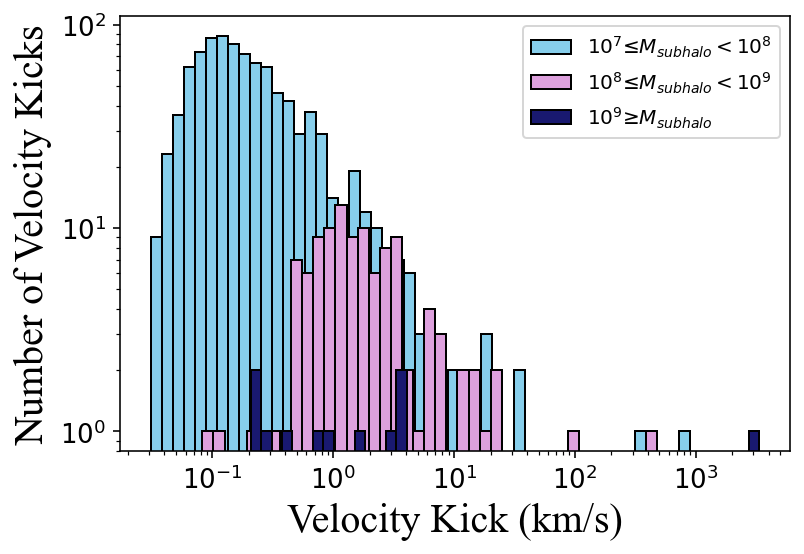

In [54]:
plt.figure()
plt.hist(vel_impulse_1, bins=np.logspace(np.log10(vel_impulse_1.min()), np.log10(vel_impulse_1.max())), alpha=1, color='skyblue', edgecolor='black', label='$10^{7} ≤ M_{subhalo} < 10^{8}$')
plt.hist(vel_impulse_2, bins=np.logspace(np.log10(vel_impulse_2.min()), np.log10(vel_impulse_2.max())), alpha=1, color='plum', edgecolor='black', stacked=True, label='$10^{8} ≤ M_{subhalo} < 10^{9}$')
plt.hist(vel_impulse_3, bins=np.logspace(np.log10(vel_impulse_3.min()), np.log10(vel_impulse_3.max())), alpha=1, color='midnightblue', edgecolor='black', stacked=True, label='$10^{9} ≥ M_{subhalo}$')

plt.xlabel('Velocity Kick (km/s)', fontsize='20', **csfont )
plt.xticks(fontsize=13)
plt.ylabel('Number of Velocity Kicks', fontsize='20', **csfont)
plt.yticks(fontsize=13)
plt.legend(loc='best')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.show()

In [55]:
def std(data):
    #this takes in an array and finds the standard deviation
    numerator = data - np.mean(data)
    denominator = len(data)
    std = numerator/denominator
    return std

In [56]:
x_axis_1 = np.linspace(0, len(vel_impulse_1), len(vel_impulse_1)+1)[1:]
x_axis_2 = np.linspace(0, len(vel_impulse_2), len(vel_impulse_2)+1)[1:]
x_axis_3 = np.linspace(0, len(vel_impulse_3), len(vel_impulse_3)+1)[1:]

yerr_1=std(vel_impulse_1)*10
yerr_2=std(vel_impulse_2)*10
yerr_3=std(vel_impulse_3)*10

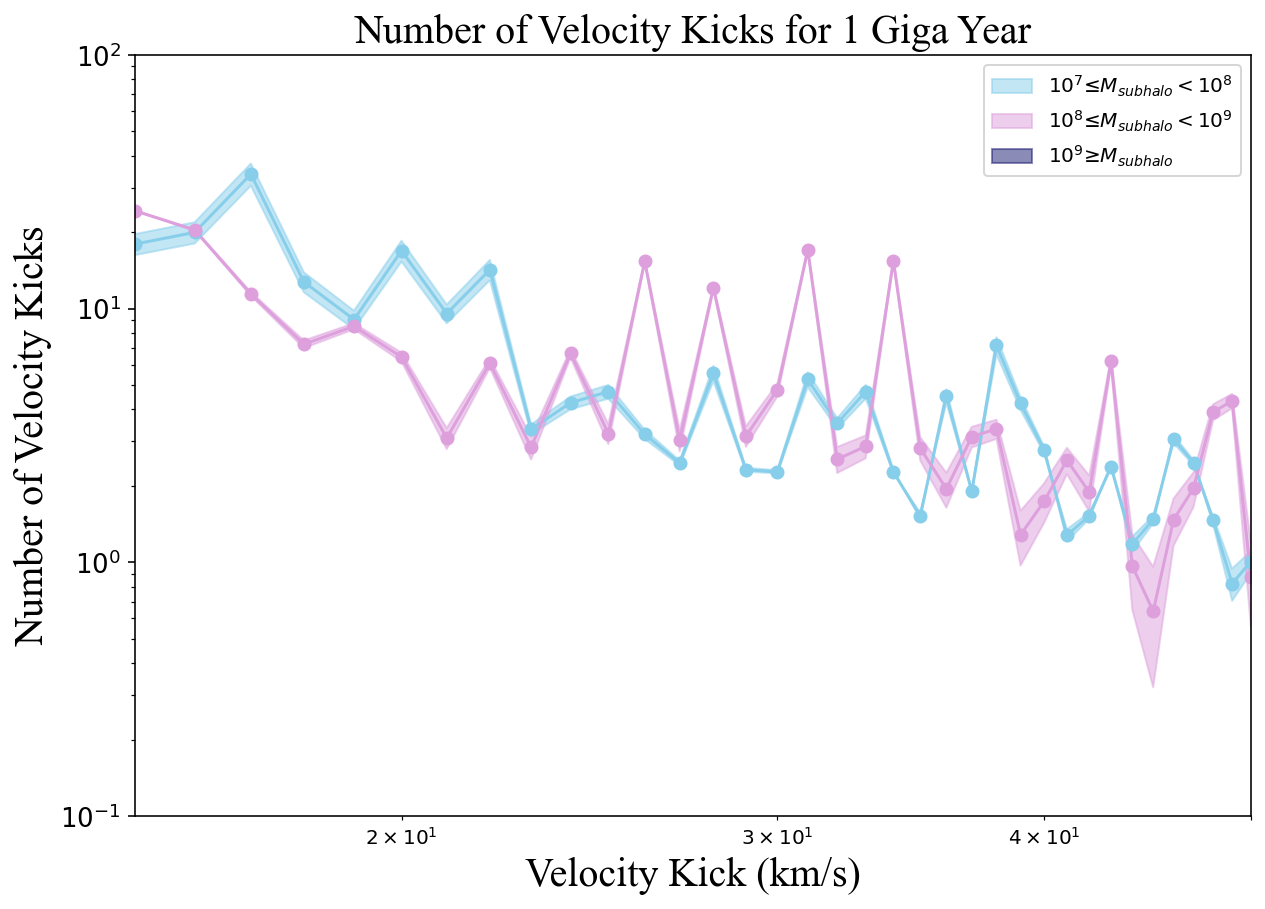

In [75]:
plt.figure(figsize=(10,7))
plt.plot(x_axis_1, vel_impulse_1, '-', color='skyblue')
plt.plot(x_axis_2, vel_impulse_2, '-', color='plum')
plt.plot(x_axis_3, vel_impulse_3, '-', color='midnightblue')
plt.fill_between(x_axis_1, vel_impulse_1-(yerr_1*10), vel_impulse_1+(yerr_1*10), color='skyblue', alpha=0.5, label='$10^{7} ≤ M_{subhalo} < 10^{8}$')
plt.fill_between(x_axis_2, vel_impulse_2-(yerr_2), vel_impulse_2+(yerr_2), color='plum', alpha=0.5, label='$10^{8} ≤ M_{subhalo} < 10^{9}$')
plt.fill_between(x_axis_3, vel_impulse_3-(yerr_3), vel_impulse_3+(yerr_3), color='midnightblue', alpha=0.5, label='$10^{9} ≥ M_{subhalo}$')

plt.plot(x_axis_1, vel_impulse_1, 'o', color='skyblue')
plt.plot(x_axis_2, vel_impulse_2, 'o', color='plum')
plt.plot(x_axis_3, vel_impulse_3, 'o', color='midnightblue')

plt.xlabel('Velocity Kick (km/s)', fontsize='20', **csfont )
plt.xticks(fontsize=13)
plt.ylabel('Number of Velocity Kicks', fontsize='20', **csfont)
plt.title('Number of Velocity Kicks for 1 Giga Year', fontsize='20', **csfont)
plt.yticks(fontsize=13)
plt.xlim(1.5*10**1, 0.5*10**2)
plt.ylim(10**(-1), 10**2)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.legend(loc='best')
plt.show()


### Figure 4

Number of Velocity kicks as a function of Proximity to LMC Analog

In [58]:
def VelKicks_Gaia(streams):
    vel_kick1 = pd.DataFrame()
    
    c = coord.SkyCoord(ra=streams.iloc[4][1]*u.deg, dec=streams.iloc[4][2]*u.deg, distance=streams.iloc[4][3]*u.kpc, 
                       pm_ra_cosdec=streams.iloc[4][4]*u.mas/u.yr,pm_dec=streams.iloc[4][5]*u.mas/u.yr, 
                       radial_velocity=streams.iloc[4][6]*u.km/u.s, frame='icrs')
    
    w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
    dt = 0.2*u.Myr
    Nstep_foward = list(Nstep_foward_dict.values())[4]
    orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
    orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())
    w0_start = gd.PhaseSpacePosition(orbit_foward.pos, orbit_foward.vel)
    Nstep = list(Nstep_represent_dict.values())[4] 
    orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
    #Going back for 1 Gyr - Anything past this, we anticipate a progenitor
    Nstep_long = 1000
    orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)


    data_new = {'Stream':[str(streams.iloc[4]['Stream'])]}
    data_temp = pd.DataFrame(data=data_new)

    for subh in range(len(trot['x'])): #subh stands for individual subhalo
        Npoint = np.shape(orbit_long.pos)[1]
        shape = np.shape(orbit_long.pos)
        #creating individual arrays to store information 
        distances_x = np.empty(shape)
        distances_y = np.empty(shape)
        distances_z = np.empty(shape)
        velocity_x = np.empty(shape)
        velocity_y = np.empty(shape)
        velocity_z = np.empty(shape)
                
    ########## creating a temporary array that stores the location of the stars in the stream  ########
    #taking the distance from the points to a given stream#
        for point in range(Npoint):
            distances_x[:, point] = orbit_long.pos.x[:,point] - rot_orbits[subh,:,0]*u.kpc
            distances_y[:, point] = orbit_long.pos.y[:,point] - rot_orbits[subh,:,1]*u.kpc
            distances_z[:, point] = orbit_long.pos.z[:,point] - rot_orbits[subh,:,2]*u.kpc

            velocity_x[:, point] = orbit_long.vel.d_x.to(u.km/u.s)[:,point] - rot_orbits_vel[subh,:,0]*(u.km/u.s)
            velocity_y[:, point] = orbit_long.vel.d_y.to(u.km/u.s)[:,point] - rot_orbits_vel[subh,:,1]*(u.km/u.s)
            velocity_z[:, point] = orbit_long.vel.d_z.to(u.km/u.s)[:,point] - rot_orbits_vel[subh,:,2]*(u.km/u.s)

            rel_dist = np.sqrt((distances_x**2)+(distances_y**2)+(distances_z**2)) 
            rel_vel = np.sqrt(velocity_x**2 + velocity_y**2 + velocity_z**2)
            min_ind = np.argmin(rel_dist, axis=1)
            rel_dist_min = rel_dist[:,min_ind][:,0]
            rel_vel_at_min = rel_vel[:,min_ind][:,0]
          
            G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) 
            r_min = rel_dist_min*u.kpc  
            v_rel = rel_vel_at_min*(u.km/u.s) #relative vel btwn stream and subhalos at shortest distance
            mass_subh = (np.array(ts['mvir'][ts['mvir']>10**7])[subh])*u.M_sun 
            delta_v = 2*G*mass_subh/(r_min*v_rel) 
            vel_kick_temp = np.sqrt(np.sum(delta_v**2))

            data_temp['Subhalo_'+ str(subh)+ ' Velocity Kick (km/s)'] = [vel_kick_temp.to(u.km/u.s)]
            data_temp['Subhalo_'+ str(subh)+ ' Relative Distance (kpc)'] = [rel_dist]
            
    vel_kick1 = vel_kick1.append(data_temp, ignore_index=True)
            
    return vel_kick1



In [59]:
vel_kicks_gaia1 = VelKicks_Gaia(streams)
vel_kicks_gaia1

<ipython-input-58-6ed4551089f7>:46: RuntimeWarning: overflow encountered in square
  rel_dist = np.sqrt((distances_x**2)+(distances_y**2)+(distances_z**2))
<ipython-input-58-6ed4551089f7>:47: RuntimeWarning: overflow encountered in square
  rel_vel = np.sqrt(velocity_x**2 + velocity_y**2 + velocity_z**2)
<ipython-input-58-6ed4551089f7>:47: RuntimeWarning: invalid value encountered in square
  rel_vel = np.sqrt(velocity_x**2 + velocity_y**2 + velocity_z**2)


Stream Subhalo_0 Velocity Kick (km/s)  \
0  Gaia_1      2.0657261894736165 km / s   

                   Subhalo_0 Relative Distance (kpc)  \
0  [[96.88029288263282, 96.80932724095291, 96.738...   

  Subhalo_1 Velocity Kick (km/s)  \
0       2.415120357024868 km / s   

                   Subhalo_1 Relative Distance (kpc)  \
0  [[60.40375423716839, 60.48079286074414, 60.557...   

  Subhalo_2 Velocity Kick (km/s)  \
0      0.7257550481166875 km / s   

                   Subhalo_2 Relative Distance (kpc)  \
0  [[43.86392813460824, 43.868073607063565, 43.87...   

  Subhalo_3 Velocity Kick (km/s)  \
0       4.577353557854363 km / s   

                   Subhalo_3 Relative Distance (kpc)  \
0  [[154.37995947477833, 154.42605990189804, 154....   

  Subhalo_4 Velocity Kick (km/s)  ... Subhalo_1057 Velocity Kick (km/s)  \
0      0.4991279448256944 km / s  ...        0.10772182395978094 km / s   

                Subhalo_1057 Relative Distance (kpc)  \
0  [[129.02546630425073, 128.97985878167867, 128....   

  Subhalo_1058 Velocity Kick (km/s)  \
0        0.06803118026207751 km / s   

                Subhalo_1058 Relative Distance (kpc)  \
0  [[175.3710313822292, 175.40492586901001, 175.4...   

  Subhalo_1059 Velocity Kick (km/s)  \
0         0.1079881318066429 km / s   

                Subhalo_1059 Relative Distance (kpc)  \
0  [[98.13845643127262, 98.18305023181244, 98.227...   

  Subhalo_1060 Velocity Kick (km/s)  \
0        0.10418907552175019 km / s   

                Subhalo_1060 Relative Distance (kpc)  \
0  [[63.11639579416272, 63.164702767491434, 63.21...   

  Subhalo_1061 Velocity Kick (km/s)  \
0        0.04422837718180939 km / s   

                Subhalo_1061 Relative Distance (kpc)  
0  [[186.24754868058972, 186.31940481319907, 186....  

[1 rows x 2125 columns]

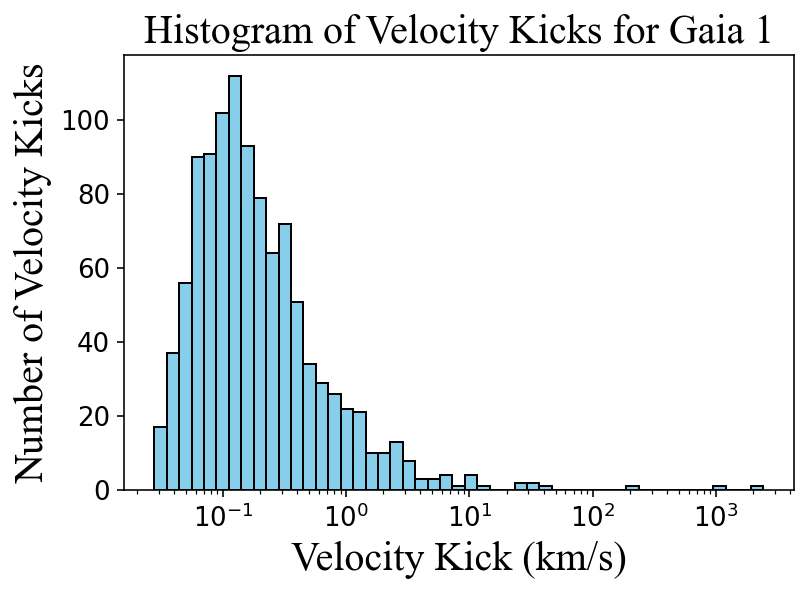

In [60]:
velocity_kicks_gaia1 = vel_kicks_gaia1.iloc[0][1::2]
# Extract numerical values from the Series
velocity_values = velocity_kicks_gaia1.astype(str).str.split().str[0].astype(float)
# velocity values stores the velocity kick due to each subhalo

# Plot histogram
plt.hist(velocity_values, bins=np.logspace(np.log10(velocity_values.min()), np.log10(velocity_values.max())), color='skyblue', edgecolor='black')
csfont = {'fontname':'Times New Roman'}
plt.xlabel('Velocity Kick (km/s)', fontsize='20', **csfont )
plt.xticks(fontsize=13)
plt.ylabel('Number of Velocity Kicks', fontsize='20', **csfont)
plt.yticks(fontsize=13)
plt.title('Histogram of Velocity Kicks for Gaia 1', fontsize='20', **csfont)
plt.gca().set_xscale('log')
plt.show()

In [61]:
lmc_loc = []
for time in range(len(rot_orbits[0])):
    lmc_loc_temp = np.sqrt(rot_orbits[0][time][0]**2 + rot_orbits[0][time][1]**2 + rot_orbits[0][time][2]**2)
    lmc_loc.append(lmc_loc_temp)

In [62]:
proximity_to_lmc_analog = []
for subhalo in range(len(vel_kicks_gaia1.iloc[0][2::2])):
    proximity_to_lmc_analog_temp = np.average(vel_kicks_gaia1.iloc[0][2::2][subhalo]) - lmc_loc
    proximity_to_lmc_analog.append(proximity_to_lmc_analog_temp)

In [63]:
#Now I find the closest MINIMUM proximity of all time PER subhalo
closest_proximity_to_lmc_analog = []
for time in range(len(proximity_to_lmc_analog)):
    closest_proximity_to_lmc_analog_temp = np.min(proximity_to_lmc_analog[time])
    closest_proximity_to_lmc_analog.append(closest_proximity_to_lmc_analog_temp)

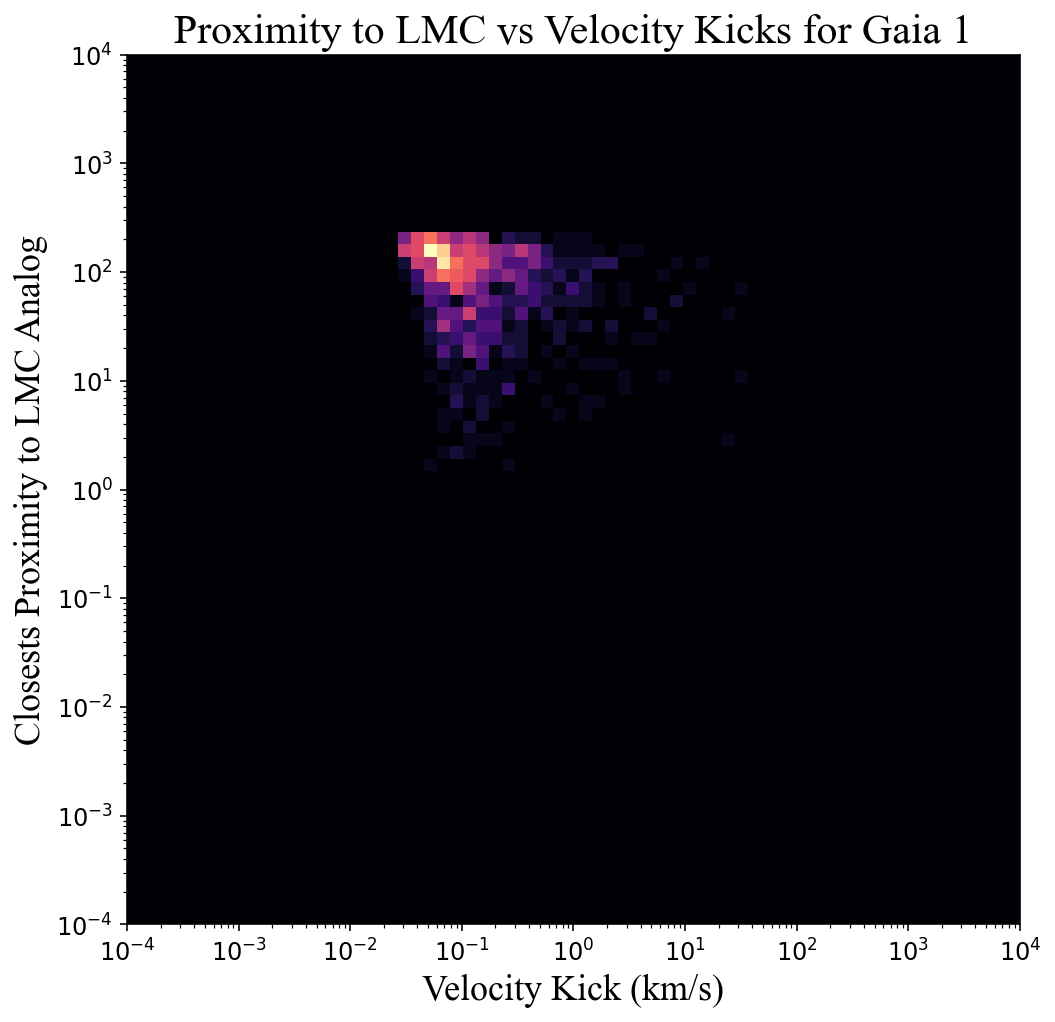

In [64]:
# Plot histogram

plt.figure(figsize=(8,8))
plt.hist2d(velocity_values, closest_proximity_to_lmc_analog, 
           bins=np.logspace(-4,4,70), cmap=plt.cm.magma)
csfont = {'fontname':'Times New Roman'}
plt.xlabel('Velocity Kick (km/s)', fontsize='18', **csfont )
plt.xticks(fontsize=12)
plt.ylabel('Closests Proximity to LMC Analog', fontsize='18', **csfont)
plt.yticks(fontsize=12)
plt.title('Proximity to LMC vs Velocity Kicks for Gaia 1', fontsize='21', **csfont)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.show()